# Hand Gesture Recognition / Detection System

## Problem Statement

As a data scientist at a home electronics company specializing in cutting-edge smart televisions, my objective is to develop an innovative feature that enables users to control their TV through gesture recognition. This feature will be powered by a webcam mounted on the TV, continuously monitoring and interpreting five distinct gestures, allowing users to interact with the device without needing a remote control.

The five gestures and their corresponding actions are as follows:

1. **Thumbs Up**: This gesture will be recognized to increase the volume of the TV. When the user gives a thumbs up, the system will detect the gesture and adjust the volume settings accordingly.

2. **Thumbs Down**: Similarly, the thumbs down gesture will decrease the volume when detected, providing a hands-free way to control sound levels.

3. **Left Swipe**: A leftward swipe will trigger the "Jump" command, rewinding the video content by 10 seconds. This gesture allows users to easily revisit a recent moment in their video.

4. **Right Swipe**: In contrast to the left swipe, a right swipe will "Jump" forward by 10 seconds, allowing users to skip ahead without having to manually interact with the interface.

5. **Stop**: A stop gesture will pause the content being played. This gesture provides a quick and intuitive way to halt the video, offering users more control during their viewing experience.

To implement this feature, machine learning algorithms will be employed to train the system to accurately recognize these gestures in real-time. The webcam will continuously capture the user’s movements, and the model will process this input to execute the corresponding commands. This gesture-based control system aims to enhance user convenience and redefine the smart TV experience by providing a seamless, hands-free interaction method.

Each video is a sequence of 30 frames (or images)

## Objectives
The objective is to develop a gesture-based control feature for smart TVs, enabling users to manage volume, skip, rewind, and pause content using five specific gestures detected by a webcam. Machine learning algorithms will train the system to recognize gestures in real-time, offering a hands-free, intuitive TV experience.

1. **Understanding the Dataset**: The training dataset consists of several hundred videos, each categorized into one of five gesture classes. Each video typically lasts 2-3 seconds and is divided into a sequence of 30 frames (images). These videos were captured by different individuals performing one of the five predefined gestures in front of a webcam, similar to the setup used in the smart TV application. The gestures include actions like thumbs up, thumbs down, left swipe, right swipe, and stop, and each video serves as a unique sample for training the gesture recognition model.

2. **Generator**: The generator is responsible for preprocessing the video data and feeding it into the model. It should be capable of processing batches of videos without errors, including essential steps such as cropping, resizing, and normalization. These steps ensure that the input data is properly formatted and standardized before being passed to the model for training.

3. **Model**: The goal is to develop a model that trains efficiently and without errors, while keeping the inference (prediction) time as low as possible. This will be determined by the total number of parameters in the model—fewer parameters lead to faster inference. The model’s performance will also be evaluated based on its accuracy in correctly recognizing the gestures. As suggested by Snehansu, the model should first be trained on a small dataset to evaluate its initial performance before scaling up to larger datasets.

4. **Write-up**: The write-up should document the entire process of model selection and development. It will begin with the rationale for choosing the base model, followed by a detailed discussion of the modifications and experiments conducted to improve performance. Key metrics, such as accuracy and inference time, should be considered when refining the model, with a focus on optimizing the trade-off between performance and efficiency to arrive at the final, most effective solution.

In [44]:
## Checking the GPU configuration
!nvidia-smi

Wed Sep 24 09:22:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0             11W /   60W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import Required Libraries
This code imports essential libraries and modules for deep learning and image processing tasks. **`numpy`** is used for numerical operations and array manipulations. **`os`** allows interaction with the operating system for file and directory management. **`imageio`** and **`PIL`** are used for image reading and resizing. **`matplotlib.pyplot`** is for plotting visualizations. **Keras and TensorFlow** provide tools for building and training deep learning models, including layers like **`Dense`**, **`LSTM`**, and **`Conv3D`**, as well as optimization and model callbacks. Pre-trained models like **`VGG16`** and **`MobileNet`** are imported for transfer learning tasks.

In [45]:
# Định nghĩa đường dẫn dataset chuẩn và đọc CSV an toàn
import os, numpy as np
# Gốc dự án (suy ra từ vị trí notebook). Có thể chỉnh tay nếu bạn di chuyển thư mục.
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd()))
# Thư mục archive (dataset) – nếu bạn đổi vị trí chỉ cần sửa biến này.
folder_name = os.path.join(PROJECT_ROOT, 'archive')
folder_name = os.path.normpath(folder_name)
if not os.path.isdir(folder_name):
    raise FileNotFoundError(f'Không tìm thấy thư mục dataset: {folder_name}')

# Hàm tiện ích đọc file CSV (shuffle nếu cần)
def read_csv_lines(path):
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    return np.random.permutation(lines)

train_csv = os.path.join(folder_name, 'train.csv')
val_csv   = os.path.join(folder_name, 'val.csv')
if not os.path.isfile(train_csv):
    raise FileNotFoundError(train_csv)
if not os.path.isfile(val_csv):
    raise FileNotFoundError(val_csv)

train_doc = read_csv_lines(train_csv)
val_doc   = read_csv_lines(val_csv)

print('Dataset base:', folder_name)
print('Số dòng train:', len(train_doc), '| Số dòng val:', len(val_doc))

Dataset base: d:\TEST_DA\archive
Số dòng train: 663 | Số dòng val: 100


This code sets the random seed to ensure reproducibility of results across different runs of the model. **`np.random.seed(30)`** fixes the random seed for NumPy, ensuring consistent results in numerical operations. **`random.seed(30)`** sets the random seed for Python's built-in random module. **`K.backend`** from Keras ensures consistency in the backend computations, particularly in deep learning models. Finally, **`tf.random.set_seed(30)`** fixes the seed for TensorFlow's random number generation, which is essential for reproducibility in model initialization, data shuffling, and other operations involving randomness. This step helps ensure stable results across experiments.

In [46]:
# ==== Tiện ích xử lý đường dẫn & đọc sequence ====
import os
from typing import List, Optional
from PIL import Image

def resolve_sequence_dir(base_folder: str, seq_name: str) -> Optional[str]:
    """Trả về thư mục chứa sequence (thử các biến thể train/, train/train/)."""
    base_folder = os.path.normpath(base_folder)
    candidates = [
        os.path.join(base_folder, 'train', seq_name),
        os.path.join(base_folder, 'train', 'train', seq_name)
    ]
    for c in candidates:
        if os.path.isdir(c):
            return c
    return None

def list_sequence_frames(base_folder: str, seq_name: str, exts=(".png", ".jpg", ".jpeg")) -> List[str]:
    seq_dir = resolve_sequence_dir(base_folder, seq_name)
    if seq_dir is None:
        raise FileNotFoundError(f'Không tìm thấy thư mục cho sequence: {seq_name}')
    files = sorted([f for f in os.listdir(seq_dir) if f.lower().endswith(exts)])
    if not files:
        raise ValueError(f'Sequence {seq_name} không có frame hợp lệ trong {seq_dir}')
    return [os.path.join(seq_dir, f) for f in files]

def load_frame(path: str):
    return Image.open(path)

print('[INFO] Đã khai báo các hàm tiện ích: resolve_sequence_dir, list_sequence_frames, load_frame')

[INFO] Đã khai báo các hàm tiện ích: resolve_sequence_dir, list_sequence_frames, load_frame


In [47]:
# We set the random seed so that the results don't vary drastically.
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

# Reading the Structured Data
Reading structured data involves loading and processing data stored in organized formats, such as CSV, Excel, or SQL databases, into a format that can be easily manipulated and analyzed. In Python, the `pandas` library is commonly used for this task, as it provides powerful data structures like DataFrames for handling tabular data. Once loaded, you can perform operations such as filtering, sorting, aggregating, and transforming the data. Structured data is typically used in machine learning, data analysis, and data visualization tasks. The process ensures that the data is properly formatted for further analysis or model training.

## Upload the Datasets in Colab
To execute the code in Google Colab (https://colab.research.google.com/), use the following to upload a dataset

## Read the Folder Names for Training and Validation.

**Note:** Set the batch size in such a way that we can use the GPU in full capacity. We keep increasing the batch size until the machine throws an error.

The code snippet demonstrates how to read and randomly shuffle structured data from CSV files. The `folder_name` specifies the directory containing the dataset files. Using `np.random.permutation()`, the rows of the `train.csv` and `val.csv` files are read and shuffled to introduce randomness into the dataset, which helps avoid bias during training. The `batch_size` variable defines the number of samples that will be processed together in one iteration during model training. This approach ensures that the data is well-prepared for training and validation, promoting better model generalization and avoiding overfitting.

In [48]:
# Define project root and proper path handling
import os

# Define the project root as the current working directory
PROJECT_ROOT = os.path.abspath(os.getcwd())
folder_name = os.path.join(PROJECT_ROOT, 'archive')
folder_name = os.path.normpath(folder_name)

# Path utility functions
def resolve_sequence_dir(base_path, sequence_name):
    """
    Resolves the correct path to a sequence directory, handling the nested train/train structure.
    
    Args:
        base_path: Base path to the dataset (e.g. folder_name)
        sequence_name: Name of the sequence directory
        
    Returns:
        str: The full path to the sequence directory
    """
    # Try different possible paths
    candidates = [
        os.path.join(base_path, 'train', sequence_name),
        os.path.join(base_path, 'train', 'train', sequence_name),
        os.path.join(base_path, 'val', sequence_name),
        os.path.join(base_path, 'val', 'val', sequence_name)
    ]
    
    for path in candidates:
        if os.path.exists(path) and os.path.isdir(path):
            return path
    
    # If no valid path is found, return the most likely one
    return candidates[0]

def list_sequence_frames(sequence_dir):
    """
    Lists all image frames in a sequence directory
    
    Args:
        sequence_dir: Path to sequence directory
        
    Returns:
        List of frame filenames sorted
    """
    if not os.path.exists(sequence_dir):
        print(f"Warning: Directory not found: {sequence_dir}")
        return []
        
    return sorted([f for f in os.listdir(sequence_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Now load the CSV files using proper path handling
train_csv = os.path.join(folder_name, 'train.csv')
val_csv = os.path.join(folder_name, 'val.csv')

train_doc = np.random.permutation(open(train_csv).readlines())
val_doc = np.random.permutation(open(val_csv).readlines())
batch_size = 64  # experiment with the batch size

# Set the training and validation data set path - using proper os.path.join
train_path = os.path.join(folder_name, 'train')
val_path = os.path.join(folder_name, 'val')

# Developing Reusable Functions
Creating generic functions involves developing reusable and modular code that can perform specific tasks across different scenarios. These functions are designed to be flexible and adaptable to various inputs, which allows them to be used multiple times without modification. This approach promotes code reusability, reduces redundancy, and enhances maintainability, making your codebase cleaner and more efficient. By writing generic functions, you can streamline the development process and improve collaboration in team projects.

## Create Callback Directory Function
The `callback_directory()` function creates a directory to save model checkpoints and metrics during training. It generates a unique model directory using the current date and time. If the directory doesn't exist, it creates it. The function sets up a **ModelCheckpoint** callback to save the model at each epoch, including training and validation accuracy, loss, and other metrics in the filename. Additionally, the **ReduceLROnPlateau** callback reduces the learning rate when the validation loss stops improving. These callbacks are returned in a list to be used during model training, allowing for the saving and monitoring of model performance over epochs.

In [49]:
# Let us save each model epochs in a directory by making check points and also save the model metrics (training accuracy, traing loss ,validation loss, validation accuracy)
def callback_directory(curr_dt_time):
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

  if not os.path.exists(model_name):
    os.mkdir(model_name)

  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')

  LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
  callbacks_list = [checkpoint, LR]
  return callbacks_list

## Create Normalise Function

The `normalise` function is a simple utility designed to scale the pixel values of an image to the range [0, 1]. This is typically done to standardize the input data for neural networks, improving model training stability and performance.

#### How it Works:
- **Input**: The function takes an image represented as a NumPy array, where pixel values typically range from 0 to 255 (standard 8-bit color channels).
- **Process**: It divides each pixel value by 255, which normalizes the values to the range [0, 1].
- **Output**: The output is the normalized image, where each pixel value is now between 0 and 1, making it more suitable for training deep learning models.

#### Example:
```python
import numpy as np

# Sample image with pixel values ranging from 0 to 255
image = np.array([[0, 128, 255], [64, 192, 255]])

# Normalize the image
normalized_image = normalise(image)

print(normalized_image)
```

Output:
```python
[[0.         0.50196078 1.        ]
 [0.25098039 0.75294118 1.        ]]
```

#### Why Normalize?
- **Improves Convergence**: Neural networks often perform better when input data is normalized. This ensures the model doesn't get biased by large values, speeding up convergence during training.
- **Consistency**: By scaling the values to a consistent range, the model can learn features in a more consistent manner, leading to better generalization.



In [50]:
def normalise(image):
  return image/255.

## Customized Generator Function

### Explanation of the `generator` Function

The `generator` function is designed to load and preprocess batches of video frames for training deep learning models, specifically those working with 3D convolutional networks (Conv3D). This function ensures that data is loaded efficiently in batches and can be used for training without requiring the entire dataset to fit into memory at once. Here's a detailed explanation of how it works:

#### Parameters:
- **`source_path`**: The directory where the video frames are stored.
- **`folder_list`**: A list containing the paths to the folders that store the video frames.
- **`batch_size`**: The number of samples (videos) to be processed in each batch.
- **`y` and `z`**: The desired dimensions (height, width) to which each image will be resized.
- **`normalise`**: A function used to normalize the image pixel values (e.g., scaling pixel values to a range between 0 and 1).

#### Function Workflow:
1. **Initialize Image Index and Parameters**:
   - The function begins by setting the image indices (`img_idx`) to select specific frames from each video. These indices will define which frames are used for the batch.
   - The variables `x`, `y`, and `z` define the number of images per video (from `img_idx`) and the target image dimensions.

2. **Data Shuffling**:
   - `np.random.permutation(folder_list)` shuffles the list of folders (i.e., videos) to ensure that the model sees a diverse set of samples during training, which helps prevent overfitting.

3. **Batch Preparation**:
   - The number of batches is calculated by dividing the total number of samples by the `batch_size`.
   - For each batch, the function initializes two arrays:
     - **`batch_data`**: This will hold the image data, with the shape `(batch_size, x, y, z, 3)`, where 3 corresponds to the RGB color channels.
     - **`batch_labels`**: This will store one-hot encoded labels, with the shape `(batch_size, 5)`, assuming 5 classes for classification.

4. **Reading and Processing Images**:
   - For each video folder in the batch, the images are loaded sequentially. The function reads the image file paths and processes them:
     - If the image width is `160`, it crops the image to `120x120` to maintain consistency in input size.
     - The image is resized to the target size `(y, z)` and converted to a NumPy array.
     - The image is normalized using the provided `normalise` function for each color channel (R, G, B).

5. **One-Hot Encoding of Labels**:
   - Each video folder has a corresponding label (represented by an index). The label is one-hot encoded and placed in the `batch_labels` array.

6. **Yielding Batches**:
   - After processing all the images in the batch, the function yields the `batch_data` (input images) and `batch_labels` (one-hot encoded labels) to be used by the model during training.

7. **Handling Remaining Data**:
   - If the dataset doesn't divide evenly into batches (i.e., if there are leftover samples), the function processes the remaining samples in a smaller batch. It ensures that these leftover samples are also processed correctly by the generator.

8. **Infinite Loop**:
   - The function runs in an infinite loop (`while True`), meaning that it will continue generating batches indefinitely, allowing the training process to continue until manually stopped or until a specified number of epochs is reached.

#### Benefits:
- **Memory Efficiency**: The generator only loads and processes one batch of images at a time, reducing memory usage and enabling the training of models on large datasets.
- **Randomization**: The data is shuffled before each batch, improving the model’s generalization by preventing the model from memorizing the order of the data.
- **On-the-Fly Augmentation**: The function resizes and normalizes images, ensuring the input data is in a consistent format, suitable for training deep learning models.

### Example Usage:
This function would typically be used in the `.fit()` method of a Keras model:
```python
model.fit(generator(source_path, folder_list, batch_size, y, z, normalise), epochs=10, steps_per_epoch=len(folder_list)//batch_size)
```

This allows the model to train using batches generated on-the-fly, ensuring efficient memory usage and data augmentation throughout the training process.

In [51]:
def generator(source_path, folder_list, batch_size, y, z, normalise):
    """
    Refactored generator:
    - Dùng list_sequence_frames để lấy danh sách frame chuẩn (tự xử lý train/ hoặc train/train/).
    - Tránh nối chuỗi thủ công gây lỗi đường dẫn.
    - Giữ nguyên đầu ra: yield (batch_data, batch_labels)
    Params giữ nguyên để không ảnh hưởng các đoạn code cũ.
    """
    from PIL import Image
    import numpy as np, os
    # Chúng ta vẫn in ra source_path để không thay đổi log cũ, nhưng thực tế sẽ ưu tiên folder_name toàn cục
    print('Source path =', source_path, '; batch size =', batch_size, ';Image resolution = ({},{})'.format(y, z))

    # Indices frame dùng cho mỗi sequence (video)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    x = len(img_idx)

    # Base thực tế lấy từ folder_name toàn cục (đã chuẩn hoá ở đầu notebook)
    base_folder = folder_name  # folder_name đã được định nghĩa trước đó

    while True:
        # Shuffle danh sách sequence lines
        t = np.random.permutation(folder_list)
        num_batches = int(len(t) / batch_size)

        def load_sequence_frames(seq_line):
            seq_name = seq_line.strip().split(';')[0]
            frames = list_sequence_frames(base_folder, seq_name)
            # Giới hạn chỉ lấy các index hợp lệ có trong frames
            selected = []
            for idx in img_idx:
                if idx < len(frames):
                    selected.append(frames[idx])
            return selected, int(seq_line.strip().split(';')[2])

        # Các batch đầy đủ
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, y, z, 3), dtype=np.float32)
            batch_labels = np.zeros((batch_size, 5), dtype=np.float32)

            for b in range(batch_size):
                seq_line = t[b + batch * batch_size]
                frame_paths, class_idx = load_sequence_frames(seq_line)

                for fi, fpath in enumerate(frame_paths):
                    try:
                        image = Image.open(fpath)
                    except FileNotFoundError:
                        raise FileNotFoundError(f'Không tìm thấy frame: {fpath}')

                    # Crop nếu ảnh dạng 160x120
                    if image.size[0] == 160:
                        image = image.crop((20, 0, 140, 120))
                    # Resize về (y,z)
                    image = image.resize((y, z))
                    arr = np.asarray(image).astype(np.float32)

                    # Nếu ảnh grayscale mở rộng kênh
                    if arr.ndim == 2:
                        arr = np.stack([arr]*3, axis=-1)
                    # Đảm bảo có 3 kênh
                    if arr.shape[-1] == 4:  # RGBA -> RGB
                        arr = arr[..., :3]

                    # Normalize từng kênh
                    for c in range(3):
                        batch_data[b, fi, :, :, c] = normalise(arr[:, :, c])

                batch_labels[b, class_idx] = 1
            yield batch_data, batch_labels

        # Phần dư nếu không chia hết batch
        remain = len(t) % batch_size
        if remain != 0:
            batch_data = np.zeros((remain, x, y, z, 3), dtype=np.float32)
            batch_labels = np.zeros((remain, 5), dtype=np.float32)
            for b in range(remain):
                seq_line = t[b + num_batches * batch_size]
                frame_paths, class_idx = load_sequence_frames(seq_line)
                for fi, fpath in enumerate(frame_paths):
                    image = Image.open(fpath)
                    if image.size[0] == 160:
                        image = image.crop((20, 0, 140, 120))
                    image = image.resize((y, z))
                    arr = np.asarray(image).astype(np.float32)
                    if arr.ndim == 2:
                        arr = np.stack([arr]*3, axis=-1)
                    if arr.shape[-1] == 4:
                        arr = arr[..., :3]
                    for c in range(3):
                        batch_data[b, fi, :, :, c] = normalise(arr[:, :, c])
                batch_labels[b, class_idx] = 1
            yield batch_data, batch_labels

## Print Model Metrics

- **Hyper String**: The `hyper_string` is created by repeating the word "hyper" 50 times using the multiplication operator `"hyper " * 50`.
- **Print Hyper**: The string is then printed before displaying the training and validation metrics.

### Example Usage:
```python
# Assuming 'model10' is the model name and 'history_model10' is the history object
print_model_metrics_with_hyper("cnn_gru_model", history_model10)
```

This will print the model name followed by the word "hyper" repeated 50 times, then the loss and accuracy metrics for both training and validation.

In [52]:
def print_model_metrics(model_name, history):
    # Print the model name
    print("-" * 50)
    print(f"Model: {model_name}")
    print("-" * 50)

    # Print the training loss values over all epochs
    print("Training Loss: ", history.history['loss'])

    # Print the training categorical accuracy values over all epochs
    print("Training Categorical Accuracy: ", history.history['categorical_accuracy'])

    # Print the validation loss values over all epochs
    print("Validation Loss: ", history.history['val_loss'])

    # Print the validation categorical accuracy values over all epochs
    print("Validation Categorical Accuracy: ", history.history['val_categorical_accuracy'])

## Plot Training and Validation Accuracy and Loss.
This code defines a function plot_history() to plot training and validation accuracy and loss over epochs. It extracts accuracy and loss values from the training history and plots them using matplotlib. The function generates two subplots: one for accuracy and one for loss, showing the progress of both training and validation metrics.

In [53]:
# Plot the graph for accuracy and loss of both training and validation dataset
def plot_history(history, num_epochs):
    # Extracting accuracy and loss from history
    acc, val_acc = history.history['categorical_accuracy'], history.history['val_categorical_accuracy']
    loss, val_loss = history.history['loss'], history.history['val_loss']

    epochs_range = range(num_epochs)

    # Create subplots for accuracy and loss
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Plotting accuracy
    axes[0].plot(epochs_range, acc, label='Training Accuracy')
    axes[0].plot(epochs_range, val_acc, label='Validation Accuracy')
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='lower right')

    # Plotting loss
    axes[1].plot(epochs_range, loss, label='Training Loss')
    axes[1].plot(epochs_range, val_loss, label='Validation Loss')
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='upper right')

    # Display the maximum accuracy values
    print("Max. Training Accuracy:", max(history.history['categorical_accuracy']))
    print("Max. Validation Accuracy:", max(history.history['val_categorical_accuracy']))

    # Display the plots
    plt.tight_layout()
    plt.show()

# Visualizing Data
Visualizing Data involves using graphical representations to better understand the structure, patterns, and relationships within the dataset. It plays a crucial role in data exploration and analysis by helping identify trends, detect outliers, and communicate findings effectively. In machine learning and deep learning, visualizations help in understanding the distribution of input data, evaluating model performance, and debugging model behavior.

**Read the sample image and explore its properties through experimentation.**

1. **`os.listdir()`**: Lists all the files in the directory specified by `folder_name + '/train/' + train_doc[0].split(';')[0]`. This directory corresponds to a sequence of images (video frames) from the dataset.
   
2. **`train_doc[0].split(';')[0]`**: Extracts the folder name from the first entry in the `train_doc` list by splitting it at the semicolon and selecting the first part (the folder path).

3. **`imageio.imread()`**: Reads the first image from the selected folder using the `imageio` library, which handles various image formats. The first image file is selected from the list of images `imgs`.

4. **`astype(np.float32)`**: Converts the image to the `float32` data type, which is commonly used in deep learning tasks for more efficient computation and higher precision.

The result is a sample image loaded into memory, ready for preprocessing or model input.

In [54]:
import imageio

# Get sequence name
seq_name = train_doc[9].strip().split(';')[0]

# Find the correct sequence directory 
sequence_dir = resolve_sequence_dir(folder_name, seq_name)
print(f"Using sequence directory: {sequence_dir}")

# Get list of image files in the sequence directory
imgs = list_sequence_frames(sequence_dir)
print(f"Found {len(imgs)} images in sequence")

# Read the first image if available
if imgs:
    image_path = os.path.join(sequence_dir, imgs[0])
    print(f"Loading image: {image_path}")
    image = imageio.imread(image_path).astype(np.float32)
    print(image)
    print('-'*50)
    print(imgs)
else:
    print("No images found in the sequence directory")

Using sequence directory: d:\TEST_DA\archive\train\train\WIN_20180907_16_32_11_Pro_Stop Gesture_new
Found 30 images in sequence
Loading image: d:\TEST_DA\archive\train\train\WIN_20180907_16_32_11_Pro_Stop Gesture_new\WIN_20180907_16_32_11_Pro_00003.png
[[[112.  85.  56.]
  [119.  92.  63.]
  [120.  90.  62.]
  ...
  [228. 240. 240.]
  [226. 238. 238.]
  [223. 235. 235.]]

 [[108.  81.  52.]
  [113.  86.  57.]
  [115.  85.  57.]
  ...
  [228. 240. 240.]
  [224. 236. 236.]
  [220. 232. 232.]]

 [[100.  73.  44.]
  [108.  81.  52.]
  [117.  87.  59.]
  ...
  [222. 234. 234.]
  [217. 229. 229.]
  [217. 229. 229.]]

 ...

 [[ 16.  17.   9.]
  [ 16.  17.   9.]
  [ 16.  17.   9.]
  ...
  [ 90.  74.  48.]
  [ 90.  74.  48.]
  [ 90.  74.  48.]]

 [[ 15.  16.  10.]
  [ 15.  16.  10.]
  [ 15.  16.  10.]
  ...
  [ 87.  73.  48.]
  [ 87.  73.  48.]
  [ 87.  73.  48.]]

 [[ 15.  16.  10.]
  [ 15.  16.  10.]
  [ 15.  16.  10.]
  ...
  [ 87.  73.  48.]
  [ 87.  73.  48.]
  [ 88.  74.  49.]]]
---------

C:\Users\PC-SON\AppData\Local\Temp\ipykernel_3368\2781560485.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path).astype(np.float32)


## Display images and resize images
1. **Function Definition**: The function `display_and_resize_images` is created to encapsulate the image loading, displaying, and resizing logic.
   
2. **Path Construction**: The `folder_path` variable constructs the path to the folder containing images. This ensures that the file paths are built correctly, regardless of the operating system.

3. **Original Images Display**:
   - `plt.figure(figsize=(8, 8))`: Sets up the figure size.
   - The loop iterates over each image file in the folder (`imgs`) and displays it using `plt.imshow(im)`.
   - Axis ticks and grid are hidden to focus on the images themselves.

4. **Image Resize**:
   - After displaying the original images, the code resizes each image to `100x100` and displays them again.
   - `im.resize((100, 100))`: Resizes the image to the specified size.

5. **Print Statements**: After displaying both the original and resized images, the shape of the last image is printed to show the dimensions.

This version of the code is cleaner, more modular, and easier to understand. It separates the logic into a function and uses `os.path.join()` for cross-platform compatibility.

Using sequence directory: d:\TEST_DA\archive\train\train\WIN_20180907_16_32_11_Pro_Stop Gesture_new


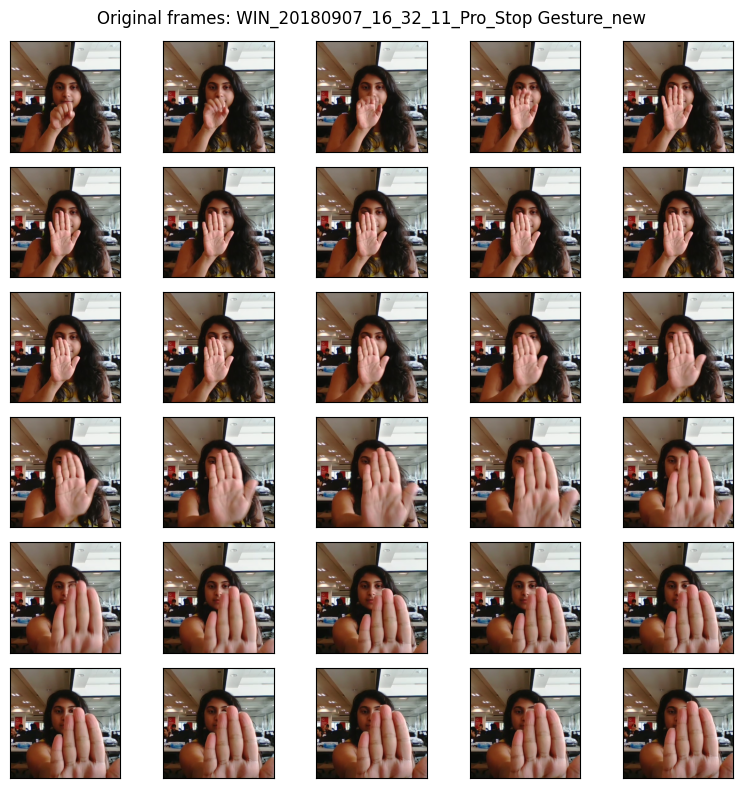

Original last frame shape: (360, 360, 3)
***********************After Resize*******************************************


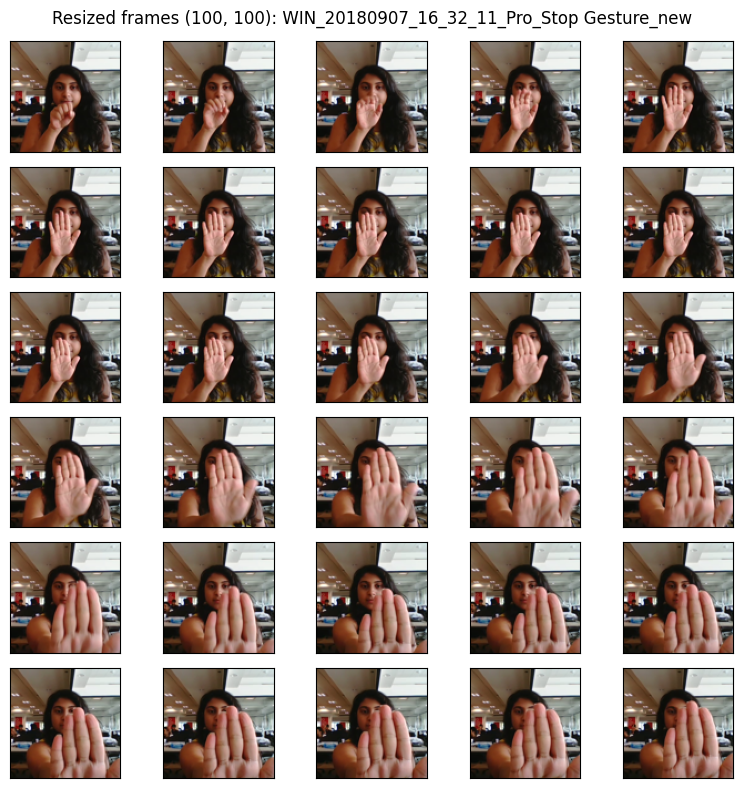

Resized last frame shape: (100, 100, 3)


In [55]:
def display_and_resize_images(folder_name, train_doc, index=9, resize_shape=(100,100)):
    """Display original and resized frames for one sequence using helper path utilities."""
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image

    seq = train_doc[index].split(';')[0].strip()
    
    # Get sequence directory using the helper function
    sequence_dir = resolve_sequence_dir(folder_name, seq)
    print(f"Using sequence directory: {sequence_dir}")
    
    # Get frame paths
    frame_files = list_sequence_frames(sequence_dir)
    if not frame_files:
        print(f"No images found in sequence directory: {sequence_dir}")
        return
        
    # Create full paths for each frame
    frame_paths = [os.path.join(sequence_dir, frame) for frame in frame_files]
    
    # Limit to max 30 frames for grid
    subset = frame_paths[:30]

    plt.figure(figsize=(8,8))
    last_shape = None
    for i, p in enumerate(subset):
        try:
            im = Image.open(p)
            arr = np.asarray(im)
            last_shape = arr.shape
        except Exception as ex:
            print(f"[WARNING] Skipping {p} -> {ex}")
            continue
        plt.subplot(6,5,i+1)
        plt.xticks([]); plt.yticks([]); plt.grid(False)
        plt.imshow(arr)
    plt.suptitle(f'Original frames: {seq}')
    plt.tight_layout(); plt.show()
    if last_shape:
        print('Original last frame shape:', last_shape)

    print('***********************After Resize*******************************************')
    plt.figure(figsize=(8,8))
    resized_last = None
    for i, p in enumerate(subset):
        try:
            im = Image.open(p).resize(resize_shape)
            arr = np.asarray(im)
            resized_last = arr.shape
        except Exception as ex:
            print(f"[WARNING] Skipping resize for {p} -> {ex}")
            continue
        plt.subplot(6,5,i+1)
        plt.xticks([]); plt.yticks([]); plt.grid(False)
        plt.imshow(arr)
    plt.suptitle(f'Resized frames {resize_shape}: {seq}')
    plt.tight_layout(); plt.show()
    if resized_last:
        print('Resized last frame shape:', resized_last)

# Run test
display_and_resize_images(folder_name, train_doc, index=9)

Image 1: WIN_20180907_16_32_11_Pro_00003.png size: (360, 360)
Image 2: WIN_20180907_16_32_11_Pro_00005.png size: (360, 360)
Image 3: WIN_20180907_16_32_11_Pro_00007.png size: (360, 360)


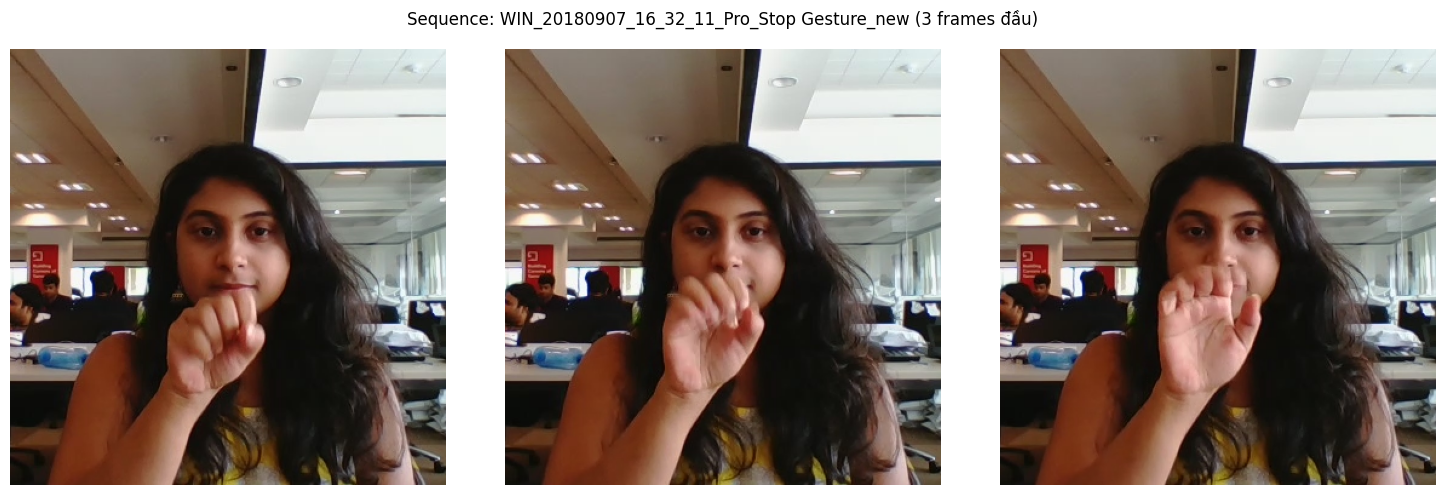

In [56]:
# Create a figure and axis for plotting 3 images horizontally
import os
from PIL import Image
import matplotlib.pyplot as plt

# Chọn index sequence (mặc định 9 như các cell trước)
seq_index = 9
seq_name = train_doc[seq_index].split(';')[0].strip()

# Chuẩn hóa base folder (loại bỏ leading slash nếu cần)
base = os.path.normpath(folder_name)
if os.path.isabs(base) and not os.path.exists(base):
    alt = base.lstrip('\\/')
    if os.path.exists(alt):
        base = alt

# Các khả năng thư mục chứa sequence
candidates = [
    os.path.join(base, 'train', seq_name),
    os.path.join(base, 'train', 'train', seq_name)
]
sequence_dir = None
for c in candidates:
    if os.path.isdir(c):
        sequence_dir = c
        break

if sequence_dir is None:
    print('[ERROR] Không tìm thấy thư mục sequence. Đã thử:')
    for c in candidates:
        print('  ', c)
    raise FileNotFoundError('Sequence folder missing: ' + seq_name)

# Lấy danh sách ảnh
all_imgs = sorted([f for f in os.listdir(sequence_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
if len(all_imgs) < 3:
    raise ValueError(f'Sequence {seq_name} không đủ ảnh (cần >=3, hiện có {len(all_imgs)})')

# Tạo figure 1x3
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    image_path = os.path.join(sequence_dir, all_imgs[i])
    try:
        im = Image.open(image_path)
    except FileNotFoundError:
        print('[WARN] Ảnh không tồn tại:', image_path)
        continue
    axes[i].imshow(im)
    axes[i].axis('off')
    print(f'Image {i+1}:', all_imgs[i], 'size:', im.size)
plt.suptitle(f'Sequence: {seq_name} (3 frames đầu)')
plt.tight_layout()
plt.show()

Using sequence directory: d:\TEST_DA\archive\train\train\WIN_20180907_16_32_11_Pro_Stop Gesture_new
Trying to open: d:\TEST_DA\archive\train\train\WIN_20180907_16_32_11_Pro_Stop Gesture_new\WIN_20180907_16_32_11_Pro_00003.png
Image 1 shape after cropping: (360, 320, 3)
Trying to open: d:\TEST_DA\archive\train\train\WIN_20180907_16_32_11_Pro_Stop Gesture_new\WIN_20180907_16_32_11_Pro_00005.png
Image 2 shape after cropping: (360, 320, 3)
Trying to open: d:\TEST_DA\archive\train\train\WIN_20180907_16_32_11_Pro_Stop Gesture_new\WIN_20180907_16_32_11_Pro_00007.png
Image 3 shape after cropping: (360, 320, 3)


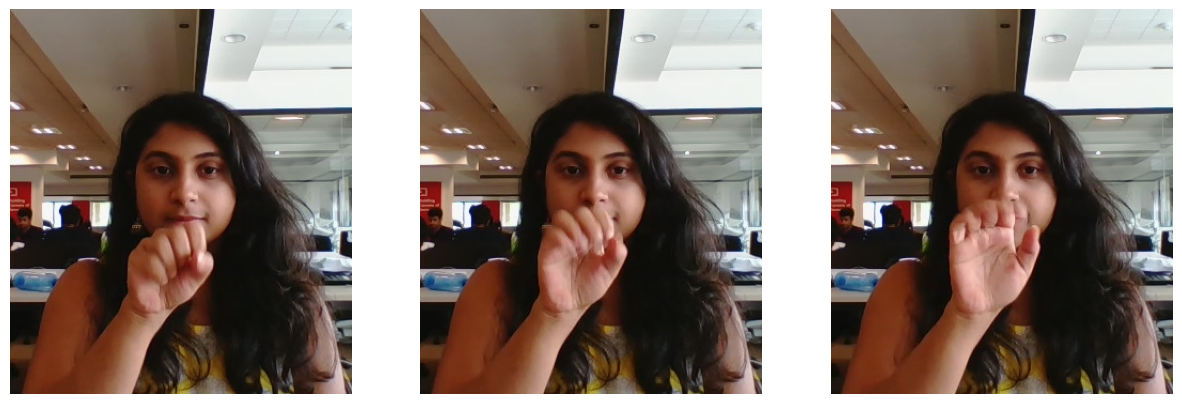

In [57]:
# Create a figure and axis for plotting 3 images horizontally
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Get the sequence name from the training document
seq_name = train_doc[9].split(';')[0]

# Resolve the correct sequence directory
sequence_dir = resolve_sequence_dir(folder_name, seq_name)
print(f"Using sequence directory: {sequence_dir}")

# Get all image files in the sequence
all_imgs = list_sequence_frames(sequence_dir)

if not all_imgs:
    print(f"No images found in directory: {sequence_dir}")
    print(f"Tried to find sequence: {seq_name}")
    print(f"Check that the dataset is properly extracted.")

# If imgs is not defined or empty, use the first few images from all_imgs
if 'imgs' not in locals() or not imgs:
    imgs = all_imgs[:3] if len(all_imgs) >= 3 else all_imgs

# Loop through the images, crop them, and display them
for i in range(min(3, len(imgs))):
    try:
        # Construct the path for each image using proper path handling
        image_path = os.path.join(sequence_dir, imgs[i])
        print(f"Trying to open: {image_path}")
        
        # Open the image using Image.open with error handling
        im = Image.open(image_path)
        
        # Get the current width and height of the image
        width, height = im.size
        
        # Define the coordinates for cropping (left, top, right, bottom)
        left = 20
        top = 0
        right = width - 20
        bottom = height
        
        # Crop the image and convert it to a NumPy array
        im_cropped = np.array(im.crop((left, top, right, bottom)))
        
        # Display the cropped image on the corresponding subplot
        axes[i].imshow(im_cropped)
        axes[i].axis('off')  # Hide axes for a cleaner display
        
        # Check and print the shape of the image after cropping
        print(f"Image {i+1} shape after cropping: {im_cropped.shape}")
    except FileNotFoundError:
        print(f"Could not find image file: {image_path}")
    except Exception as e:
        print(f"Error processing image {i}: {e}")

# Show the plot
plt.show()

**Note:** The dataset has 2 different size images (360 X 360 ) and (160 X 120)

The code creates a NumPy array `arr` with shape `(3, 3)` representing pixel values of an image. Each element in the array corresponds to a pixel intensity value, where the values range from 0 to 255, typically representing RGB color channels.

By dividing the array `arr` by 255 (`arr/255`), the pixel values are normalized to a range between 0 and 1. This is a common preprocessing step in image processing, especially for machine learning models, as it scales the pixel values to a range that makes the training process more stable and efficient. After this operation, the values of the array become fractions of the original range, suitable for input into neural networks or other algorithms that require normalized data.

For example:
- `120 / 255` will become approximately `0.47`
- `130 / 255` will become approximately `0.51`
- `255 / 255` will become `1.0`

This normalization process ensures that the input data has consistent scaling, making it easier for models to learn.

In [58]:
arr = np.array([[120,130,255],[250,255,0],[166,255,1]])
arr/255.

array([[0.47058824, 0.50980392, 1.        ],
       [0.98039216, 1.        , 0.        ],
       [0.65098039, 1.        , 0.00392157]])

# Conv3D Model Architecture

In this section, we design a deep learning model using Keras, leveraging several powerful functionalities to address the specific requirements of the task. The model is built to handle video or time-series data and is designed for efficiency in terms of accuracy and memory usage.

For 3D data, we use **Conv3D** and **MaxPooling3D** layers to capture spatial and temporal features across multiple frames. These layers enable the model to process video-like data by convolving over three-dimensional volumes. The final layer is a **softmax** activation, which helps in classifying the output into distinct categories, as it's commonly used for multi-class classification problems.

Alternatively, for tasks involving 2D frames with temporal dependencies, we implement a **Conv2D + RNN** model. In this case, **TimeDistributed** is used to apply the **Conv2D** layer independently to each frame in a sequence, followed by an RNN layer (e.g., LSTM or GRU) to capture the temporal dynamics of the sequence. Again, the final layer is a **softmax** activation for classification.

A key consideration while designing the network is to balance accuracy with memory constraints. The model is optimized to achieve good performance with a minimal number of parameters, ensuring that it can efficiently run on memory-limited devices like a webcam or embedded systems.

## Creating Conv3dArchitecture

The Conv3D model architecture is designed for processing 3D data, such as videos or sequences of images. It uses **Conv3D** layers to capture both spatial and temporal features from the input, where each frame is considered in conjunction with its neighboring frames. To reduce spatial dimensions and retain important features, **MaxPooling3D** layers are applied after the convolutional layers. The output is flattened and passed through fully connected (Dense) layers to learn high-level representations. The final **softmax** layer provides the probability distribution across multiple classes, making it ideal for multi-class video classification tasks.


In [59]:
def Conv3dArchitecture(x, y, z):
    # Initialize a sequential model
    conv3d_model = Sequential()

    # First Conv3D block: 64 filters, 3x3x3 kernel, same padding, batch normalization, ReLU activation, and MaxPooling
    conv3d_model.add(Conv3D(64, (3, 3, 3), strides=(1, 1, 1), padding='same', input_shape=(x, y, z, 3)))
    conv3d_model.add(BatchNormalization())  # Normalize the activations to stabilize training
    conv3d_model.add(Activation('relu'))  # Apply ReLU activation function
    conv3d_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))  # Pool the output with 2x2x2 size

    # Second Conv3D block: 128 filters, 3x3x3 kernel, same padding, batch normalization, ReLU activation, and MaxPooling
    conv3d_model.add(Conv3D(128, (3, 3, 3), strides=(1, 1, 1), padding='same'))
    conv3d_model.add(BatchNormalization())  # Normalize activations for better training
    conv3d_model.add(Activation('relu'))  # Apply ReLU activation function
    conv3d_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))  # Max pooling layer

    # Third Conv3D block: 256 filters, 3x3x3 kernel, same padding, batch normalization, ReLU activation, and MaxPooling
    conv3d_model.add(Conv3D(256, (3, 3, 3), strides=(1, 1, 1), padding='same'))
    conv3d_model.add(BatchNormalization())  # Batch normalization to stabilize learning
    conv3d_model.add(Activation('relu'))  # Apply ReLU activation function
    conv3d_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))  # Apply max pooling

    # Fourth Conv3D block: 256 filters, 3x3x3 kernel, same padding, batch normalization, ReLU activation, and MaxPooling
    conv3d_model.add(Conv3D(256, (3, 3, 3), strides=(1, 1, 1), padding='same'))
    conv3d_model.add(BatchNormalization())  # Batch normalization for better convergence
    conv3d_model.add(Activation('relu'))  # Apply ReLU activation function
    conv3d_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))  # Pooling operation

    # Flatten the output to convert 3D to 1D for dense layers
    conv3d_model.add(Flatten())

    # Dropout layer to prevent overfitting
    conv3d_model.add(Dropout(0.5))

    # Fully connected (dense) layer with 512 units and ReLU activation
    conv3d_model.add(Dense(512, activation='relu'))

    # Dropout layer to further reduce overfitting
    conv3d_model.add(Dropout(0.5))

    # Output layer with 5 units for 5 classes and softmax activation for multi-class classification
    conv3d_model.add(Dense(5, activation='softmax'))

    return conv3d_model

Image 1: WIN_20180907_16_32_11_Pro_00003.png size: (360, 360)
Image 2: WIN_20180907_16_32_11_Pro_00005.png size: (360, 360)
Image 3: WIN_20180907_16_32_11_Pro_00007.png size: (360, 360)


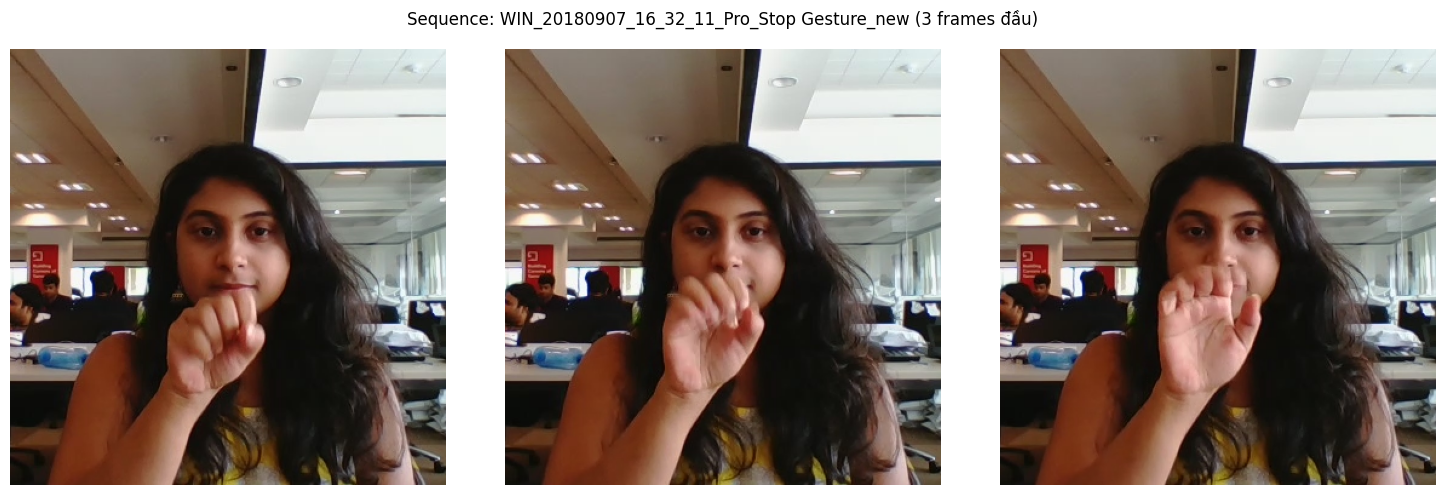

In [60]:
# Hiển thị 3 frame đầu tiên của một sequence với xử lý đường dẫn an toàn
import os
from PIL import Image
import matplotlib.pyplot as plt

# Chọn index sequence (mặc định 9 như các cell trước)
seq_index = 9
seq_name = train_doc[seq_index].split(';')[0].strip()

# Chuẩn hóa base folder (loại bỏ leading slash nếu cần)
base = os.path.normpath(folder_name)
if os.path.isabs(base) and not os.path.exists(base):
    alt = base.lstrip('\\/')
    if os.path.exists(alt):
        base = alt

# Các khả năng thư mục chứa sequence
candidates = [
    os.path.join(base, 'train', seq_name),
    os.path.join(base, 'train', 'train', seq_name)
]
sequence_dir = None
for c in candidates:
    if os.path.isdir(c):
        sequence_dir = c
        break

if sequence_dir is None:
    print('[ERROR] Không tìm thấy thư mục sequence. Đã thử:')
    for c in candidates:
        print('  ', c)
    raise FileNotFoundError('Sequence folder missing: ' + seq_name)

# Lấy danh sách ảnh
all_imgs = sorted([f for f in os.listdir(sequence_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))])
if len(all_imgs) < 3:
    raise ValueError(f'Sequence {seq_name} không đủ ảnh (cần >=3, hiện có {len(all_imgs)})')

# Tạo figure 1x3
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    image_path = os.path.join(sequence_dir, all_imgs[i])
    try:
        im = Image.open(image_path)
    except FileNotFoundError:
        print('[WARN] Ảnh không tồn tại:', image_path)
        continue
    axes[i].imshow(im)
    axes[i].axis('off')
    print(f'Image {i+1}:', all_imgs[i], 'size:', im.size)
plt.suptitle(f'Sequence: {seq_name} (3 frames đầu)')
plt.tight_layout()
plt.show()

**Note:** The next step is to compile the model. When we print the summary of the model, we will see the total number of parameters we have to train.


**Model Summary**

**Note:**
Number of parameters depends on number of filters , filter size, number of layers, number of frames in a sequence, Image resolution, number of neurans in dense layers.

There are 30 frames in a sequence. To classify the video sequence we do not need all the frames.We can reduce the number of training parameters by reducing the number of frames in a sequence. So we will take the alternative frames of a sequence. [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] We are using 18 frames per video for training and validation.


In [ ]:
# Initialize the SGD optimizer with specific parameters
from optimizers 
sgd = optimizers.SGD(learning_rate=0.001,   # Set the learning rate for optimization
                     decay=1e-6,            # Set the weight decay for regularization (L2 penalty)
                     momentum=0.7,          # Set the momentum value to accelerate convergence
                     nesterov=True)         # Enable Nesterov accelerated gradient for faster convergence

# Define a list of image indices (these can be specific samples or indices for training)
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]

# Length of the image index list
x = len(img_idx)

# Set height and width of input images (assuming 100x100 images in this example)
y = 100  # Height of the image
z = 100  # Width of the image

# Initialize the 3D convolutional model with the defined input shape (x, y, z)
conv3d_model = Conv3dArchitecture(x, y, z)

# Compile the model using the SGD optimizer, with categorical crossentropy loss for multi-class classification
conv3d_model.compile(optimizer=sgd,
                     loss='categorical_crossentropy',  # Loss function for multi-class classification
                     metrics=['categorical_accuracy'])  # Track categorical accuracy as a performance metric

# Print the summary of the model architecture (shows details like number of layers, parameters, etc.)
print(conv3d_model.summary())

ModuleNotFoundError: No module named 'optimizers'

In [ ]:
# Just to check the file name format
import datetime as dt
curr_dt_time = dt.datetime.now()
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
print(curr_dt_time)
print(model_name)

2025-01-24 03:33:15.031932
model_init_2025-01-2403_33_15.031932/


In [ ]:
# Set the time to give unique filename to each checkpoint
import datetime
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [ ]:
# Let us save each model epochs in a directory by making check points and also save the model metrics (training accuracy, traing loss ,validation loss, validation accuracy)
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
# Assign the number of steps per epoch for training and validation dataset
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

**Note:** Let us now fit the model. This will start training the model and with the help of the checkpoints, we will be able to save the model at the end of each epoch.

In [ ]:
# Count the sample dataset for each class
num =list(map(lambda x : x.replace('\n','')[-1], train_doc))
print(num.count('0'))
print(num.count('1'))
print(num.count('2'))
print(num.count('3'))
print(num.count('4'))

136
137
130
137
123


**Let us create a dummy model to check the Conv3d model architecture is working correcly or not, with small dataset and less epoch**

In [ ]:
# Let us create the train_generator and the val_generator which will be used in .fit_generator.

batch_size = 32
y = 100 # (y,z) is the Image resolution
z = 100
normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc[0:160], batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc[0:40], batch_size,y,z,normalise)
num_epochs = 2

history = conv3d_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/2


2025-01-24 03:33:20.707141: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 3.4469 - categorical_accuracy: 0.2983Source path =  /datasets/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 00001: saving model to model_init_2025-01-2403_33_15.050079/model-00001-3.44691-0.29830-1.59112-0.35000.h5
11/11 [==============================] - 35s 3s/step - loss: 3.4469 - categorical_accuracy: 0.2983 - val_loss: 1.5911 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 2/2
11/11 [==============================] - ETA: 0s - loss: 1.6583 - categorical_accuracy: 0.4915
Epoch 00002: saving model to model_init_2025-01-2403_33_15.050079/model-00002-1.65833-0.49148-1.65203-0.05000.h5
11/11 [==============================] - 21s 2s/step - loss: 1.6583 - categorical_accuracy: 0.4915 - val_loss: 1.6520 - val_categorical_accuracy: 0.0500 - lr: 0.0010


These metrics help to evaluate how the model is performing during both training and validation and are useful in identifying issues like overfitting or underfitting.

1. **`history.history['loss']`**: This stores the loss values recorded at the end of each epoch during the training process. The loss value represents the model's error, and lower values indicate better performance.
   
2. **`history.history['categorical_accuracy']`**: This stores the categorical accuracy values for each epoch during the training. Categorical accuracy is the percentage of correct predictions out of the total number of predictions made in a multi-class classification problem.

3. **`history.history['val_loss']`**: Similar to training loss, this stores the loss values during the validation phase. This helps monitor how well the model generalizes to unseen data during training.

4. **`history.history['val_categorical_accuracy']`**: This represents the validation categorical accuracy over all epochs. It tells you how accurate the model is when evaluated on the validation dataset after each epoch.

In [ ]:
# Print the training loss values over all epochs
print("Training Loss: ", history.history['loss'])

# Print the training categorical accuracy values over all epochs
print("Training Categorical Accuracy: ", history.history['categorical_accuracy'])

# Print the validation loss values over all epochs
print("Validation Loss: ", history.history['val_loss'])

# Print the validation categorical accuracy values over all epochs
print("Validation Categorical Accuracy: ", history.history['val_categorical_accuracy'])

Training Loss:  [3.446906089782715, 1.6583293676376343]
Training Categorical Accuracy:  [0.2982954680919647, 0.49147728085517883]
Validation Loss:  [1.5911213159561157, 1.6520254611968994]
Validation Categorical Accuracy:  [0.3499999940395355, 0.05000000074505806]


### Evaluating Model No. 1
- **Model**: Model 1 - Conv3D Architecture
- **Batch Size**: 32
- **Number of Epochs**: 20
- **Image Resolution**: 100x100
- **Normalization Method**: Pixel values divided by 255 (scaling between 0 and 1)

**Set the values of number of epochs, batch_size,Image resolution and number of images in sequence**

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 20 # choose the number of epochs
batch_size = 32

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

In [ ]:
# Initialize the SGD optimizer with specific parameters:
# - learning_rate: Set to 0.001, defining the step size for each update.
# - decay: Learning rate decay, set to 1e-6 to gradually decrease the learning rate during training.
# - momentum: Set to 0.7 to help accelerate the gradient descent by using the past gradient's direction.
# - nesterov: Set to True for Nesterov Accelerated Gradient, which gives a more refined gradient update.
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# Create the Conv3D model using the Conv3dArchitecture function, passing the input dimensions (x, y, z).
conv3d_model1 = Conv3dArchitecture(x, y, z)

# Compile the model, specifying the optimizer (SGD), loss function (categorical_crossentropy),
# and evaluation metric (categorical_accuracy). This prepares the model for training.
conv3d_model1.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary to display its architecture, including the number of layers, parameters, etc.
print(conv3d_model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization_4 (Batc  (None, 18, 100, 100, 64)  256      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 50, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization_5 (Batc  (None, 9, 50, 50, 128)  

**Evaluating Model:**
- **Callback Directory**: The `callback_directory(curr_dt_time)` function is called to set up directories for saving model checkpoints during training. It creates a unique directory for each training session based on the current time.

- **Steps Per Epoch**: The number of steps per epoch for both the training and validation datasets is calculated based on the total number of sequences divided by the batch size. If the number of sequences isn't perfectly divisible by the batch size, an additional step is added for any remaining data.

- **Normalization**: A simple lambda function is defined for normalizing the images. It divides the pixel values of the images by 255 to scale them to a [0, 1] range, as most models perform better with data that is scaled.

- **Generators**: The `train_generator` and `val_generator` are initialized by calling the `generator()` function, which will yield batches of data for training and validation. This allows for efficient data loading during model training, especially when dealing with large datasets.

- **Model Training**: The model is trained using the `fit()` method, specifying the `train_generator` and `val_generator` for the training and validation data. The `steps_per_epoch` and `validation_steps` define how many batches of data will be processed per epoch for training and validation, respectively. The model will also use any defined callbacks during training.

In [ ]:
# Call the callback_directory function to create file paths for saving model checkpoints and logs
# The function generates unique file names based on the current date and time
callback_directory(curr_dt_time)

# Calculate the number of steps per epoch for the training dataset
# If the total number of training sequences is perfectly divisible by the batch size,
# use the quotient. Otherwise, add one more step for the remaining data.
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

# Similarly, calculate the number of validation steps for the validation dataset
# If the total number of validation sequences is divisible by the batch size, use the quotient.
# Otherwise, add one more step for the remaining validation data.
if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

# Define the normalization function to scale pixel values between 0 and 1
normalise = lambda a: a / 255.

# Create the train_generator and val_generator using the generator function.
# These generators will provide batches of training and validation data to the model during training.
# The generator function takes care of loading the data, preprocessing it, and yielding batches of data.
train_generator = generator(train_path, train_doc, batch_size, y, z, normalise)
val_generator = generator(val_path, val_doc, batch_size, y, z, normalise)

# Fit the model using the fit method, specifying the training and validation generators,
# the number of steps per epoch, the number of epochs, and the callbacks to be used.
# This trains the model using the data generated by the train_generator and validates it using val_generator.
history_model1 = conv3d_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 2.7185 - categorical_accuracy: 0.3183Source path =  /datasets/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 00001: saving model to model_init_2025-01-2403_33_15.050079/model-00001-2.71853-0.31825-1.61458-0.32000.h5
21/21 [==============================] - 56s 3s/step - loss: 2.7185 - categorical_accuracy: 0.3183 - val_loss: 1.6146 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.6792 - categorical_accuracy: 0.4419
Epoch 00002: saving model to model_init_2025-01-2403_33_15.050079/model-00002-1.67920-0.44193-1.79624-0.19000.h5
21/21 [==============================] - 44s 2s/step - loss: 1.6792 - categorical_accuracy: 0.4419 - val_loss: 1.7962 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
21/21 [==============================

In [ ]:
print_model_metrics("Model No. 1 - Based on Conv3D Architecture", history_model1)

--------------------------------------------------
Model: Model No. 1 - Based on Conv3D Architecture
--------------------------------------------------
Training Loss:  [2.718531847000122, 1.6791958808898926, 1.361059308052063, 1.2586270570755005, 1.170507788658142, 1.0319099426269531, 1.0049418210983276, 0.9981663823127747, 1.0001835823059082, 0.9628448486328125, 0.9000670313835144, 1.0010318756103516, 0.937999963760376, 0.8943736553192139, 0.9362391829490662, 0.9097883105278015, 0.9728146195411682, 0.9707509875297546, 0.9040358066558838, 0.9446439743041992]
Training Categorical Accuracy:  [0.3182503879070282, 0.4419306218624115, 0.5037707686424255, 0.4947209656238556, 0.5309200882911682, 0.5671191811561584, 0.6003016829490662, 0.6003016829490662, 0.5987933874130249, 0.6199095249176025, 0.6304675936698914, 0.5942685008049011, 0.6334841847419739, 0.6530920267105103, 0.6033182740211487, 0.6153846383094788, 0.6093514561653137, 0.6048265695571899, 0.6319758892059326, 0.610859751701355]
Val

### Visualizing Model No. 1
Visualizing the model's performance by plotting training and validation accuracy and loss over epochs. This helps assess how well the model is learning and generalizing, allowing us to identify overfitting or underfitting patterns and tune hyperparameters effectively for better performance.

Max. Training Accuracy: 0.6530920267105103
Max. Validation Accuracy: 0.3499999940395355


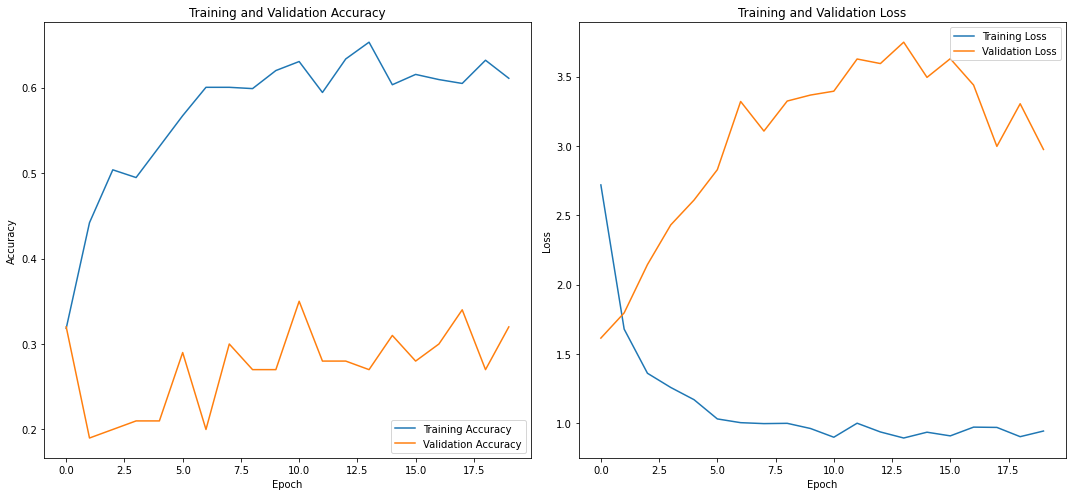

In [ ]:
plot_history(history_model1, num_epochs)

### Model No. 1 - Observations

- **Training Loss**: Decreases steadily from 2.7185 (Epoch 1) to 0.9446 (Epoch 20), showing consistent improvement.
- **Training Accuracy**: Starts at 31.83% (Epoch 1) and gradually increases to 61.09% (Epoch 20), indicating positive training progress.
- **Validation Loss**: Fluctuates throughout, starting at 1.6146 (Epoch 1) and ending at 2.9742 (Epoch 20), with no significant improvement.
- **Validation Accuracy**: Begins at 32% (Epoch 1) and ends at 32% (Epoch 20), with minor fluctuations in between.
- **Learning Rate**: Reduced multiple times via `ReduceLROnPlateau`, from 0.001 to 1e-05, assisting in stabilizing the training.
- **Model Saving**: Model checkpoints were saved after each epoch with corresponding loss and accuracy values.

### Overall Summary

The model demonstrates consistent improvement in training accuracy, reaching 61.09% by Epoch 20. However, validation accuracy remains stagnant at around 32%, suggesting potential overfitting. While training loss decreases consistently, the validation loss remains fluctuating. The learning rate reduction helped stabilize training, but the validation performance suggests room for further optimization and generalization.

### Evaluating Model No. 2
- **Model**: Model 2 - Conv3D Architecture
- **Batch Size**: 32
- **Number of Epochs**: 30
- **Image Resolution**: 100x100
- **Normalization Method**: Pixel values divided by 255 (scaling between 0 and 1)

In [ ]:
# Set the time to give unique filename to each checkpoint
curr_dt_time = datetime.datetime.now()

num_epochs = 30 # choose the number of epochs
batch_size = 32

# Set the Number of training and validation sequence in dataset
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x=len(img_idx) # Number of images in sequence
y = 100
z = 100

In [ ]:
# Using SGD optimizer with specified learning rate, decay, momentum, and Nesterov acceleration
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# Create the Conv3D model by calling the Conv3dArchitecture function, passing the image dimensions
conv3d_model2 = Conv3dArchitecture(x, y, z)

# Compile the model with the SGD optimizer, categorical crossentropy loss function,
# and categorical accuracy as the evaluation metric
conv3d_model2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the summary of the model to get an overview of the architecture (layers, parameters, etc.)
print(conv3d_model2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization_8 (Batc  (None, 18, 100, 100, 64)  256      
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 9, 50, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization_9 (Batc  (None, 9, 50, 50, 128)  

In [ ]:
# Call the callback_directory function to create a unique directory for model checkpoints
# and other files based on the current date and time.
callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training dataset based on the batch size.
# This determines how many batches of data the model will process in one epoch.
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)  # Exact division of sequences by batch size
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1  # Handle remainder by adding one extra step

# Similarly, assign the number of steps per epoch for validation dataset.
if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)  # Exact division of sequences by batch size
else:
    validation_steps = (num_val_sequences // batch_size) + 1  # Handle remainder by adding one extra step

# Create the train_generator and val_generator using the generator function.
# These generators will be used to load data in batches for training and validation.
normalise = lambda a: a / 255.  # Normalization function to scale pixel values to the range [0, 1]
train_generator = generator(train_path, train_doc, batch_size, y, z, normalise)
val_generator = generator(val_path, val_doc, batch_size, y, z, normalise)

# Fit the model using the .fit method, which trains the model on the provided data.
# Pass the train_generator, validation data, and the number of steps for each epoch.
history_model2 = conv3d_model2.fit(
    train_generator,  # Data generator for training
    steps_per_epoch=steps_per_epoch,  # Number of batches to process per epoch
    epochs=num_epochs,  # Total number of epochs to train the model
    verbose=1,  # Verbosity level of the training process
    callbacks=callbacks_list,  # List of callbacks (e.g., model checkpoint, learning rate adjustments)
    validation_data=val_generator,  # Data generator for validation
    validation_steps=validation_steps,  # Number of validation steps per epoch
    class_weight=None,  # Weights for each class (None means no specific weighting)
    workers=1,  # Number of worker threads for data loading
    initial_epoch=0  # The epoch to start from (use 0 to start from scratch)
)

Source path =  /datasets/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.9386 - categorical_accuracy: 0.3107Source path =  /datasets/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 00001: saving model to model_init_2025-01-2403_33_15.050079/model-00001-2.93862-0.31071-1.62002-0.21000.h5
21/21 [==============================] - 39s 2s/step - loss: 2.9386 - categorical_accuracy: 0.3107 - val_loss: 1.6200 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.6431 - categorical_accuracy: 0.4223
Epoch 00002: saving model to model_init_2025-01-2403_33_15.050079/model-00002-1.64311-0.42232-1.72235-0.23000.h5
21/21 [==============================] - 39s 2s/step - loss: 1.6431 - categorical_accuracy: 0.4223 - val_loss: 1.7224 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/30
21/21 [==============================

In [ ]:
print_model_metrics("Model No. 2 - Based on Conv3D Architecture", history_model2)

--------------------------------------------------
Model: Model No. 2 - Based on Conv3D Architecture
--------------------------------------------------
Training Loss:  [2.938624858856201, 1.643109917640686, 1.3628417253494263, 1.114874005317688, 1.0465720891952515, 1.0367811918258667, 1.059543490409851, 0.9484648108482361, 0.969721794128418, 0.99586021900177, 0.9692058563232422, 0.9151895642280579, 0.847463846206665, 0.98264080286026, 0.9246658682823181, 0.858581006526947, 0.9049606919288635, 0.9439178705215454, 0.8864890336990356, 0.8935018181800842, 0.9605631828308105, 0.9102511405944824, 0.9169853925704956, 0.9087554812431335, 0.8562225103378296, 0.9330651760101318, 0.9157562851905823, 0.8706987500190735, 0.9171685576438904, 0.9484112858772278]
Training Categorical Accuracy:  [0.3107089102268219, 0.4223227798938751, 0.4841628968715668, 0.5686274766921997, 0.5791855454444885, 0.576168954372406, 0.5686274766921997, 0.6334841847419739, 0.6123680472373962, 0.6063348650932312, 0.60784316

### Visualizing Model No. 2
Visualizing the model's performance by plotting training and validation accuracy and loss over epochs. This helps assess how well the model is learning and generalizing, allowing us to identify overfitting or underfitting patterns and tune hyperparameters effectively for better performance.

Max. Training Accuracy: 0.6606335043907166
Max. Validation Accuracy: 0.5600000023841858


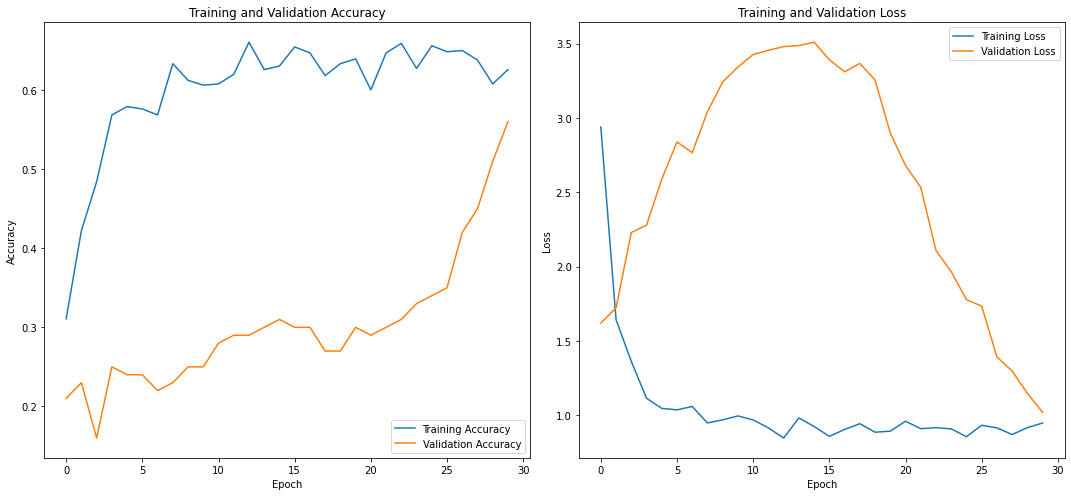

In [ ]:
plot_history(history_model2, num_epochs)

### Model No. 2 - Observations

- **Training Loss**: Decreases steadily from 2.9386 (Epoch 1) to 0.9484 (Epoch 30), showing consistent improvement.
- **Training Accuracy**: Starts at 31.07% (Epoch 1) and gradually increases to 62.59% (Epoch 30), indicating positive training progress.
- **Validation Loss**: Fluctuates throughout, starting at 1.6200 (Epoch 1) and ending at 1.0195 (Epoch 30), with noticeable improvements in the later epochs.
- **Validation Accuracy**: Begins at 21% (Epoch 1) and ends at 56% (Epoch 30), showing a steady upward trend.
- **Learning Rate**: Reduced multiple times via `ReduceLROnPlateau`, from 0.001 to 1e-05, assisting in stabilizing the training and improving performance.
- **Model Saving**: Model checkpoints were saved after each epoch with corresponding loss and accuracy values.

### Overall Summary

This model shows continuous improvement in both training and validation metrics. Training accuracy reaches 62.59% by Epoch 30, while validation accuracy shows steady progress, ending at 56%. The model’s training loss consistently decreases, and validation loss improves significantly over time. The learning rate reduction played a key role in stabilizing the training. Although the validation accuracy is not as high as the training accuracy, the overall trend is positive, suggesting that the model is generalizing better by the end of the training.

# CNN + RNN Stack Architecture

The **CNN + RNN Stack Architecture** combines the strengths of Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs) to handle data with both spatial and temporal dependencies. This architecture is particularly effective for tasks like video analysis, image captioning, and speech recognition, where the input contains both spatial features (captured by CNNs) and temporal patterns (captured by RNNs).

- **CNNs** are designed to extract spatial features from input data, such as images or video frames. They use convolutional layers to apply filters that detect local patterns (edges, textures, shapes) and pooling layers to reduce spatial dimensions while preserving important features. These extracted features form the foundation for higher-level reasoning.

- **RNNs**, on the other hand, are ideal for processing sequential data where temporal dependencies exist. They pass information through time, enabling the model to maintain context from previous inputs. This is especially useful when analyzing sequences of images (like video frames) or text. Variants like Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU) address the challenges of learning long-term dependencies.

In a CNN + RNN stack, CNN layers first extract spatial features, which are then passed to RNN layers to capture the sequential or temporal dependencies, enabling the model to process complex, time-dependent data effectively.

## Creating CNN-LSTM Model

The **CNN-LSTM model** combines Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks to handle both spatial and temporal data. The CNN component, typically based on a pre-trained model like VGG16, extracts spatial features from individual frames or images. These features are then passed through an LSTM layer, which captures temporal dependencies across sequential data. The TimeDistributed wrapper is used to apply the CNN to each time step in the sequence. The final model includes additional LSTM layers to process temporal patterns, followed by dense layers for classification, making it ideal for tasks like video analysis or time-series prediction.

In [ ]:
def cnn_lstm(x, y, z):
    # Initialize the VGG16 model as the base for feature extraction (without the top classification layers)
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y, z, 3))

    # Add a Flatten layer to convert the output of the base model into a 1D array
    a = base_model.output
    a = Flatten()(a)

    # Add a Dense layer for further feature learning
    features = Dense(64, activation='relu')(a)

    # Create a model for feature extraction
    conv_model = Model(inputs=base_model.input, outputs=features)

    # Freeze all layers in the base model so their weights won't be updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Build the final sequential model with time-distributed feature extraction
    model = Sequential()
    model.add(TimeDistributed(conv_model, input_shape=(x, y, z, 3)))  # Apply conv_model to each time step

    # Add LSTM layers to process the temporal dependencies
    model.add(LSTM(64, return_sequences=True))  # First LSTM layer returns sequences for further processing
    model.add(LSTM(32))  # Second LSTM layer outputs the final sequence representation

    # Add a Dense layer for classification (8 output classes)
    model.add(Dense(8, activation='relu'))

    # Final output layer with softmax for multi-class classification (5 classes)
    model.add(Dense(5, activation='softmax'))

    return model


### Evaluating Model No. 3
- **Model**: Model 3 - CNN-LSTM Model
- **Batch Size**: 32
- **Number of Epochs**: 30
- **Image Resolution**: 100x100
- **Optimizer** = SGD

In [ ]:
# Initialize the SGD optimizer with specified parameters
sgd = optimizers.SGD(learning_rate=0.001,   # Set the learning rate for optimization
                     decay=1e-6,            # Set weight decay for L2 regularization to prevent overfitting
                     momentum=0.7,          # Momentum to accelerate convergence by considering previous gradients
                     nesterov=True)         # Enable Nesterov accelerated gradient for faster convergence

# Initialize the CNN-LSTM model by calling the cnn_lstm function with x, y, and z as input dimensions
model3 = cnn_lstm(x, y, z)

# Compile the model:
# - Use the SGD optimizer for training
# - Set 'categorical_crossentropy' as the loss function (for multi-class classification)
# - Use 'categorical_accuracy' to evaluate the model’s accuracy during training
model3.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the summary of the model architecture to inspect its layers and parameters
print(model3.summary())

58900480/58889256 [==============================] - 5s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 64)           15009664  
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 18, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 8)                 264       
                                                                 
 dense_8 (Dense)             (None, 5)                 45        
                                                                 
Total params: 15,055,413
Trainable params: 340,725
Non-

In [ ]:
# Get the current date and time to create a unique filename for each checkpoint
curr_dt_time = datetime.datetime.now()

# Set the number of epochs for training
num_epochs = 30  # You can modify this value based on the number of times you want to train the model

# Define the batch size for training
batch_size = 32

# Define the indices of the images in the sequence
img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]
x = len(img_idx)  # Calculate the number of images in the sequence (length of img_idx)
y = 100  # Height of the input images
z = 100  # Width of the input images

# Set the number of training and validation sequences in the dataset
num_train_sequences = len(train_doc)  # Get the number of training sequences (from the documentation)
num_val_sequences = len(val_doc)  # Get the number of validation sequences (from the documentation)

# Calculate the number of steps per epoch for training
# Steps per epoch determine how many batches the model will process per epoch
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)  # If divisible, use the exact number of steps
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1  # If not divisible, round up to the next whole number

# Calculate the number of validation steps (similar to steps per epoch)
if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)  # If divisible, use the exact number of steps
else:
    validation_steps = (num_val_sequences // batch_size) + 1  # If not divisible, round up to the next whole number

In [ ]:
# Call the file path creating callback_dirctory function
callbacks_list = callback_directory(curr_dt_time)

# Let us create the train_generator and the val_generator which will be used in .fit_generator.
normalise = lambda a: a/255.
train_generator = generator(train_path, train_doc, batch_size,y,z,normalise)
val_generator = generator(val_path, val_doc, batch_size,y,z,normalise)

In [ ]:
# Train the model using the fit method
history_model3 = model3.fit(
    train_generator,               # The training data generator that yields batches of data
    steps_per_epoch=steps_per_epoch,  # The number of steps (batches) to run per epoch
    epochs=num_epochs,              # The number of epochs (iterations over the entire dataset)
    verbose=1,                      # Verbosity mode (1 means progress bar will be shown)
    callbacks=callbacks_list,       # List of callback functions to apply during training (like checkpoints or early stopping)
    validation_data=val_generator,  # The validation data generator to evaluate the model after each epoch
    validation_steps=validation_steps,  # The number of steps (batches) to run for validation per epoch
    class_weight=None,              # Optionally, you can specify class weights to handle class imbalances (default is None)
    workers=1,                      # Number of workers for data loading (increase this if you have a large dataset)
    initial_epoch=0                # The epoch at which to start training (use 0 to start from the beginning)
)

Source path =  /datasets/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6150 - categorical_accuracy: 0.2006
Epoch 00002: val_loss improved from 1.61202 to 1.61102, saving model to model_init_2025-01-2404_06_50.004297/model-00002-1.61497-0.20060-1.61102-0.20000.keras
21/21 [==============================] - 40s 2s/step - loss: 1.6150 - categorical_accuracy: 0.2006 - val_loss: 1.6110 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.6108 - categorical_accuracy: 0.1991
Epoch 00003: val_loss improved from 1.61102 to 1.60446, saving model to model_init_2025-01-2404_06_50.004297/model-00003-1.61083-0.19910-1.60446-0.22000.keras
21/21 [==============================] - 39s 2s/step - loss: 1.6108 - categorical_accuracy: 0.1991 - val_loss: 1.6045 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 4/30
21/21 [============================

In [ ]:
print_model_metrics("Model No. 3 - CNN-LSTM Model", history_model3)

--------------------------------------------------
Model: Model No. 3 - CNN-LSTM Model
--------------------------------------------------
Training Loss:  [1.6209768056869507, 1.6149749755859375, 1.6108314990997314, 1.6077146530151367, 1.6045780181884766, 1.6010513305664062, 1.5977243185043335, 1.5936766862869263, 1.5896661281585693, 1.5854934453964233, 1.5810799598693848, 1.5759906768798828, 1.571592092514038, 1.5663355588912964, 1.5614783763885498, 1.5563867092132568, 1.5484318733215332, 1.534179925918579, 1.5207020044326782, 1.50959312915802, 1.4961349964141846, 1.4829641580581665, 1.476741075515747, 1.4597924947738647, 1.4554303884506226, 1.4359500408172607, 1.4235470294952393, 1.4102321863174438, 1.3936676979064941, 1.3840402364730835]
Training Categorical Accuracy:  [0.19758673012256622, 0.20060332119464874, 0.19909502565860748, 0.21116138994693756, 0.22322775423526764, 0.24434389173984528, 0.24886877834796906, 0.2654600441455841, 0.27149322628974915, 0.2775264084339142, 0.2775264

### Visualizing Model No. 3
Visualizing the model's performance by plotting training and validation accuracy and loss over epochs. This helps assess how well the model is learning and generalizing, allowing us to identify overfitting or underfitting patterns and tune hyperparameters effectively for better performance.

Max. Training Accuracy: 0.41779789328575134
Max. Validation Accuracy: 0.4099999964237213


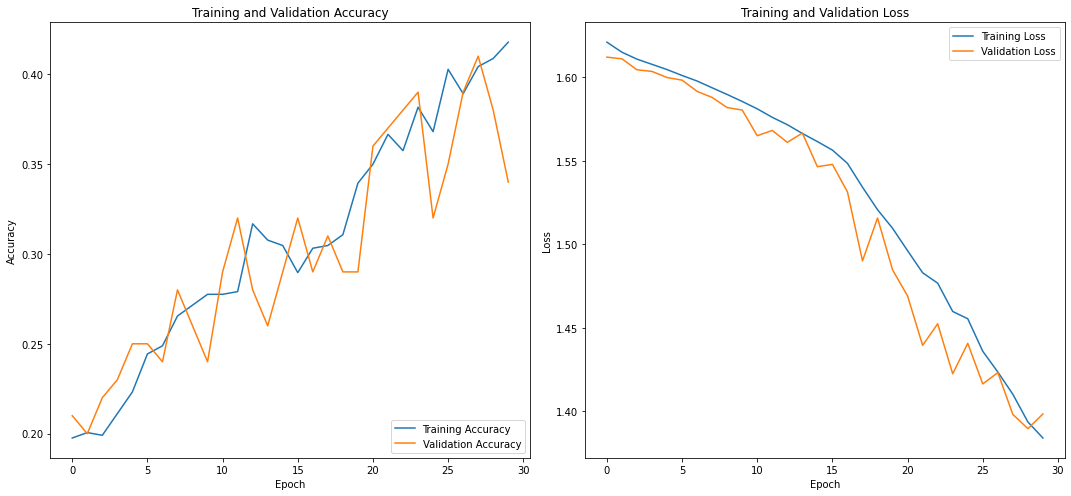

In [ ]:
plot_history(history_model3, num_epochs)

### Model No. 3 - Observations

- **Training Loss**: Decreases from 1.6210 (Epoch 1) to 1.3840 (Epoch 30).
- **Training Accuracy**: Starts at 19.76% (Epoch 1) and increases to 41.78% (Epoch 30).
- **Validation Loss**: Decreases from 1.6120 (Epoch 1) to 1.3984 (Epoch 30).
- **Validation Accuracy**: Starts at 20.06% (Epoch 1) and increases to 34.00% (Epoch 30).
- **Learning Rate**: Constant at 0.001 throughout all epochs.
- **Model Saving**: Model checkpoints were saved after each epoch with corresponding loss and accuracy values.

### Overall Summary

The model demonstrates steady improvement in both training and validation accuracy, with training accuracy reaching 41.78% by Epoch 30 and validation accuracy at 34%. Both training and validation losses show consistent decreases, but the validation accuracy lags behind the training accuracy, suggesting potential overfitting. The learning rate remained fixed at 0.001 throughout, aiding in the smooth progression of training. Further optimization might be required to bridge the gap between training and validation performance, particularly in terms of generalization.

## Creating CNN-GRU with Transfer Learning
The **CNN-GRU** architecture combines Convolutional Neural Networks (CNNs) and Gated Recurrent Units (GRUs) to process both spatial and temporal information. CNNs are used for feature extraction from images, while GRUs capture temporal dependencies in sequential data, making this architecture ideal for tasks like video classification or time-series prediction. **Transfer Learning** enhances this model by utilizing a pre-trained CNN, such as VGG16, to extract meaningful features from images without requiring extensive training from scratch. This approach leverages knowledge learned from large datasets, improving the model’s performance and reducing training time for specific tasks with limited data.

In [ ]:
def cnn_gru(x, y, z, dropout):
    """
    This function creates a CNN-GRU model with pre-trained VGG16 as the feature extractor.

    Arguments:
    x -- number of time steps in the input sequence
    y -- height of the input image
    z -- width of the input image
    dropout -- dropout rate to apply for regularization

    Returns:
    model -- the compiled CNN-GRU model
    """

    # Load the pre-trained VGG16 model (without the top classification layers)
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y, z, 3))

    # Flatten the output of the VGG16 base model
    a = base_model.output
    a = Flatten()(a)  # Flatten to convert the 2D feature maps into a 1D vector

    # Add a Dense layer for feature learning with 64 neurons and ReLU activation
    features = Dense(64, activation='relu')(a)

    # Define the convolutional model (CNN feature extractor)
    conv_model = Model(inputs=base_model.input, outputs=features)

    # Freeze the layers of the base VGG16 model so their weights are not updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Build the final sequential model with CNN-GRU architecture
    model = Sequential()

    # Apply the TimeDistributed wrapper to the convolutional model to process each time step
    model.add(TimeDistributed(conv_model, input_shape=(x, y, z, 3)))

    # Add a GRU layer with 128 units and return sequences to pass the output to the next layer
    model.add(GRU(128, return_sequences=True))

    # Add a Dropout layer to reduce overfitting (dropout rate is passed as an argument)
    model.add(Dropout(dropout))

    # Add another GRU layer with 64 units to capture temporal dependencies
    model.add(GRU(64))

    # Add another Dropout layer for regularization
    model.add(Dropout(dropout))

    # Add a Dense layer with 64 units and ReLU activation for further processing of features
    model.add(Dense(64, activation='relu'))

    # Add another Dropout layer to further prevent overfitting
    model.add(Dropout(dropout))

    # Add the final output layer with 5 units (for 5-class classification) and softmax activation
    model.add(Dense(5, activation='softmax'))

    # Return the final model
    return model

**Key Points**
1. **VGG16 as Feature Extractor**:
   - The model uses the pre-trained `VGG16` model, excluding its top classification layers (`include_top=False`). This allows the model to use `VGG16` as a feature extractor while the classification layers are custom-built.
   
2. **TimeDistributed Layer**:
   - The `TimeDistributed` wrapper allows the convolutional model to process each time step of the sequence independently. This is useful for processing sequences of images (like frames in a video).

3. **GRU Layers**:
   - The model uses two **GRU (Gated Recurrent Unit)** layers to capture temporal dependencies in the sequence of image features. The first GRU layer returns sequences to provide input for the second GRU layer, which processes the entire sequence.

4. **Dropout for Regularization**:
   - Dropout layers are added after each GRU and Dense layer to prevent overfitting by randomly setting a fraction of input units to 0 during training. The dropout rate is passed as a parameter (`dropout`).

5. **Dense Output Layer**:
   - The final Dense layer has 5 units, corresponding to a 5-class classification problem, with softmax activation to output probabilities for each class.

This model is suitable for tasks like video classification, where temporal dependencies between frames need to be captured, and spatial features from each frame need to be extracted.

### Evaluating Model No. 4
- **Model**: Model 4 - CNN-GRU with Transfer learning using VGG16 imagenet
- **Batch Size**: 32
- **Number of Epochs**: 20
- **Image Resolution**: 100x100
- **Optimizer**: Adam
- **Normalization Method**: Pixel values divided by 255 (scaling between 0 and 1)

In [ ]:
# Initialize the Adam optimizer
# Adam optimizer is a popular choice due to its adaptive learning rate and good performance on many tasks
adam = optimizers.Adam(learning_rate=0.0001)

# Create the CNN-GRU model using the cnn_gru function with input dimensions (x, y, z) and a dropout rate of 0.25
# This function combines CNN for feature extraction with GRU for sequential learning
model4 = cnn_gru(x, y, z, 0.25)

# Compile the model:
# - Use Adam optimizer for training the model
# - Specify 'categorical_crossentropy' as the loss function for multi-class classification
# - Track 'categorical_accuracy' during training to evaluate the model's performance
model4.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary to inspect the architecture, including the layers and the number of parameters
print(model4.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 18, 128)           74496     
                                                                 
 dropout_6 (Dropout)         (None, 18, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                      

In [ ]:
# Get the current date and time to create a unique filename for each checkpoint
curr_dt_time = datetime.datetime.now()

# Define the number of epochs for training
num_epochs = 20  # This is the number of times the model will iterate over the entire training dataset

# Define the batch size for training
batch_size = 32  # The number of samples processed before the model is updated during training

# Calculate the number of training and validation sequences from the training and validation documentation
num_train_sequences = len(train_doc)  # Number of sequences in the training dataset
num_val_sequences = len(val_doc)  # Number of sequences in the validation dataset

# Define the image indices used in the sequence
img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]
x = len(img_idx)  # Calculate the number of images in the sequence (length of img_idx)
y = 100  # Height of the input images
z = 100  # Width of the input images

# Calculate the number of steps per epoch for training
# Steps per epoch is the number of batches that will be processed in each epoch
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)  # If evenly divisible, use the exact number of steps
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1  # If not evenly divisible, round up to the next whole number

# Calculate the number of validation steps for the validation dataset
# Validation steps determine how many validation batches will be processed per epoch
if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)  # If evenly divisible, use the exact number of steps
else:
    validation_steps = (num_val_sequences // batch_size) + 1  # If not evenly divisible, round up to the next whole number

In [ ]:
# Call the function to create the callback directory path
# This function generates a directory path to store model checkpoints and logs
callbacks_list = callback_directory(curr_dt_time)

# Define a normalization function to scale image pixel values to the range [0, 1]
normalise = lambda a: a / 255.0  # Dividing pixel values by 255 to normalize them

# Create the training data generator using the 'generator' function
# This generator will yield batches of training data from the 'train_path' and 'train_doc'
# It takes the training data path, documentation, batch size, image dimensions, and normalization function
train_generator = generator(
    train_path,         # Path to the training dataset
    train_doc,          # Documentation for the training dataset (contains image file paths and labels)
    batch_size,         # Batch size for each training iteration
    y,                  # Height of the input images
    z,                  # Width of the input images
    normalise           # Normalization function to scale the pixel values
)

# Create the validation data generator using the 'generator' function
# This generator will yield batches of validation data from the 'val_path' and 'val_doc'
# It takes the validation data path, documentation, batch size, image dimensions, and normalization function
val_generator = generator(
    val_path,           # Path to the validation dataset
    val_doc,            # Documentation for the validation dataset (contains image file paths and labels)
    batch_size,         # Batch size for each validation iteration
    y,                  # Height of the input images
    z,                  # Width of the input images
    normalise           # Normalization function to scale the pixel values
)

In [ ]:
# Train the model using the .fit method
# 'train_generator' and 'val_generator' will provide batches of training and validation data, respectively.

history_model4 = model4.fit(
    train_generator,                # The training data generator that yields batches of training data
    steps_per_epoch=steps_per_epoch,  # Number of steps (batches) to process in each epoch for training
    epochs=num_epochs,               # Total number of epochs (iterations over the entire dataset)
    verbose=1,                       # Verbosity level; 1 will display a progress bar for each epoch
    callbacks=callbacks_list,        # List of callbacks to apply during training (e.g., checkpointing, early stopping)
    validation_data=val_generator,  # The validation data generator to evaluate the model after each epoch
    validation_steps=validation_steps,  # Number of validation batches to process in each epoch
    class_weight=None,               # Class weights (None means no weighting; you can specify weights for imbalanced classes)
    workers=1,                       # Number of workers for data loading; increase if you have a large dataset
    initial_epoch=0                  # The epoch at which to start training (use 0 to start fresh, or specify to resume from a checkpoint)
)

Source path =  /datasets/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5937 - categorical_accuracy: 0.2293Source path =  /datasets/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 1.55779, saving model to model_init_2025-01-2404_26_16.064030/model-00001-1.59367-0.22926-1.55779-0.28000.keras
21/21 [==============================] - 42s 2s/step - loss: 1.5937 - categorical_accuracy: 0.2293 - val_loss: 1.5578 - val_categorical_accuracy: 0.2800 - lr: 1.0000e-04
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.5390 - categorical_accuracy: 0.3002
Epoch 00002: val_loss improved from 1.55779 to 1.49136, saving model to model_init_2025-01-2404_26_16.064030/model-00002-1.53895-0.30015-1.49136-0.40000.keras
21/21 [==============================] - 39s 2s/step - loss: 1.5390 - categorical_accuracy: 0.3002 - val_loss: 1.4914 - va

In [ ]:
print_model_metrics("Model No. 4 - CNN-GRU with Transfer Learning", history_model4)

--------------------------------------------------
Model: Model No. 4 - CNN-GRU with Transfer Learning
--------------------------------------------------
Training Loss:  [1.5936706066131592, 1.5389518737792969, 1.4613077640533447, 1.358505368232727, 1.2730427980422974, 1.1743974685668945, 1.0847885608673096, 0.9810218214988708, 0.8934134840965271, 0.7863566875457764, 0.6806869506835938, 0.6131742000579834, 0.5158677101135254, 0.46695470809936523, 0.40718919038772583, 0.3066880702972412, 0.2849555015563965, 0.2499570995569229, 0.23762540519237518, 0.21395805478096008]
Training Categorical Accuracy:  [0.22926093637943268, 0.3001508414745331, 0.37254902720451355, 0.48868778347969055, 0.49321267008781433, 0.5610859990119934, 0.6003016829490662, 0.6561086177825928, 0.686274528503418, 0.7390648722648621, 0.7782805562019348, 0.8190045356750488, 0.8506787419319153, 0.8461538553237915, 0.8974359035491943, 0.9351432919502258, 0.9381598830223083, 0.9457013607025146, 0.9502262473106384, 0.95776772

### Visualizing Model No. 4
Visualizing the model's performance by plotting training and validation accuracy and loss over epochs. This helps assess how well the model is learning and generalizing, allowing us to identify overfitting or underfitting patterns and tune hyperparameters effectively for better performance.

Max. Training Accuracy: 0.9577677249908447
Max. Validation Accuracy: 0.8100000023841858


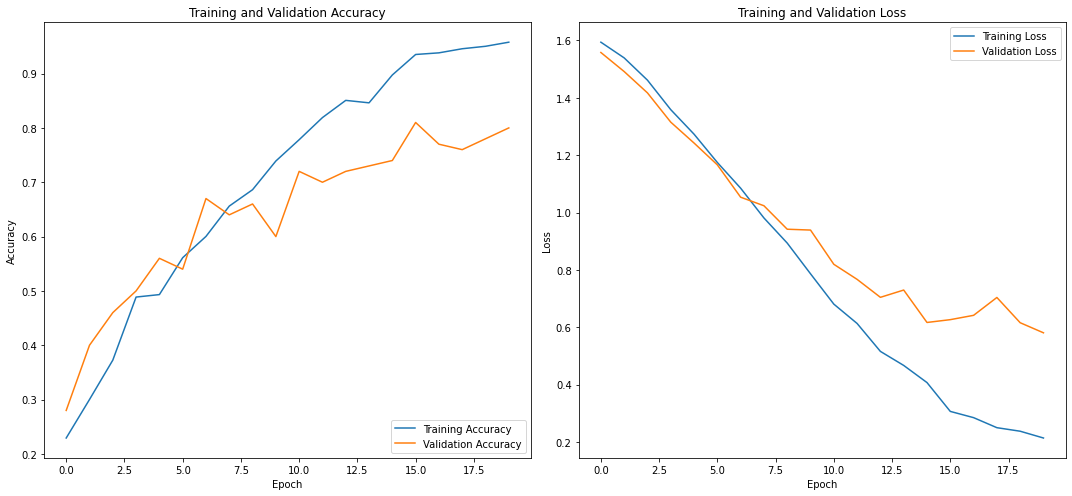

In [ ]:
plot_history(history_model4, num_epochs)

### Model No. 4 - Observations

- **Training Accuracy**: The model's training accuracy increased steadily from 22.93% to 95.78% over 20 epochs.
- **Validation Accuracy**: Validation accuracy improved from 28% to 80%.
- **Loss**: The model's loss decreased from 1.5937 to 0.2140.
- **Learning Rate**: The learning rate was reduced at Epoch 17 from 0.0001 to 0.00005 via `ReduceLROnPlateau`.
- **Model Saving**: Model checkpoints were saved after each epoch.

### Overall Summary

The model demonstrates consistent improvement in both training and validation accuracy, with a noticeable reduction in loss over the 20 epochs. The training accuracy rose from 22.93% to 95.78%, and validation accuracy increased from 28% to 80%. The learning rate was adjusted in the later epochs to enhance the model's performance, particularly at Epoch 17. Despite the validation accuracy improving steadily, there is still a gap between training and validation accuracy, suggesting that there may be some room for further improvement.

## CNN, LSTM and GRU with Transfer Learning

The model combining **CNN (Convolutional Neural Networks)**, **LSTM (Long Short-Term Memory)**, and **GRU (Gated Recurrent Units)** with **Transfer Learning** is designed to handle complex tasks involving both spatial and temporal data. **CNNs** are used for feature extraction from images, automatically learning hierarchical patterns. **LSTMs** and **GRUs**, both types of recurrent neural networks, capture temporal dependencies in sequential data, making them ideal for time-series prediction or video classification. **Transfer Learning** leverages pre-trained CNN models (like VGG16 or ResNet) on large datasets, allowing the model to benefit from previously learned features, reducing training time and improving performance, especially on smaller datasets. This architecture is particularly powerful for applications such as video processing, speech recognition, and sequence-based predictions.

In [ ]:
def cnn_lstm_gru(x, y, z, dropout):
    """
    This function builds a deep learning model combining CNN (VGG16), LSTM, and GRU layers.
    CNN is used for feature extraction from images, while LSTM and GRU capture temporal dependencies
    from sequential data. Dropout layers are added to reduce overfitting.

    Parameters:
    - x: Number of images in the sequence.
    - y: Height of the input image.
    - z: Width of the input image.
    - dropout: Dropout rate to apply for regularization in LSTM/GRU layers and Dense layers.

    Returns:
    - A compiled Keras model combining CNN, LSTM, and GRU layers.
    """

    # Load the pre-trained VGG16 model without the fully connected layers (include_top=False)
    # Weights are set to 'imagenet', which are pre-trained weights learned on ImageNet dataset.
    # The input shape is set to (y, z, 3), corresponding to height, width, and 3 color channels (RGB).
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y, z, 3))

    # Flatten the output from the base model to create a 1D vector from the image features.
    a = base_model.output
    a = Flatten()(a)

    # Add a Dense layer to extract features from the flattened image data.
    # This layer has 64 units and uses ReLU activation function.
    features = Dense(64, activation='relu')(a)

    # Create a new model for the CNN feature extraction part.
    conv_model = Model(inputs=base_model.input, outputs=features)

    # Freeze all the layers in the base VGG16 model so that they will not be updated during training.
    for layer in base_model.layers:
        layer.trainable = False

    # Start building the Sequential model which will contain CNN, LSTM, GRU, and Dense layers.
    model = Sequential()

    # Apply the conv_model to each image in the sequence using TimeDistributed wrapper.
    # This will process each image independently using the same CNN model.
    model.add(TimeDistributed(conv_model, input_shape=(x, y, z, 3)))

    # Add an LSTM layer with 128 units to capture long-term dependencies in the sequence.
    # 'return_sequences=True' ensures that the output will be passed on to the next layer in the sequence.
    model.add(LSTM(128, return_sequences=True))

    # Add a Dropout layer with the specified dropout rate to reduce overfitting.
    model.add(Dropout(dropout))

    # Add a GRU layer with 64 units to capture more temporal dependencies in the sequence.
    # 'return_sequences=True' is set to provide sequences to the next layer.
    model.add(GRU(64, return_sequences=True))

    # Add another Dropout layer to further prevent overfitting.
    model.add(Dropout(dropout))

    # Add another GRU layer with 32 units to continue capturing sequential patterns.
    # This layer outputs a 1D vector (no sequences) for the final Dense layers.
    model.add(GRU(32))

    # Add a Dense layer with 64 units and ReLU activation to further process the features.
    model.add(Dense(64, activation='relu'))

    # Add a Dropout layer for regularization.
    model.add(Dropout(dropout))

    # Add a final Dense layer with 5 units and softmax activation for classification.
    # The softmax function will output a probability distribution across 5 classes.
    model.add(Dense(5, activation='softmax'))

    # Return the built model.
    return model

**Key Points**
1. **Base Model (VGG16)**: The function uses the VGG16 model, which is a pre-trained Convolutional Neural Network (CNN) typically used for image classification tasks. We exclude the top fully connected layers and use the convolutional layers to extract features from the input images.

2. **Feature Extraction (Flatten + Dense)**: The output from the VGG16 model is flattened into a 1D vector and passed through a Dense layer with 64 units to further extract features.

3. **TimeDistributed Layer**: Since the input is a sequence of images (such as frames in a video), we use `TimeDistributed` to apply the CNN model to each image in the sequence. This ensures that each image is processed independently, but the same model weights are used for all images.

4. **LSTM and GRU Layers**: These layers are used to capture temporal dependencies in the sequential data.
   - LSTM (Long Short-Term Memory) helps capture long-range dependencies by maintaining memory over time.
   - GRU (Gated Recurrent Unit) is similar to LSTM but with fewer parameters and faster computation.

5. **Dropout**: Dropout layers are added after LSTM, GRU, and Dense layers to prevent overfitting by randomly setting some of the layer outputs to zero during training.

6. **Output Layer**: The final output layer has 5 units and uses softmax activation to perform multi-class classification. It will output a probability distribution over the 5 classes.

This model is suitable for tasks such as video classification or sequential image processing, where both spatial and temporal features need to be captured.

In [ ]:
# Import datetime library to set the current timestamp for unique filenames
import datetime

# Set the current date and time to generate a unique filename for each checkpoint
curr_dt_time = datetime.datetime.now()

# Set the number of epochs for training
num_epochs = 30  # Choose the number of epochs (iterations over the entire dataset)

# Set the batch size for training (number of samples per batch)
batch_size = 32

# Define the indices of images used in the sequence for training/validation
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
x = len(img_idx)  # Number of images in sequence (length of img_idx list)

# Define the dimensions of the input images (height and width)
y = 100  # Height of input images
z = 100  # Width of input images

# Determine the number of sequences (videos or time-steps) in the training and validation datasets
num_train_sequences = len(train_doc)  # Number of training sequences (documents or data points)
num_val_sequences = len(val_doc)  # Number of validation sequences (documents or data points)

# Calculate the number of steps per epoch for training based on the total number of training sequences
# Steps per epoch determine how many batches of data are processed before one full epoch is complete
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)  # Exact division
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1  # If not divisible, add an extra step for the remaining samples

# Similarly, calculate the number of validation steps per epoch for the validation data
if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)  # Exact division
else:
    validation_steps = (num_val_sequences // batch_size) + 1  # Add an extra step for the remaining samples


### Evaluating Model No. 5
- **Model**: Model 5 - CNN, LSTM and GRU with Transfer learning
- **Batch Size**: 32
- **Number of Epochs**: 30
- **Image Resolution**: 100x100
- **Optimizer**: Adam
- **Normalization Method**: Pixel values divided by 255 (scaling between 0 and 1)

In [ ]:
# Importing the Adam optimizer from Keras
from tensorflow.keras import optimizers

# Compile the conv3d_model
# Using Adam optimizer with a custom learning rate
adam = optimizers.Adam(learning_rate=0.0001)  # Initialize the Adam optimizer with a learning rate of 0.0001

# Create the model using the cnn_lstm_gru function
# The model architecture combines CNN for feature extraction, LSTM, and GRU for processing sequential data
# The dropout parameter (0.25) is used to reduce overfitting during training
model5 = cnn_lstm_gru(x, y, z, 0.25)  # Create the model with the specified input shape and dropout rate

# Compile the model with the following settings:
# - optimizer: Adam optimizer with a very small learning rate to fine-tune the model more carefully
# - loss function: 'categorical_crossentropy', suitable for multi-class classification tasks
# - metrics: 'categorical_accuracy', to track the accuracy for multi-class classification
model5.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary to display the architecture of the model
# This shows all the layers, their shapes, and the number of parameters in the model
print(model5.summary())  # Display the summary of the model. Note: model7_2 should likely be model5 for consistency

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 18, 128)           98816     
                                                                 
 dropout_9 (Dropout)         (None, 18, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 18, 64)            37248     
                                                                 
 dropout_10 (Dropout)        (None, 18, 64)            0         
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                      

In [ ]:
# Call the file path creating callback_directory function
# This function is responsible for creating directories for saving checkpoints and other outputs during training
callbacks_list = callback_directory(curr_dt_time)  # Get the list of callbacks, including model checkpointing or early stopping

# Let us create the train_generator and the val_generator which will be used in .fit_generator.
# These generators provide batches of training and validation data during the training process.

normalise = lambda a: a / 255.  # Define a normalization function that scales pixel values to the range [0, 1]
# This function divides each pixel value by 255 to normalize the images from [0, 255] to [0, 1]

# Create the training data generator using the generator function
# The generator will yield batches of images and corresponding labels for training
train_generator = generator(
    train_path,        # Path to the training dataset
    train_doc,         # Documentation containing information about the training data (e.g., file names, labels)
    batch_size,        # Batch size for loading data (number of samples per batch)
    y,                 # Image height (dimensions of the input images)
    z,                 # Image width (dimensions of the input images)
    normalise          # Normalization function to scale the image pixel values
)

# Create the validation data generator using the same generator function for validation data
# It works similarly to the train_generator but uses the validation data
val_generator = generator(
    val_path,          # Path to the validation dataset
    val_doc,           # Documentation containing information about the validation data
    batch_size,        # Batch size for validation data
    y,                 # Image height
    z,                 # Image width
    normalise          # Normalization function
)

**Key Points**
1. **callbacks_list**: This variable holds the list of callbacks, which are functions that are triggered during the training process. Callbacks can perform tasks like saving the model after each epoch, implementing early stopping, or logging training metrics. The `callback_directory(curr_dt_time)` function creates directories for saving checkpoints or other files based on the current date and time.

2. **normalise**: A simple lambda function that normalizes image pixel values by dividing them by 255. This ensures that the pixel values are in the range [0, 1], which is often better for training deep learning models.

3. **train_generator**: This generator loads batches of training data, applies the normalization function, and feeds them to the model during training. It is created using the `generator` function, which is expected to handle the loading, processing, and batching of data.

4. **val_generator**: Similar to `train_generator`, but this one feeds validation data to the model for evaluation during training. It helps monitor the model's performance on unseen data after each epoch.

These generators are key for efficiently feeding data to the model during training, especially for large datasets that cannot be loaded all at once.

In [ ]:
#Fit the model
history_model5 = model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 32 ;Image resolution = (100,100)
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6077 - categorical_accuracy: 0.2489Source path =  /datasets/Project_data/val ; batch size = 32 ;Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 1.59013, saving model to model_init_2025-01-2404_39_41.611445/model-00001-1.60772-0.24887-1.59013-0.32000.keras
21/21 [==============================] - 45s 2s/step - loss: 1.6077 - categorical_accuracy: 0.2489 - val_loss: 1.5901 - val_categorical_accuracy: 0.3200 - lr: 1.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5613 - categorical_accuracy: 0.3167
Epoch 00002: val_loss improved from 1.59013 to 1.53560, saving model to model_init_2025-01-2404_39_41.611445/model-00002-1.56131-0.31674-1.53560-0.43000.keras
21/21 [==============================] - 39s 2s/step - loss: 1.5613 - categorical_accuracy: 0.3167 - val_loss: 1.5356 - va

In [ ]:
print_model_metrics("Model No. 5 - CNN, LSTM and GRU with Transfer Learning", history_model5)

--------------------------------------------------
Model: Model No. 5 - CNN, LSTM and GRU with Transfer Learning
--------------------------------------------------
Training Loss:  [1.6077221632003784, 1.5613073110580444, 1.501381754875183, 1.4123592376708984, 1.3000041246414185, 1.1796125173568726, 1.036375641822815, 0.8725807666778564, 0.7605093121528625, 0.650381863117218, 0.5414271950721741, 0.4586704671382904, 0.39525046944618225, 0.33163872361183167, 0.2930872440338135, 0.2701050341129303, 0.2584846615791321, 0.24131201207637787, 0.21062031388282776, 0.20940840244293213, 0.2117304503917694, 0.20096544921398163, 0.20106200873851776, 0.19800066947937012, 0.18489915132522583, 0.19321434199810028, 0.18897005915641785, 0.1749756634235382, 0.1878606379032135, 0.1830330789089203]
Training Categorical Accuracy:  [0.24886877834796906, 0.31674209237098694, 0.3861236870288849, 0.4464555084705353, 0.541478157043457, 0.6334841847419739, 0.7043740749359131, 0.7858220338821411, 0.794871807098388

### Visualizing Model No. 5
Visualizing the model's performance by plotting training and validation accuracy and loss over epochs. This helps assess how well the model is learning and generalizing, allowing us to identify overfitting or underfitting patterns and tune hyperparameters effectively for better performance.

Max. Training Accuracy: 0.9849170446395874
Max. Validation Accuracy: 0.75


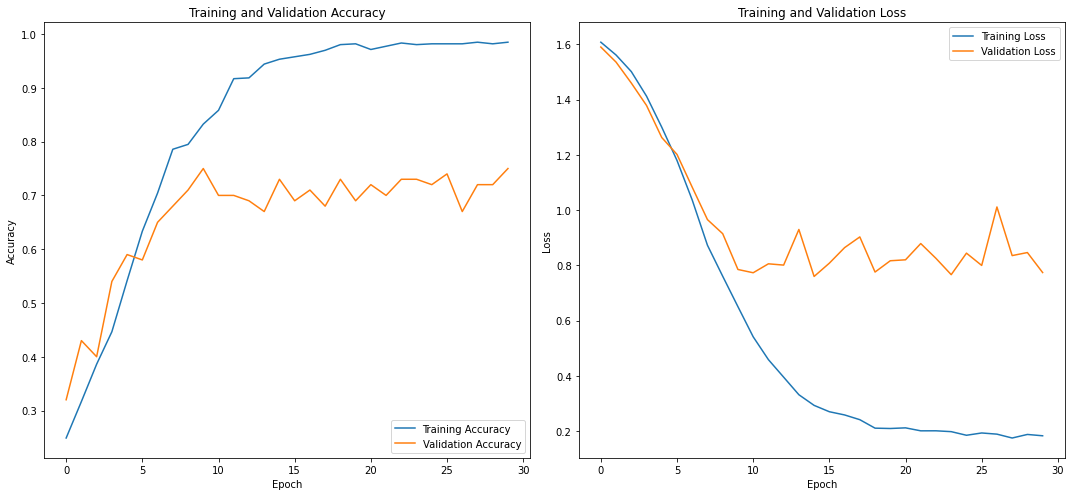

In [ ]:
plot_history(history_model5, num_epochs)

### Model No. 5 - Observations

- **Training Accuracy**: Improved significantly, reaching 98.49% by epoch 30.
- **Validation Accuracy**: Trended upward, ending at 75.00%.
- **Loss**: Training loss steadily decreased, while validation loss showed periodic improvements and fluctuations.
- **Learning Rate**: Reduced multiple times using `ReduceLROnPlateau` to optimize performance.
- **Model Saving**: Saved after each epoch, with the model showing consistent improvements in training accuracy and validation accuracy until it plateaued.

**Overall Summary**

This model demonstrated steady improvement in training accuracy, which reached 98.49% by the final epoch. The validation accuracy showed an upward trend, though with some fluctuations, and finished at 75.00%. While the validation loss showed slight improvements throughout the epochs, it also experienced some increases. The model's learning rate was adjusted using `ReduceLROnPlateau` to prevent overfitting. Despite a few plateaus, the model performed well and was saved after each epoch to capture its best states during training.

# Data Augmentation

**Enhancing Model Accuracy with Augmentation Techniques**

Data augmentation is a technique used in machine learning and deep learning to increase the diversity of training data without actually collecting new data. It involves applying various transformations to the existing dataset to create modified versions of the original data. This helps improve the robustness and generalization of models by providing them with more varied examples to learn from, reducing the risk of overfitting.

Common data augmentation methods include:
- **For image data:** Rotation, scaling, flipping, cropping, color adjustment, and adding noise.
- **For text data:** Synonym replacement, random insertion, deletion, or swapping of words, and paraphrasing.
- **For audio data:** Time stretching, pitch shifting, noise injection, and changes in speed or volume.

Data augmentation is especially beneficial when working with limited data, as it can create a broader range of training examples from the same original data.

(360, 360)


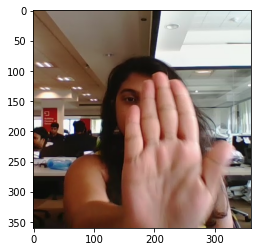

In [ ]:
# Open the image from the specified folder path
im = Image.open(folder_name + '/train/' + train_doc[9].split(';')[0] + '/' + imgs[0])

# Display the image using matplotlib
plt.imshow(im)

# Print the size (dimensions) of the image
print(im.size)

Bounding box coordinates: x0 = 0, y0 = 24, x1 = 338, y1 = 359


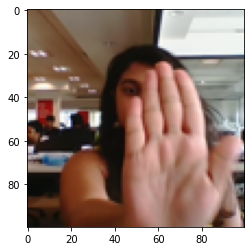

In [ ]:
# Apply a random affine transformation (shifting the image) with random horizontal and vertical shifts
shifted = im.transform(im.size, Image.AFFINE, (1, 0, np.random.randint(-30, 30), 0, 1, np.random.randint(-30, 30)))

# Convert the transformed image to grayscale
gray = shifted.convert('L')

# Convert the grayscale image to a NumPy array of type float32
image = np.asarray(gray).astype(np.float32)

# Find the minimum and maximum coordinates of non-black pixels to define the bounding box
x0, y0 = np.argwhere(image > 0).min(axis=0)
x1, y1 = np.argwhere(image > 0).max(axis=0)

# Crop the image based on the bounding box to remove any unnecessary space around the object
cropped = shifted.crop((y0, x0, y1, x1))

# Resize the cropped image to 100x100 pixels
im_resized = cropped.resize(size=(100, 100))

# Display the resized image
plt.imshow(im_resized)

# Print the coordinates of the bounding box around the non-black pixels with labels for clarity
print(f"Bounding box coordinates: x0 = {x0}, y0 = {y0}, x1 = {x1}, y1 = {y1}")

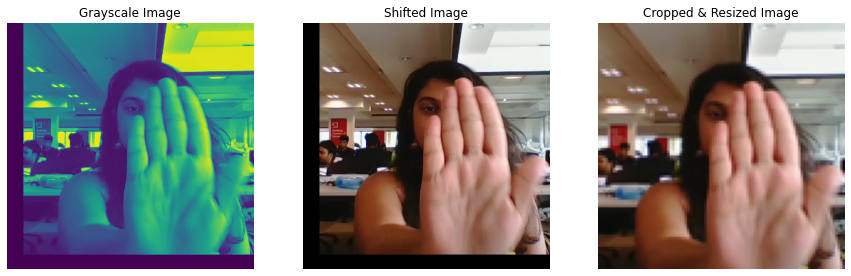

In [ ]:
# Display the three images (original grayscale, shifted image, and cropped/resized image) horizontally

# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Show the grayscale image
axes[0].imshow(gray)
axes[0].set_title('Grayscale Image')

# Show the shifted image
axes[1].imshow(shifted)
axes[1].set_title('Shifted Image')

# Show the cropped and resized image
axes[2].imshow(im_resized)
axes[2].set_title('Cropped & Resized Image')

# Hide the axes for a cleaner look
for ax in axes:
    ax.axis('off')

# Display the images
plt.show()

In [ ]:
# Image Augmentation Function
def image_augment(image, y, z):
    # Apply a random affine transformation (shifting the image) with random horizontal and vertical shifts
    shifted = image.transform(image.size, Image.AFFINE, (1, 0, np.random.randint(-30, 30), 0, 1, np.random.randint(-30, 30)))

    # Convert the transformed image to grayscale
    gray = shifted.convert('L')

    # Convert the grayscale image to a NumPy array with float32 type
    im = np.asarray(gray).astype(np.float32)

    # Find the minimum and maximum coordinates of non-black pixels to define the bounding box
    x0, y0 = np.argwhere(im > 0).min(axis=0)
    x1, y1 = np.argwhere(im > 0).max(axis=0)

    # Crop the image based on the bounding box to remove any unnecessary space around the object
    cropped = shifted.crop((y0, x0, y1, x1))

    # Resize the cropped image to the specified dimensions (y, z)
    im_resized = np.asarray(cropped.resize(size=(y, z))).astype(np.float32)

    # Return the augmented and resized image as a NumPy array
    return im_resized

## Creating Generator with Data Augmentation Techniques

**Detailed Explanation of the `generator_with_aug` Function**

The function `generator_with_aug` is a data generator used for efficiently loading and processing images in batches, with an optional augmentation process. This function is particularly useful when dealing with large datasets that cannot fit entirely into memory. It dynamically loads and preprocesses data in batches, yielding the data and corresponding labels as required by machine learning models, especially in deep learning applications.

Here’s a breakdown of the function:

---

#### **Function Definition**

```python
def generator_with_aug(source_path, folder_list, batch_size, y, z, normalise, augment=False):
```

- **`source_path`**: Path to the root directory where images are stored.
- **`folder_list`**: List of folder names, each containing images from a specific video or class.
- **`batch_size`**: The number of samples per batch.
- **`y, z`**: The target image resolution for resizing the images (height and width).
- **`normalise`**: A function for normalizing the image pixel values (e.g., rescaling them to the range [0,1]).
- **`augment`**: A boolean flag that specifies whether data augmentation should be applied (default is `False`).

---

#### **Initial Setup and Variables**

```python
img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]  # selected image indices
x = len(img_idx)  # the number of images per video
```

- **`img_idx`**: A predefined list of indices that specify which frames (images) to use from each video.
- **`x`**: The number of images (frames) to process per video, which is equal to the length of `img_idx`.

---

#### **Main Loop and Batch Processing**

The function uses an infinite loop (`while True:`) to yield batches of data continuously, making it suitable for training deep learning models with large datasets.

```python
t = np.random.permutation(folder_list)  # Randomly shuffle the folder list
num_batches = int(len(t) / batch_size)  # Calculate the number of batches
```

- **`t`**: A shuffled list of folder names to ensure randomness in batch generation.
- **`num_batches`**: The total number of full batches that can be created from the dataset, based on the specified batch size.

---

#### **Batch Creation**

For each batch, the function processes the images from the folders and creates the batch data (`batch_data`) and corresponding labels (`batch_labels`).

```python
batch_data = np.zeros((batch_size, x, y, z, 3))  # Initialize an empty array to store image data
batch_labels = np.zeros((batch_size, 5))  # Initialize an empty array for one-hot encoded labels
```

- **`batch_data`**: A 5D NumPy array to store the image data in the format `(batch_size, num_images, height, width, channels)`.
- **`batch_labels`**: A 2D array to store the one-hot encoded labels corresponding to the images.

---

#### **Image Augmentation (Optional)**

If **augmentation is enabled**, additional augmented data is created alongside the original data:

```python
if augment:
    batch_data_aug = np.zeros((batch_size, x, y, z, 3))  # Array to store augmented images
```

- **`batch_data_aug`**: A 5D NumPy array to store augmented image data.

For each image, random affine transformations (e.g., shifts, cropping) and resizing are applied:

```python
im_aug = image_augment(image, y, z)
```

- **`image_augment`**: A function that applies random transformations (such as translation, resizing, and cropping) to the image for data augmentation.

---

#### **Image Processing**

For each folder in the batch:

1. **Image Loading and Processing**:
   - The images are loaded from the specified folder.
   - The images are resized to the target resolution `(y, z)`.
   - If the image size is 160 pixels wide, the function crops the image to a 120x120 region.

2. **Normalizing**:
   - Each color channel (RGB) of the image is normalized separately using the provided `normalise` function.

3. **Augmentation**:
   - If augmentation is enabled, the augmented images are processed in the same way as the original images and stored in `batch_data_aug`.

```python
batch_data[folder, idx, :, :, 0] = normalise(image[:, :, 0])  # Normalize the red channel
batch_data[folder, idx, :, :, 1] = normalise(image[:, :, 1])  # Normalize the green channel
batch_data[folder, idx, :, :, 2] = normalise(image[:, :, 2])  # Normalize the blue channel
```

---

#### **Concatenating Augmented Data (If Applicable)**

If augmentation is enabled, the augmented data is concatenated to the original batch data:

```python
if augment:
    batch_data = np.concatenate([batch_data, batch_data_aug])
    batch_labels = np.concatenate([batch_labels, batch_labels])
```

This allows the model to train on both the original and augmented data, increasing the variety of training examples.

---

#### **Yielding Data**

Finally, the function yields the batch data and labels to be used by the training process.

```python
yield batch_data, batch_labels
```

- **`yield`**: This keyword returns the batch data and labels to the training process, allowing it to be used in the model’s training loop.

---

#### **Handling Remaining Data**

After processing the full batches, any remaining data (i.e., data that doesn't fit evenly into full batches) is handled in a similar manner.

```python
if len(t) % batch_size != 0:
    batch_data = np.zeros((len(t) % batch_size, x, y, z, 3))
    batch_labels = np.zeros((len(t) % batch_size, 5))
```

This ensures that even the remaining samples are processed in a batch, albeit potentially smaller than the specified batch size.

---

### Summary

- **`generator_with_aug`** is a generator function that processes and augments image data in batches.
- It allows for optional data augmentation (shifting, cropping, resizing).
- The function normalizes image pixel values and prepares both original and augmented data for training.
- The generator yields batches of data and labels, which can be used by machine learning models for training, especially in scenarios where the dataset is too large to fit into memory.

This method is highly useful when working with large video datasets and when real-time data augmentation is needed to improve model robustness.

In [ ]:
def generator_with_aug(source_path, folder_list, batch_size, y, z, normalise, augment=False):
    # Print details about the source path, batch size, and target image resolution
    print('Source path = ', source_path, '; batch size =', batch_size, '; Image resolution = ({},{})'.format(y, z))

    # List of image indices to be used from each video (specific frames)
    img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]
    x = len(img_idx)  # Total number of images per video

    # Infinite loop to yield batches continuously
    while True:
        # Shuffle the folder list to ensure randomness in data selection
        t = np.random.permutation(folder_list)

        # Calculate the number of batches for this set of data
        num_batches = int(len(t) / batch_size)

        # Iterate over each batch
        for batch in range(num_batches):
            # Initialize arrays to hold the data for the batch
            batch_data = np.zeros((batch_size, x, y, z, 3))  # 3 channels (RGB)
            batch_labels = np.zeros((batch_size, 5))  # One-hot encoding of labels (5 classes)

            # Initialize augmented data array if augmentation is enabled
            if augment:
                batch_data_aug = np.zeros((batch_size, x, y, z, 3))  # Array to store augmented data

            # Process each folder in the current batch
            for folder in range(batch_size):
                # List all images in the current folder
                imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])

                # Iterate over selected image indices
                for idx, item in enumerate(img_idx):
                    # Load the image from the corresponding folder
                    image = Image.open(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[item])

                    # Apply data augmentation if enabled
                    if augment:
                        im_aug = image_augment(image, y, z)

                    # Handle image cropping (if necessary) and resizing
                    if image.size[0] == 160:
                        # Crop a 120x120 region from the image
                        image = image.crop((20, 0, 140, 120))  # left=20, top=0, right=140, bottom=120

                    # Resize the image to the target resolution (y, z)
                    image = image.resize(size=(y, z))
                    image = np.asarray(image).astype(np.float32)

                    # Normalize each color channel (RGB) separately
                    batch_data[folder, idx, :, :, 0] = normalise(image[:, :, 0])  # Red channel
                    batch_data[folder, idx, :, :, 1] = normalise(image[:, :, 1])  # Green channel
                    batch_data[folder, idx, :, :, 2] = normalise(image[:, :, 2])  # Blue channel

                    # If augmentation is enabled, normalize and store augmented images as well
                    if augment:
                        batch_data_aug[folder, idx, :, :, 0] = normalise(im_aug[:, :, 0])
                        batch_data_aug[folder, idx, :, :, 1] = normalise(im_aug[:, :, 1])
                        batch_data_aug[folder, idx, :, :, 2] = normalise(im_aug[:, :, 2])

                # Set the label for the current folder (one-hot encoded label)
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

            # If augmentation is enabled, concatenate the original and augmented data
            if augment:
                batch_data = np.concatenate([batch_data, batch_data_aug])
                batch_labels = np.concatenate([batch_labels, batch_labels])

            # Yield the batch data and labels to be used by the model during training
            yield batch_data, batch_labels

        # Handle any remaining data that doesn't fit into full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((len(t) % batch_size, x, y, z, 3))
            batch_labels = np.zeros((len(t) % batch_size, 5))

            if augment:
                batch_data_aug = np.zeros((len(t) % batch_size, x, y, z, 3))  # Augmented data storage

            # Process remaining folders
            for folder in range(len(t) % batch_size):
                imgs = os.listdir(source_path + '/' + t[folder + (num_batches * batch_size)].split(';')[0])

                for idx, item in enumerate(img_idx):
                    image = Image.open(source_path + '/' + t[folder + (num_batches * batch_size)].strip().split(';')[0] + '/' + imgs[item])

                    if augment:
                        im_aug = image_augment(image, y, z)

                    # Crop and resize the image if necessary
                    if image.size[0] == 160:
                        image = image.crop((20, 0, 140, 120))

                    image = image.resize(size=(y, z))
                    image = np.asarray(image).astype(np.float32)

                    # Normalize the image channels
                    batch_data[folder, idx, :, :, 0] = normalise(image[:, :, 0])
                    batch_data[folder, idx, :, :, 1] = normalise(image[:, :, 1])
                    batch_data[folder, idx, :, :, 2] = normalise(image[:, :, 2])

                    # Normalize and store augmented data if augmentation is enabled
                    if augment:
                        batch_data_aug[folder, idx, :, :, 0] = normalise(im_aug[:, :, 0])
                        batch_data_aug[folder, idx, :, :, 1] = normalise(im_aug[:, :, 1])
                        batch_data_aug[folder, idx, :, :, 2] = normalise(im_aug[:, :, 2])

                # Set the label for the current folder
                batch_labels[folder, int(t[folder + (num_batches * batch_size)].strip().split(';')[2])] = 1

            # If augmentation is enabled, concatenate augmented data with the original data
            if augment:
                batch_data = np.concatenate([batch_data, batch_data_aug])
                batch_labels = np.concatenate([batch_labels, batch_labels])

            # Yield the final batch of remaining data
            yield batch_data, batch_labels

# Conv3D Model Architecture with Data Augmentation
The Conv3D model architecture with data augmentation is designed for analyzing volumetric data, such as videos or 3D medical scans, by leveraging three-dimensional convolutional layers. The model architecture typically consists of several 3D convolutional layers followed by activation functions like ReLU and max-pooling layers to reduce the spatial dimensions of the input data while preserving essential features. This architecture allows the model to capture spatial patterns and temporal dependencies across multiple frames in the case of video data or within a 3D volume in medical imaging tasks.

The model typically starts with a series of Conv3D layers, where each layer learns features from its input by applying convolution operations with 3D filters. After each convolutional operation, a max-pooling layer is usually applied to downsample the feature maps and extract more abstract representations. These convolutional and pooling layers are followed by dense layers to make final predictions based on the learned features.

To enhance the model's ability to generalize, data augmentation is applied. This includes random transformations such as rotations, shifts, and flips, which artificially increase the size and variability of the dataset, helping to prevent overfitting. The combined use of Conv3D layers and data augmentation helps in building robust models capable of handling complex 3D data across various domains like action recognition and medical imaging.

## Creating Conv3dArchitecture with Data Augmentation

The Conv3D architecture for this project utilizes 3D convolutional layers to process volumetric data, making it suitable for tasks such as action recognition or medical imaging. To improve model performance and generalization, data augmentation techniques such as rotation, flipping, and scaling are applied to the input data. These techniques artificially expand the training dataset, reducing the risk of overfitting and helping the model learn more robust features. The Conv3D layers capture spatial and temporal patterns in 3D data, enabling the model to learn both local and global representations effectively. This approach ensures better accuracy and model robustness during training and validation.

In [ ]:
def Conv3dArchitecture(x, y, z):
    # Initialize a Sequential model for building the Conv3D architecture
    conv3d_model = Sequential()

    # First Conv3D Layer:
    # 64 filters, kernel size of (3,3,3), 'same' padding, input shape (x, y, z, 3) for RGB images
    conv3d_model.add(Conv3D(64, (3, 3, 3), strides=(1, 1, 1), padding='same', input_shape=(x, y, z, 3)))
    conv3d_model.add(BatchNormalization())  # Apply Batch Normalization to stabilize training
    conv3d_model.add(Activation('relu'))  # Use ReLU activation function
    conv3d_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))  # Apply max pooling with stride of (2,2,2)

    # Second Conv3D Layer:
    # 128 filters, kernel size of (3,3,3), 'same' padding
    conv3d_model.add(Conv3D(128, (3, 3, 3), strides=(1, 1, 1), padding='same'))
    conv3d_model.add(BatchNormalization())  # Apply Batch Normalization
    conv3d_model.add(Activation('relu'))  # Use ReLU activation function
    conv3d_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))  # Apply max pooling with stride of (2,2,2)

    # Third Conv3D Layer:
    # 256 filters, kernel size of (3,3,3), 'same' padding
    conv3d_model.add(Conv3D(256, (3, 3, 3), strides=(1, 1, 1), padding='same'))
    conv3d_model.add(BatchNormalization())  # Apply Batch Normalization
    conv3d_model.add(Activation('relu'))  # Use ReLU activation function
    conv3d_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))  # Apply max pooling with stride of (2,2,2)

    # Fourth Conv3D Layer:
    # Another set of 256 filters with 'same' padding
    conv3d_model.add(Conv3D(256, (3, 3, 3), strides=(1, 1, 1), padding='same'))
    conv3d_model.add(BatchNormalization())  # Apply Batch Normalization
    conv3d_model.add(Activation('relu'))  # Use ReLU activation function
    conv3d_model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2)))  # Apply max pooling with stride of (2,2,2)

    # Flattening the output to connect to fully connected (dense) layers
    conv3d_model.add(Flatten())  # Flatten the 3D output to 1D

    # Dropout Layer:
    # Dropout to avoid overfitting (50% of neurons will be randomly dropped during training)
    conv3d_model.add(Dropout(0.5))

    # Fully connected layer with 512 units and ReLU activation
    conv3d_model.add(Dense(512, activation='relu'))

    # Dropout layer again to avoid overfitting
    conv3d_model.add(Dropout(0.5))

    # Final output layer with 5 units for 5 classes, using softmax activation for multi-class classification
    conv3d_model.add(Dense(5, activation='softmax'))

    # Return the constructed model
    return conv3d_model

**Summary**

This model is a 3D Convolutional Neural Network (Conv3D) designed for video or volumetric data classification. It extracts spatial features across three dimensions and classifies the input into one of five categories.

1. **Model Initialization**:
   - A `Sequential` model is created to stack layers in sequence, starting with the Conv3D layers.

2. **Conv3D Layers**:
   - Conv3D layers are added to the model sequentially, starting with 64 filters and doubling the number of filters with each subsequent layer.
   - Each Conv3D layer uses a kernel size of (3, 3, 3) and applies 'same' padding to maintain the spatial dimensions of the input.
   - Each Conv3D layer is followed by batch normalization and ReLU activation to increase the network's ability to learn complex patterns.

3. **MaxPooling3D Layers**:
   - After each Conv3D layer, a MaxPooling3D layer is applied to downsample the feature maps, reducing their spatial size by half with a pool size and stride of (2, 2, 2).

4. **Flattening**:
   - The output of the last Conv3D layer is 3D, so a `Flatten` layer is used to convert it into a 1D vector to connect to the fully connected (Dense) layers.

5. **Fully Connected (Dense) Layers**:
   - A Dense layer with 512 units and ReLU activation is used to connect the flattened output to the final output layer.
   - Dropout (50%) is applied after the fully connected layers to prevent overfitting during training.

6. **Output Layer**:
   - The final layer is a Dense layer with 5 units, corresponding to the number of classes in the classification problem. The softmax activation function is used to output probabilities for each class.

### Evaluating Model No. 6
- **Model**: Model 6 - Conv3D Archtecture with Data Augmentation
- **Batch Size**: 20
- **Number of Epochs**: 20
- **Image Resolution**: 100x100
- **Normalization Method**: Pixel values divided by 255 (scaling between 0 and 1)

In [ ]:
# Import necessary libraries for date and time operations
import datetime

# Set the current time for creating unique filenames for checkpoints
curr_dt_time = datetime.datetime.now()

# Set the number of epochs and batch size for model training
num_epochs = 20  # Number of epochs for training the model
batch_size = 20  # Batch size determines how many samples are processed before the model is updated

# Set the number of training and validation sequences in the dataset
# This assumes that `train_doc` and `val_doc` are lists containing information about the sequences
num_train_sequences = len(train_doc)  # Total number of training sequences
num_val_sequences = len(val_doc)  # Total number of validation sequences

# Define the indices of images to use in each video sequence for training
# This allows the model to select specific frames from a sequence for processing
img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]
x = len(img_idx)  # Number of images used in each sequence (based on the indices above)

# Set the desired image resolution for the input images (height and width)
y = 100  # Height of the image (100 pixels)
z = 100  # Width of the image (100 pixels)

**Compile the Conv3D Model using SGD Optimizer**
1. **SGD Optimizer**:
   - We define the SGD (Stochastic Gradient Descent) optimizer to update model weights during training.
   - The hyperparameters for the optimizer are:
     - `learning_rate`: Controls the size of the steps taken in the direction of the gradient (0.001).
     - `decay`: L2 regularization term to prevent overfitting (1e-6).
     - `momentum`: Accelerates the learning process by adding a fraction of the previous weight update (set to 0.7).
     - `nesterov`: Uses Nesterov momentum to provide a more informed update for faster convergence.

2. **Conv3D Model Initialization**:
   - The `Conv3dArchitecture(x, y, z)` function is called to create the model with the specified input dimensions: `x` (number of frames), `y` (height of the image), and `z` (width of the image).

3. **Model Compilation**:
   - The `compile()` function configures the model for training:
     - We use the `sgd` optimizer defined earlier.
     - The loss function is set to `categorical_crossentropy`, which is commonly used for multi-class classification problems.
     - The model tracks `categorical_accuracy` as the metric, meaning it will evaluate the proportion of correctly classified samples during training.

4. **Model Summary**:
   - Finally, the `summary()` function is called to display the model's architecture, including the layers, output shapes, and the number of parameters at each layer. This helps in verifying the model's structure before training.

In [ ]:
# Compile the Conv3D model
# Here we are using the SGD (Stochastic Gradient Descent) optimizer for training

# Define the SGD optimizer with specific hyperparameters:
# - learning_rate: Initial learning rate for optimization (0.001)
# - decay: The weight decay (regularization) factor to help prevent overfitting (1e-6)
# - momentum: Momentum parameter to accelerate convergence (set to 0.7)
# - nesterov: Boolean indicating whether to use Nesterov accelerated gradients (set to True for faster convergence)
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

# Initialize the Conv3D model using the previously defined architecture function
# `x`, `y`, `z` are the dimensions of the input data (number of frames, height, width)
conv3d_model6 = Conv3dArchitecture(x, y, z)

# Compile the model with:
# - `optimizer`: The optimizer chosen earlier (SGD)
# - `loss`: Categorical cross-entropy loss function (used for multi-class classification)
# - `metrics`: We are tracking categorical accuracy during training
conv3d_model6.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary to view the architecture, layer configurations, and parameters
print(conv3d_model6.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization_12 (Bat  (None, 18, 100, 100, 64)  256      
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 9, 50, 50, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 9, 50, 50, 128)    221312    
                                                                 
 batch_normalization_13 (Bat  (None, 9, 50, 50, 128)  

**Set up and train the Conv3D model with data augmentation and validation**

1. **Callbacks (`callbacks_list`)**:  
   - The `callback_directory` function is called to generate the file paths for saving model checkpoints and logs during training.

2. **Steps Per Epoch**:  
   - The `steps_per_epoch` variable calculates how many steps (or batches) will be executed in one epoch. It's based on the number of training sequences divided by the batch size.
   - If there is a remainder when dividing `num_train_sequences` by `batch_size`, we add 1 to ensure all data is used.

3. **Validation Steps**:  
   - Similarly, the `validation_steps` variable calculates how many validation steps will be executed in one epoch based on the number of validation sequences and the batch size.
   - If there is a remainder when dividing `num_val_sequences` by `batch_size`, we add 1.

4. **Normalization**:  
   - A lambda function `normalise` is defined to scale the image pixel values from the range `[0, 255]` to `[0, 1]`. This is important for neural network training, as scaled values improve convergence.

5. **Data Generators (`train_generator` and `val_generator`)**:  
   - The `train_generator` is responsible for yielding batches of augmented training data using the `generator_with_aug` function. It applies data augmentation if `augment=True`.
   - The `val_generator` is used for the validation data but without augmentation.

6. **Model Training (`fit`)**:  
   - The `fit()` method is used to train the model. It takes the following arguments:
     - `train_generator`: The training data generator.
     - `steps_per_epoch`: The number of steps (batches) to run per epoch.
     - `epochs`: The total number of epochs to train the model.
     - `verbose`: Level of output verbosity (1 means progress bars).
     - `callbacks`: List of callbacks to apply during training.
     - `validation_data`: The validation data generator.
     - `validation_steps`: The number of steps to run per epoch for validation.
     - `class_weight`: Optionally assigns weights to the classes (set to `None` here).
     - `workers`: The number of worker threads to load data in parallel.

This setup ensures the model is trained efficiently with the appropriate batch and validation steps while also applying data augmentation during training to improve generalization.

In [ ]:
# Call the function to create the file path for saving model checkpoints and callbacks
callbacks_list = callback_directory(curr_dt_time)

# Assign the number of steps per epoch for training and validation datasets
# The generator will create batch_size * 2 data for each batch (raw data + augmented data)
# However, the number of steps per epoch remains the same. The total number of samples per batch increases due to augmentation.

# Calculate steps per epoch for the training data:
# If the total number of training sequences is divisible by the batch size, we calculate steps per epoch by dividing the number of sequences by the batch size.
# Otherwise, we round up by adding 1 to ensure all data is used.
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1

# Calculate validation steps similarly to ensure all validation data is processed.
# The batch size for validation is the same as for training, but the validation steps may differ based on the number of sequences.
if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)
else:
    validation_steps = (num_val_sequences // batch_size) + 1

# Define the normalization function that scales pixel values to [0, 1] range.
normalise = lambda a: a / 255.0

# Create the train_generator and val_generator using the `generator_with_aug` function.
# These generators will provide the data in batches for training and validation, with optional augmentation for the training data.
train_generator = generator_with_aug(train_path, train_doc, batch_size, y, z, normalise, augment=True)
val_generator = generator_with_aug(val_path, val_doc, batch_size, y, z, normalise)

# Train the model using the `fit` function. This function will train the model for a number of epochs.
history_model6 = conv3d_model6.fit(
    train_generator,                 # Training data generator
    steps_per_epoch=steps_per_epoch, # Number of steps per epoch during training
    epochs=num_epochs,              # Total number of training epochs
    verbose=1,                       # Display progress during training (1 means verbose output)
    callbacks=callbacks_list,        # List of callbacks to monitor during training (e.g., saving checkpoints)
    validation_data=val_generator,  # Validation data generator
    validation_steps=validation_steps, # Number of steps per epoch during validation
    class_weight=None,              # Weights for the classes (None indicates no weighting)
    workers=1,                      # Number of workers to load data in parallel
    initial_epoch=0                 # Starting epoch (usually set to 0 for new training)
)

Source path =  /datasets/Project_data/train ; batch size = 20 ; Image resolution = (100,100)
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.5455 - categorical_accuracy: 0.3303Source path =  /datasets/Project_data/val ; batch size = 20 ; Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 1.66611, saving model to model_init_2025-01-2404_59_28.282827/model-00001-2.54548-0.33032-1.66611-0.16000.keras
34/34 [==============================] - 72s 2s/step - loss: 2.5455 - categorical_accuracy: 0.3303 - val_loss: 1.6661 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.6078 - categorical_accuracy: 0.3922
Epoch 00002: val_loss did not improve from 1.66611
34/34 [==============================] - 66s 2s/step - loss: 1.6078 - categorical_accuracy: 0.3922 - val_loss: 1.8940 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss

In [ ]:
print_model_metrics("Model No. 6 - Based on Conv3D Architecture with Data Augmentation", history_model6)

--------------------------------------------------
Model: Model No. 6 - Based on Conv3D Architecture with Data Augmentation
--------------------------------------------------
Training Loss:  [2.5454823970794678, 1.607757329940796, 1.2542173862457275, 1.2556103467941284, 1.1338939666748047, 1.1096643209457397, 1.031938076019287, 1.014549732208252, 1.0178515911102295, 0.9779820442199707, 0.990424394607544, 0.9758576154708862, 0.9616875052452087, 0.9902933835983276, 0.978133499622345, 0.9644493460655212, 0.9194369316101074, 0.9851311445236206, 0.9902579188346863, 0.9594719409942627]
Training Categorical Accuracy:  [0.3303167521953583, 0.3921568691730499, 0.500754177570343, 0.5098039507865906, 0.5460030436515808, 0.5535445213317871, 0.576168954372406, 0.5859728455543518, 0.5837104320526123, 0.5987933874130249, 0.6010558009147644, 0.6123680472373962, 0.6085972785949707, 0.6040723919868469, 0.6048265695571899, 0.5987933874130249, 0.6334841847419739, 0.5995475053787231, 0.5950226187705994, 0.

### Visualizing Model 6
Visualizing the model's performance through plots of training and validation accuracy and loss across epochs provides valuable insights into the learning process. These visualizations help evaluate how well the model is learning from the data and generalizing to unseen examples. By examining the trends, we can identify potential issues like overfitting or underfitting. Overfitting is indicated when the model performs well on training data but poorly on validation data, while underfitting is when the model fails to capture patterns in both datasets. This information allows for effective hyperparameter tuning to improve model performance and generalization.

Max. Training Accuracy: 0.6334841847419739
Max. Validation Accuracy: 0.6000000238418579


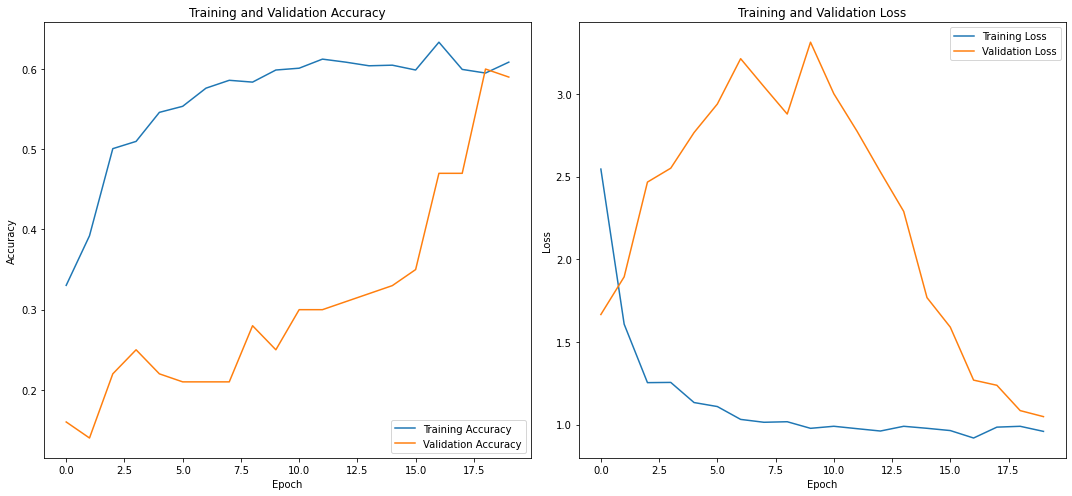

In [ ]:
plot_history(history_model6, num_epochs)

### Model No. 6 - Observations

- **Training Accuracy**: Gradually improved from 33.03% to 60.86% by epoch 20.
- **Validation Accuracy**: Increased steadily from 16.00% to 59.00%.
- **Loss**: Training loss decreased significantly, from 2.55 to 0.96 by epoch 20. Validation loss showed consistent improvement, reducing from 1.66 to 1.05.
- **Learning Rate**: Reduced progressively at various epochs using `ReduceLROnPlateau`, starting from 0.001 and decreasing to 1e-05.
- **Model Saving**: The model was saved after each epoch, with notable improvements in both training and validation accuracy and loss.

**Overall Summary - It's a Good Model**

The model exhibited steady improvement across both training and validation metrics over the course of 20 epochs. Training accuracy rose from 33.03% to 60.86%, while validation accuracy improved from 16.00% to 59.00%. Training loss decreased significantly, while validation loss also showed a continuous reduction. The learning rate was dynamically adjusted using `ReduceLROnPlateau`, further optimizing performance. The model was saved after each epoch, showcasing consistent improvements in training and validation results throughout the training process.

# CNN, LSTM and GRU with Transfer Learning and Data Augmentation

- **Convolutional Neural Networks (CNN)**:
  - Specialized for processing grid-like data, such as images or 3D volumes.
  - Uses convolutional layers to extract local features and pooling layers to reduce spatial dimensions.
  - Ideal for feature extraction from raw data, which can be further analyzed by deeper layers.

- **Long Short-Term Memory (LSTM)**:
  - A type of Recurrent Neural Network (RNN) designed to capture long-term dependencies in sequential data.
  - Effective for tasks like time-series prediction, language modeling, and action recognition.
  - LSTM units store relevant information over longer periods, mitigating vanishing gradient issues.

- **Gated Recurrent Units (GRU)**:
  - A simplified version of LSTM with fewer parameters and similar performance in many cases.
  - GRUs use gates to control the flow of information, making them efficient for sequential data tasks.
  - Often preferred for tasks where training time is critical.

- **Transfer Learning**:
  - Involves using pre-trained models on large datasets and fine-tuning them on smaller, domain-specific datasets.
  - Improves performance and reduces training time, as models have already learned relevant features from large datasets.

- **Data Augmentation**:
  - Involves applying random transformations like rotations, flips, and shifts to artificially expand the dataset.
  - Helps prevent overfitting by exposing the model to more varied input data, improving generalization.

## Creating CNN, LSTM and GRU with Transfer Learning and Data Augmentation

The model combines CNN for feature extraction, LSTM/GRU for sequential data processing, with Transfer Learning to leverage pre-trained models and fine-tune them for specific tasks. Data Augmentation is applied to enhance training by generating diverse inputs, improving generalization and model robustness, especially for tasks like time-series and image analysis.

In [ ]:
# Define CNN-LSTM-GRU model architecture with VGG16 as the base for feature extraction

def cnn_lstm_gru(x, y, z, dropout):
    # Load the pre-trained VGG16 model without the top (fully connected) layers
    # Using 'imagenet' weights, and specifying the input shape as (y, z, 3)
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(y, z, 3))

    # Flatten the output of the VGG16 base model
    a = base_model.output
    a = Flatten()(a)  # Flattening the features to a 1D vector
    features = Dense(64, activation='relu')(a)  # Adding a Dense layer with 64 units

    # Create a new model for feature extraction using the base VGG16 model
    conv_model = Model(inputs=base_model.input, outputs=features)

    # Freeze the layers of the base VGG16 model so that they are not trainable
    for layer in base_model.layers:
        layer.trainable = False

    # Define the main sequential model
    model = Sequential()

    # Add the TimeDistributed wrapper to apply the convolutional model to each time step in the input sequence
    model.add(TimeDistributed(conv_model, input_shape=(x, y, z, 3)))

    # Add an LSTM layer with 128 units, return sequences for the next layer
    model.add(LSTM(128, return_sequences=True))

    # Apply dropout to prevent overfitting
    model.add(Dropout(dropout))

    # Add a GRU layer with 64 units, again returning sequences
    model.add(GRU(64, return_sequences=True))

    # Apply another dropout layer
    model.add(Dropout(dropout))

    # Add another GRU layer with 32 units, no return sequences since it's the last recurrent layer
    model.add(GRU(32))

    # Add a Dense layer with 64 units for further feature learning
    model.add(Dense(64, activation='relu'))

    # Add a dropout layer for regularization
    model.add(Dropout(dropout))

    # Output layer with 5 units (assuming 5 classes) and softmax activation for classification
    model.add(Dense(5, activation='softmax'))

    return model

### Evaluating Model No. 7
- **Model**: Model 7 - CNN, LSTM and GRU with Transfer learning
- **Batch Size**: 32
- **Number of Epochs**: 30
- **Image Resolution**: 100x100
- **Optimizer**: Adam
- **Normalization Method**: Pixel values divided by 255 (scaling between 0 and 1)

**Note:** We will now **implement data augmentation on Model No. 5**, which has proven to be our best-performing model to date.

In [ ]:
# Set up unique checkpoint filenames based on current time
curr_dt_time = datetime.datetime.now()

# Define the number of epochs and batch size for training
num_epochs = 30  # Total number of training epochs
batch_size = 32  # Number of samples per batch

# Define the indices for the images in the sequence, selecting specific frames
img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]
x = len(img_idx)  # The total number of images to be used per video sequence
y = 100  # Image height for resizing
z = 100  # Image width for resizing

# Calculate the total number of training and validation sequences (i.e., video clips)
num_train_sequences = len(train_doc)  # Number of training sequences
num_val_sequences = len(val_doc)  # Number of validation sequences

# Calculate the number of steps per epoch for training and validation
# Steps per epoch depend on the total number of sequences divided by the batch size
# If there is a remainder, we add one additional step for the remaining samples

# Steps per epoch for training dataset
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)  # Exact division, no remainder
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1  # Add extra step for leftover samples

# Steps per epoch for validation dataset
if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)  # Exact division, no remainder
else:
    validation_steps = (num_val_sequences // batch_size) + 1  # Add extra step for leftover samples

In [ ]:
# Compile the model using the Adam optimizer
# Adam optimizer is used here with a small learning rate of 0.0001 for better convergence

# Create an Adam optimizer with a learning rate of 0.0001
adam = optimizers.Adam(learning_rate=0.0001)

# Initialize the model by calling the cnn_lstm_gru function
# Pass the image dimensions (x, y, z) and dropout rate (0.25) to the model
model7 = cnn_lstm_gru(x, y, z, 0.25)

# Compile the model with the Adam optimizer
# We use categorical cross-entropy as the loss function since it's a multi-class classification problem
# 'categorical_accuracy' is used as the metric to evaluate the accuracy of the model during training
model7.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary to get an overview of the model architecture
print(model7.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 18, 64)           15009664  
 tributed)                                                       
                                                                 
 lstm_3 (LSTM)               (None, 18, 128)           98816     
                                                                 
 dropout_14 (Dropout)        (None, 18, 128)           0         
                                                                 
 gru_4 (GRU)                 (None, 18, 64)            37248     
                                                                 
 dropout_15 (Dropout)        (None, 18, 64)            0         
                                                                 
 gru_5 (GRU)                 (None, 32)                9408      
                                                      

In [ ]:
# Call the function to create a callback directory for saving model checkpoints
# The 'callback_directory' function will create a directory based on the current date and time,
# and return a list of callback functions to be used during training
callbacks_list = callback_directory(curr_dt_time)

# Create the data generators for training and validation
# The 'train_generator' and 'val_generator' will be used in the model's .fit_generator method
# These generators will load and augment images during training and validation

# Define a normalization function to scale pixel values to the range [0, 1]
normalise = lambda a: a / 255.0

# Create the training data generator with augmentation enabled
# The 'True' flag for augmentation indicates that data augmentation (e.g., random transformations) will be applied to the training data
train_generator = generator_with_aug(train_path, train_doc, batch_size, y, z, normalise, augment=True)

# Create the validation data generator without augmentation (only resizing and normalizing the images)
val_generator = generator_with_aug(val_path, val_doc, batch_size, y, z, normalise)


In [ ]:
# Fit the model on the training data
# The model will be trained using the .fit method, with the following parameters:

history_model7 = model7.fit(
    # The training data generator that provides batches of data for training
    train_generator,

    # The number of steps per epoch, which is the number of batches of data to process in each epoch
    steps_per_epoch=steps_per_epoch,

    # The number of epochs to train the model
    epochs=num_epochs,

    # Verbosity level of the training process (1 will show progress bar)
    verbose=1,

    # List of callbacks to apply during training (e.g., saving model checkpoints, early stopping)
    callbacks=callbacks_list,

    # The validation data generator that provides batches of data for validation
    validation_data=val_generator,

    # The number of steps per validation epoch
    validation_steps=validation_steps,

    # Class weights can be provided to handle class imbalance (None means no class weights)
    class_weight=None,

    # The number of workers for data loading in parallel
    workers=1,

    # The initial epoch from which to start training (0 means start from the beginning)
    initial_epoch=0
)

Source path =  /datasets/Project_data/train ; batch size = 32 ; Image resolution = (100,100)
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.6040 - categorical_accuracy: 0.2217Source path =  /datasets/Project_data/val ; batch size = 32 ; Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 1.57590, saving model to model_init_2025-01-2405_21_34.575166/model-00001-1.60396-0.22172-1.57590-0.34000.keras
21/21 [==============================] - 76s 3s/step - loss: 1.6040 - categorical_accuracy: 0.2217 - val_loss: 1.5759 - val_categorical_accuracy: 0.3400 - lr: 1.0000e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5547 - categorical_accuracy: 0.3250
Epoch 00002: val_loss improved from 1.57590 to 1.52665, saving model to model_init_2025-01-2405_21_34.575166/model-00002-1.55472-0.32504-1.52665-0.36000.keras
21/21 [==============================] - 67s 3s/step - loss: 1.5547 - categorical_accuracy: 0.3250 - val_loss: 1.5266 - 

In [ ]:
print_model_metrics("Model No. 7 - CNN, LSTM and GRU with Transfer Learning and Data Augmentation", history_model7)

--------------------------------------------------
Model: Model No. 7 - CNN, LSTM and GRU with Transfer Learning and Data Augmentation
--------------------------------------------------
Training Loss:  [1.603957176208496, 1.5547175407409668, 1.4811793565750122, 1.362787127494812, 1.2356109619140625, 1.0857378244400024, 0.9671169519424438, 0.8382662534713745, 0.7421702146530151, 0.6664090752601624, 0.5921451449394226, 0.5407281517982483, 0.4943873882293701, 0.4687880575656891, 0.43164145946502686, 0.37139949202537537, 0.3472188413143158, 0.3319604694843292, 0.31567084789276123, 0.2981437146663666, 0.26896369457244873, 0.2637994587421417, 0.24496197700500488, 0.2387518584728241, 0.22866791486740112, 0.2328309863805771, 0.21705293655395508, 0.21406260132789612, 0.21700289845466614, 0.20533443987369537]
Training Categorical Accuracy:  [0.22171945869922638, 0.32503771781921387, 0.424585223197937, 0.4841628968715668, 0.540723979473114, 0.5972850918769836, 0.6651583909988403, 0.71493214368820

### Visualizing Model No. 7
- Visualizing model performance by plotting training and validation accuracy and loss over epochs.
- Helps evaluate how well the model learns from the data and generalizes to new data.
- Identifies potential issues like overfitting (good performance on training, poor on validation) or underfitting (poor performance on both).
- Enables effective tuning of hyperparameters to improve model performance and generalization.
- Provides valuable insights to optimize the learning process and adjust the model for better results.

Max. Training Accuracy: 0.9886877536773682
Max. Validation Accuracy: 0.7599999904632568


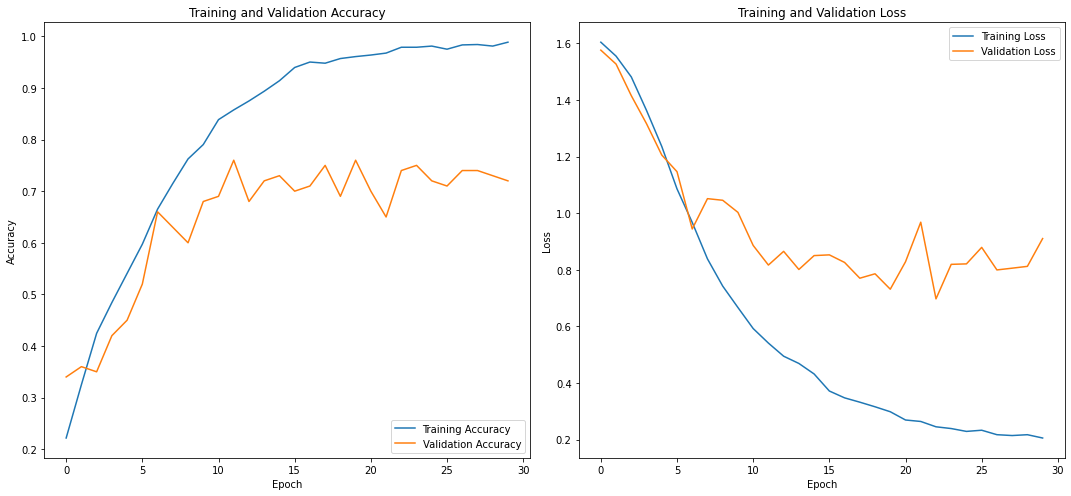

In [ ]:
plot_history(history_model7, num_epochs)

### Model No. 7 - Observations

- **Training Accuracy**: Increased consistently throughout the epochs, reaching 98.87% by epoch 30.
- **Validation Accuracy**: Showed fluctuations, peaking at 75.00% in epoch 18.
- **Loss**: Training loss steadily decreased, while validation loss showed fluctuations but improved overall during the first 20 epochs before stabilizing.
- **Learning Rate**: Reduced multiple times using the ReduceLROnPlateau callback, lowering from 0.0001 to 0.00001.
- **Model Saving**: Model was saved after every epoch with significant improvement in both training and validation accuracy.

**Overall Summary**

The model showed steady improvement in training accuracy, achieving a remarkable 98.87% by epoch 30. The validation accuracy fluctuated, with the highest point at 75.00% in epoch 18, suggesting the model might have benefited from further optimization. Training loss demonstrated consistent decrease, indicating the model was learning effectively. However, the validation loss fluctuated, particularly after the initial improvements. The learning rate was adjusted multiple times using the ReduceLROnPlateau callback, which helped maintain the model's performance over the epochs. Despite some variability in the validation accuracy, the model's overall progress in training accuracy and loss reduction indicates it was successfully adapting and learning, with checkpoints being saved regularly, reflecting significant milestones in its training process.

# Transfer Learning using MobileNet and GRU

Transfer learning is a technique that allows the reuse of a pre-trained model for a new task, significantly reducing the time and data needed for training. In the case of using MobileNet and GRU, transfer learning leverages the power of MobileNet’s pre-trained convolutional layers for feature extraction, combined with the sequential learning abilities of GRU (Gated Recurrent Unit) for time-series or sequence-based tasks.

MobileNet is a lightweight deep learning model designed for mobile and embedded devices. It is pre-trained on large-scale datasets like ImageNet, enabling it to learn rich image features. By using the pre-trained MobileNet model, the model can extract features from the input images, which significantly improves accuracy, especially when data is limited.

GRU is a type of recurrent neural network (RNN) used for handling sequential data. It works well for tasks that involve time-series data or sequences, as it captures dependencies across time steps without the vanishing gradient problem that affects traditional RNNs. When combined with MobileNet, GRU processes the sequential features extracted from images or frames, making it ideal for applications like video classification or sequential image data analysis.

This combined architecture—MobileNet for feature extraction and GRU for sequence modeling—offers a powerful, efficient solution for tasks like action recognition, video processing, and other time-dependent tasks, leveraging both transfer learning and advanced sequence modeling.

In [ ]:
# Load the MobileNet model with pre-trained weights from ImageNet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

17235968/17225924 [==============================] - 2s 0us/step


1. **MobileNet**:
   - MobileNet is a deep learning model architecture designed for efficient performance on mobile and embedded devices. It is known for its lightness and speed compared to other deep learning models, making it ideal for real-time applications.

2. **weights='imagenet'**:
   - This parameter specifies that the model should be loaded with weights pre-trained on the ImageNet dataset. ImageNet is a large visual database used for training models in object recognition tasks. Using pre-trained weights allows the model to leverage learned features, improving performance on a new task, especially when the available dataset is small.
   
3. **include_top=False**:
   - The `include_top=False` parameter tells the model to exclude the fully connected layers (the "top" layers) that are typically used for classification in ImageNet (i.e., the final dense layer that produces the 1000 ImageNet classes). This is useful when you want to use the pre-trained convolutional layers as feature extractors for a different task, without the need for ImageNet-specific classification layers.
   - By setting `include_top=False`, you retain the convolutional layers of MobileNet, which can be used to extract features from images, while allowing you to add your own custom classification or regression layers on top as needed.

**Purpose**

This line of code initializes the MobileNet model with pre-trained weights from ImageNet but excludes the final classification layers, allowing you to use MobileNet's feature extraction capabilities for your own task.

## Creating Transfer Learrning using Mobilenet and GRU Model

- **MobileNet for Feature Extraction**: Utilizes pre-trained MobileNet, which extracts high-level features from images, benefiting from training on large datasets like ImageNet.
- **Transfer Learning**: Leverages the knowledge from MobileNet’s pre-trained layers, reducing the need for extensive training data and speeding up the model training process.
- **GRU for Sequence Modeling**: Integrates GRU, a type of recurrent neural network, for handling sequential or time-series data by capturing temporal dependencies.
- **Efficient Architecture**: Combines MobileNet’s lightweight nature with GRU’s ability to model sequences, ensuring efficiency and performance.
- **Applications**: Ideal for tasks like action recognition, video classification, and other sequence-based image analysis.

In [ ]:
def cnn_gru(x, y, z, dropout):
    # Initialize a Sequential model
    model = Sequential()

    # Add a TimeDistributed wrapper around the MobileNet model for each time step in the sequence.
    # This allows the model to process sequential data (e.g., video frames or image sequences)
    # with MobileNet as the feature extractor for each frame.
    model.add(TimeDistributed(mobilenet_transfer, input_shape=(x, y, z, 3)))

    # Add TimeDistributed BatchNormalization to normalize the activations and gradients
    # during training, improving convergence speed and overall performance.
    model.add(TimeDistributed(BatchNormalization()))

    # Apply MaxPooling2D layer for down-sampling the spatial dimensions of the feature maps.
    # The pooling operation reduces the dimensionality and computational complexity.
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Flatten the 2D feature maps into a 1D vector, making it suitable for feeding into the RNN layers.
    model.add(TimeDistributed(Flatten()))

    # Add a GRU layer to capture temporal dependencies in the sequence of features.
    # GRU (Gated Recurrent Unit) is an RNN variant designed to capture sequential information
    # more effectively than vanilla RNNs while maintaining efficiency.
    model.add(GRU(128, kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization

    # Add Dropout regularization to reduce overfitting during training by randomly setting
    # a fraction of input units to zero at each update during training time.
    model.add(Dropout(dropout))

    # Add a Dense layer with ReLU activation for learning high-level feature representations
    # before the output layer.
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization

    # Add Dropout again to prevent overfitting and improve model generalization.
    model.add(Dropout(dropout))

    # Final Dense layer with softmax activation for multi-class classification.
    # This produces a probability distribution over 5 output classes.
    model.add(Dense(5, activation='softmax'))

    # Return the constructed model
    return model

1. **TimeDistributed Wrapper**:
   - The `TimeDistributed` layer applies a given layer (e.g., MobileNet) independently to each time step of the input sequence. This is useful when working with sequential data, such as videos or image sequences, where each frame is treated individually but shares the same model structure.

2. **MobileNet**:
   - `mobilenet_transfer` is used as a feature extractor for each time step. It's a pre-trained MobileNet model without the final classification layers, and it's applied to each frame in the input sequence.

3. **BatchNormalization**:
   - Normalizes the output of the previous layer by scaling and shifting, which helps speed up training and improves the model's generalization.

4. **MaxPooling2D**:
   - Reduces the spatial dimensions (height and width) of the feature maps, which decreases computational complexity and helps extract dominant features.

5. **Flatten**:
   - Converts the 2D feature maps from the previous layers into a 1D vector, preparing the data for the next layer, which is a recurrent layer.

6. **GRU Layer**:
   - The Gated Recurrent Unit (GRU) layer is used to capture temporal dependencies from the sequence of extracted features. GRUs are a type of Recurrent Neural Network (RNN) that helps the model remember important information from previous time steps while avoiding the vanishing gradient problem.

7. **Dense Layer**:
   - The Dense layers with ReLU activation learn high-level features, followed by a softmax output layer that provides class probabilities.

8. **Dropout**:
   - Dropout is a regularization technique that helps prevent overfitting by randomly dropping a fraction of the input units during training.

9. **Final Output Layer (Softmax)**:
   - The softmax activation function in the output layer is used for multi-class classification, providing a probability distribution over the 5 possible classes.

**Purpose**

This model is designed for sequential input data, such as video frames or time-series images, where MobileNet serves as the feature extractor for each frame, and the GRU layer captures temporal dependencies across the sequence of frames. It is a combination of a convolutional neural network (CNN) for feature extraction and a recurrent neural network (RNN) for modeling sequences. The output is a classification into 5 possible classes.

### Evaluating Model No. 8
- **Model**: Model 8 - Transfer Learrning using Mobilenet and GRU
- **Batch Size**: 16
- **Number of Epochs**: 30
- **Image Resolution**: 100x100
- **Optimizer**: Adam
- **Normalization Method**: Pixel values divided by 255 (scaling between 0 and 1)

In [ ]:
# Set the current date and time to create unique filenames for checkpoints
curr_dt_time = datetime.datetime.now()

# Define the number of epochs for training
num_epochs = 30  # Set the number of epochs to train the model

# Define batch size
batch_size = 16  # Set the batch size to 16

# Define the list of indices for the images in the sequence to be used for each video frame
img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]
x = len(img_idx)  # The number of images to use per video sequence

# Define image resolution
y = 100  # Height of the image after resizing
z = 100  # Width of the image after resizing

# Set paths for the training and validation datasets
train_path = '/datasets/Project_data/train'  # Path to the training dataset
val_path = '/datasets/Project_data/val'  # Path to the validation dataset

# Get the total number of training and validation sequences
num_train_sequences = len(train_doc)  # Total number of training sequences
num_val_sequences = len(val_doc)  # Total number of validation sequences

# Calculate the number of steps per epoch for training (how many batches are processed per epoch)
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)  # If evenly divisible, divide total sequences by batch size
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1  # If not evenly divisible, round up to the next integer

# Calculate the number of validation steps (how many validation batches are processed per epoch)
if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)  # If evenly divisible, divide total validation sequences by batch size
else:
    validation_steps = (num_val_sequences // batch_size) + 1  # If not evenly divisible, round up to the next integer

1. **`curr_dt_time = datetime.datetime.now()`**:
   - This line captures the current date and time, which will be used to generate unique filenames for saving checkpoints during training.

2. **`num_epochs = 20`**:
   - Sets the number of training epochs, which defines how many times the model will iterate over the entire dataset during training.

3. **`batch_size = 16`**:
   - Defines the batch size, which determines how many samples are processed before the model's internal parameters are updated.

4. **`img_idx = [...]`**:
   - A list of indices representing the specific images that will be used from each sequence. This allows you to select a subset of frames from each video sequence to train on.

5. **`x = len(img_idx)`**:
   - Calculates the number of images (or frames) per video sequence by counting the length of `img_idx`. This is used to shape the input data for the model.

6. **`y = 100, z = 100`**:
   - These variables define the desired height and width for the input images, which are resized during preprocessing to ensure all input images have consistent dimensions.

7. **`train_path = '/datasets/Project_data/train'` and `val_path = '/datasets/Project_data/val'`**:
   - These variables specify the paths to the directories containing the training and validation datasets, respectively.

8. **`num_train_sequences = len(train_doc)`** and **`num_val_sequences = len(val_doc)`**:
   - These lines determine the total number of training and validation sequences by checking the length of `train_doc` and `val_doc`, which are assumed to be lists of video sequence filenames or metadata.

9. **`steps_per_epoch` and `validation_steps`**:
   - These variables determine how many steps (batches) the model will process per epoch for training and validation, respectively.
   - The calculation ensures that the number of steps accounts for both complete and incomplete batches (when the number of sequences isn't perfectly divisible by the batch size).

   - If the total number of sequences is divisible by the batch size, the number of steps per epoch is simply the total sequences divided by the batch size. If not, the calculation rounds up to ensure that all data is used in the epoch.

In [ ]:
# Compile the cnn_gru model using the Adam optimizer

# Set up the Adam optimizer with a learning rate of 0.0001
adam = optimizers.Adam(learning_rate=0.0001)

# Initialize the cnn_gru model with the input shape (x, y, z) and dropout rate of 0.25
model8 = cnn_gru(x, y, z, 0.25)

# Compile the model by specifying the optimizer, loss function, and metrics to monitor
# We use 'categorical_crossentropy' as the loss function since this is a multi-class classification task
# 'categorical_accuracy' will be tracked as a metric during training
model8.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary to view the architecture of the model
print(model8.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 18, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 18, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 18, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 18, 1024)         0         
 tributed)                                                       
                                                                 
 gru_6 (GRU)                 (None, 128)              

1. **`adam = optimizers.Adam(learning_rate=0.0001)`**:
   - This line initializes the Adam optimizer with a learning rate of 0.0001. Adam is a popular optimization algorithm that adapts the learning rate during training, making it well-suited for complex models.

2. **`model10 = cnn_gru(x, y, z, 0.25)`**:
   - This initializes the model by calling the `cnn_gru` function with the input shape `(x, y, z)` (where `x` is the number of frames per sequence, `y` is the height, and `z` is the width of the images), and a dropout rate of `0.25`. The model architecture combines Convolutional Neural Networks (CNN) with GRU (Gated Recurrent Units) layers for temporal sequence processing.

3. **`model10.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])`**:
   - The model is compiled with:
     - The Adam optimizer (as defined earlier).
     - `categorical_crossentropy` as the loss function, which is appropriate for multi-class classification problems where the labels are one-hot encoded.
     - `categorical_accuracy` as a metric to evaluate the model's accuracy during training and validation.

4. **`print(model10.summary())`**:
   - This prints a summary of the model architecture, providing details about the layers, number of parameters, and input/output shapes. This is helpful for verifying the model configuration before training.

In [ ]:
# Call the file path creating callback_directory function
# This function sets up the directory for saving model checkpoints, logs, and other outputs
# It ensures that we can track the training progress and resume from checkpoints if needed
callbacks_list = callback_directory(curr_dt_time)

# Create the train_generator and val_generator which will be used in .fit_generator
# These generators will yield batches of images and their corresponding labels for training and validation
# The train_generator includes data augmentation to enhance the training process

# Normalization function to scale pixel values to the range [0, 1]
normalise = lambda a: a/255.

# Create the training data generator
# This generator reads images and labels from the training dataset located at 'train_path' using 'train_doc'
# It applies data augmentation (True) to the images and normalizes the pixel values
train_generator = generator_with_aug(train_path, train_doc, batch_size, y, z, normalise, augment=True)

# Create the validation data generator
# This generator reads images and labels from the validation dataset located at 'val_path' using 'val_doc'
# It normalizes the pixel values but does not apply augmentation since we do not want to augment validation data
val_generator = generator_with_aug(val_path, val_doc, batch_size, y, z, normalise, augment=False)

1. **`callbacks_list = callback_directory(curr_dt_time)`**:
   - This line calls the `callback_directory` function with the current datetime (`curr_dt_time`) to create directories for saving checkpoints, logs, and other related files during training. This ensures that you can track progress, log metrics, and resume training from a checkpoint if needed.

2. **`normalise = lambda a: a/255.`**:
   - This line defines a lambda function to normalize image pixel values. The pixel values of images typically range from 0 to 255. The lambda function divides each pixel value by 255, scaling it to a range of [0, 1], which is often done to improve model performance and stability.

3. **`train_generator = generator_with_aug(...)`**:
   - This creates a training data generator (`train_generator`) using the `generator_with_aug` function.
   - It reads the data from `train_path`, which is the path to the training data, and `train_doc`, which contains the file names and corresponding labels.
   - The generator will yield batches of images and labels for training. Data augmentation is applied (`augment=True`) to artificially expand the training dataset and make the model more robust.

4. **`val_generator = generator_with_aug(...)`**:
   - This creates a validation data generator (`val_generator`) using the same `generator_with_aug` function.
   - It reads the data from `val_path` (the validation data path) and `val_doc` (the corresponding labels).
   - The generator yields batches of validation images and labels, but without any data augmentation (`augment=False`) since we want the validation set to represent real data distribution. The images are only normalized (scaled to [0, 1]).

**Next Stage - Train the model using the training and validation generators with specified parameters and callbacks**

1. **`train_generator`**: This is the data generator that produces batches of images and labels for training. It is passed as the first argument to `model10.fit()`. The generator will yield data during training, with the model using this data to learn.

2. **`steps_per_epoch=steps_per_epoch`**: This parameter defines how many steps (batches) are processed in each epoch. It is calculated based on the size of the training dataset and the batch size. After completing all the steps in an epoch, the model will evaluate the performance on the validation set.

3. **`epochs=num_epochs`**: This specifies the total number of times the entire training dataset will be used to train the model. In this case, the model will be trained for `num_epochs` epochs.

4. **`verbose=1`**: This argument controls the verbosity level. `1` means progress will be shown with a progress bar during training, including metrics for each epoch. You can set it to `0` for no output, or `2` for one line per epoch.

5. **`callbacks=callbacks_list`**: This is a list of callbacks to be applied during training, such as saving model checkpoints, learning rate adjustments, or early stopping. These callbacks allow for more advanced handling of the training process.

6. **`validation_data=val_generator`**: This argument provides the validation data for the model. The validation data is used to evaluate the model's performance at the end of each epoch. `val_generator` is a generator that yields validation data.

7. **`validation_steps=validation_steps`**: This defines how many steps (batches) the model should process from the validation data before performing the evaluation. It ensures that the model evaluates the correct number of validation batches after each epoch.

8. **`class_weight=None`**: If you have imbalanced classes in your dataset, you can use this parameter to assign different weights to different classes during training. In this case, `None` means no class weighting is applied.

9. **`workers=1`**: This parameter controls the number of parallel workers used for data loading. Setting it to `1` means a single thread will handle data loading. More workers can be used to speed up data loading for large datasets.

10. **`initial_epoch=0`**: This argument allows you to specify the starting epoch when resuming training. If you are continuing from a saved checkpoint, you would use the epoch number where the training was stopped. Here it is set to `0`, indicating that training will start from the beginning.

In [ ]:
# Fit the model
# This line trains the model using the training data generated by 'train_generator' and evaluates it using the validation data from 'val_generator'.
# The model will run for a specified number of epochs, and after each epoch, the performance will be evaluated on the validation dataset.

history_model8 = model8.fit(
    train_generator,                         # The generator that yields training batches of data (images and labels)
    steps_per_epoch=steps_per_epoch,         # The number of steps (batches) per epoch, calculated based on the training dataset size and batch size
    epochs=num_epochs,                       # The total number of epochs (iterations over the entire dataset) for training
    verbose=1,                               # Display progress during training (1 means displaying a progress bar and metrics)
    callbacks=callbacks_list,                # List of callbacks to be applied during training (e.g., saving checkpoints, early stopping, etc.)
    validation_data=val_generator,           # The validation data generator that yields validation batches of data
    validation_steps=validation_steps,       # The number of steps (batches) to run on the validation data per epoch
    class_weight=None,                       # Class weights for handling imbalanced datasets (None means no class weighting is applied)
    workers=1,                               # The number of workers for loading the data in parallel (1 means single-threaded data loading)
    initial_epoch=0                          # The starting epoch, useful for resuming training from a specific epoch
)

Source path =  /datasets/Project_data/train ; batch size = 16 ; Image resolution = (100,100)
Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 8.2872 - categorical_accuracy: 0.3024Source path =  /datasets/Project_data/val ; batch size = 16 ; Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 7.87368, saving model to model_init_2025-01-2405_54_58.642901/model-00001-8.28718-0.30241-7.87368-0.41000.keras
42/42 [==============================] - 73s 2s/step - loss: 8.2872 - categorical_accuracy: 0.3024 - val_loss: 7.8737 - val_categorical_accuracy: 0.4100 - lr: 1.0000e-04
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 7.3622 - categorical_accuracy: 0.5980
Epoch 00002: val_loss improved from 7.87368 to 7.12672, saving model to model_init_2025-01-2405_54_58.642901/model-00002-7.36216-0.59804-7.12672-0.68000.keras
42/42 [==============================] - 68s 2s/step - loss: 7.3622 - categorical_accuracy: 0.5980 - val_loss: 7.1267 - 

In [ ]:
print_model_metrics("Model No. 8 - Transfer Learrning using Mobilenet and GRU Model", history_model8)

--------------------------------------------------
Model: Model No. 8 - Transfer Learrning using Mobilenet and GRU Model
--------------------------------------------------
Training Loss:  [8.287181854248047, 7.3621602058410645, 6.703664779663086, 6.146740913391113, 5.740432262420654, 5.3416852951049805, 5.031792640686035, 4.710546970367432, 4.476136684417725, 4.209046363830566, 4.011067867279053, 3.7855148315429688, 3.598259449005127, 3.411811113357544, 3.231487989425659, 3.074718952178955, 2.9283225536346436, 2.774517774581909, 2.6402688026428223, 2.504119396209717, 2.3798813819885254, 2.257385730743408, 2.14630126953125, 2.0318119525909424, 1.9284052848815918, 1.8316324949264526, 1.7361012697219849, 1.6424258947372437, 1.5565794706344604, 1.4711445569992065]
Training Categorical Accuracy:  [0.30241328477859497, 0.5980392098426819, 0.7586727142333984, 0.8604826331138611, 0.8929110169410706, 0.9343891143798828, 0.9426847696304321, 0.9781296849250793, 0.9660633206367493, 0.9864253401756

### Visualizing Model No. 8
- Plots training and validation accuracy/loss to visualize model performance.
- Helps assess learning and generalization to new data.
- Identifies overfitting or underfitting issues.
- Aids in tuning hyperparameters for better performance.
- Offers insights to optimize learning and adjust the model.

Max. Training Accuracy: 1.0
Max. Validation Accuracy: 0.949999988079071


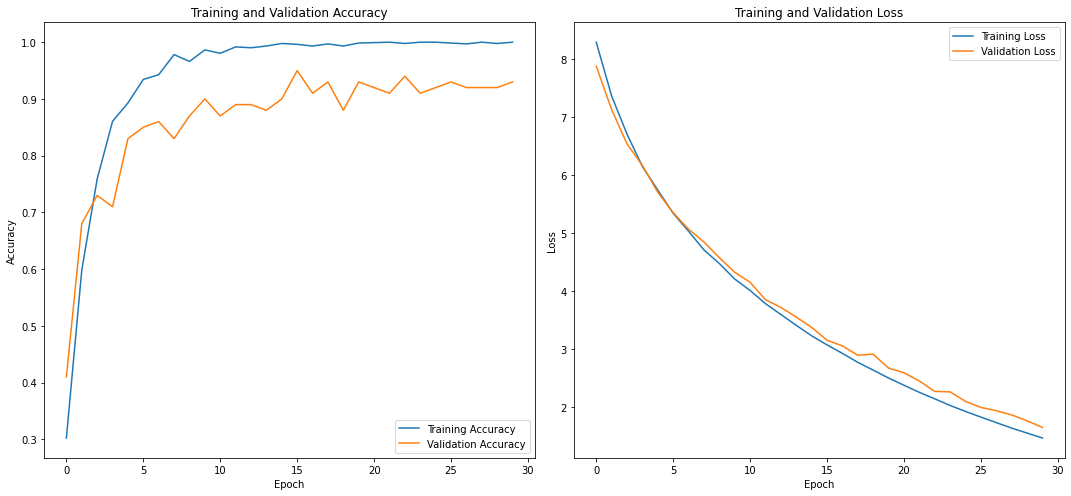

In [ ]:
plot_history(history_model8, num_epochs)

### Model No. 8 - Observations

- **Training Accuracy**: Increased steadily, reaching 99.92% by epoch 30.
- **Validation Accuracy**: Fluctuated, peaking at 95.00% by epoch 16, then hovering around 92.00% toward the final epochs.
- **Loss**: Training loss consistently decreased, with validation loss showing steady improvement, especially after epoch 15.
- **Learning Rate**: Initially set at 1e-4, remained constant throughout the epochs without further reduction, indicating steady learning.
- **Model Saving**: The model was saved after each epoch, with notable progress, especially in the reduction of validation loss.

**Overall Summary**

Across the 30 epochs, the model demonstrated continual improvements in both training and validation accuracy. Training accuracy progressed steadily, reaching an impressive 100% by epoch 30, while validation accuracy fluctuated, peaking at 95% before stabilizing at 92% by the end of the training. Training loss steadily decreased, and validation loss followed a similar pattern, especially after epoch 15, with the most notable improvement seen after epoch 28. The learning rate remained constant at 1e-4 throughout the training, without further adjustments, ensuring the model continued refining its predictions. Model checkpoints were saved after each epoch, capturing incremental improvements in performance. Despite fluctuations in validation accuracy, the model showed strong generalization and consistent progress.

# ConvLSTM Model for Sequence-based Image Processing

The **ConvLSTM model** is designed for sequence-based image processing, particularly for tasks involving video or time-series image data. It combines convolutional layers (Conv2D) and Long Short-Term Memory (LSTM) units within a single architecture. The **Conv2D** layers extract spatial features from each frame, while the **ConvLSTM2D** layer captures both spatial and temporal dependencies across frames. The **TimeDistributed** wrapper applies layers like Conv2D and Dense across each time step independently, making it suitable for video classification, action recognition, or next-frame prediction. The model is effective for learning from sequences of images, handling both spatial and temporal information.

## Creating ConvLSTM Model with Data Augmentation

This model is called a **ConvLSTM model** (Convolutional Long Short-Term Memory). It combines convolutional layers and LSTM layers to process sequences of images or video frames. Here's a breakdown of what the model is doing:

1. **TimeDistributed Wrapper**: This wrapper allows the model to apply a 2D convolution (`Conv2D`) across each frame in the sequence independently. This is crucial for processing sequences of images, such as video frames.

2. **Conv2D Layers**: These layers apply 2D convolutions to the individual frames of the sequence, helping the model capture spatial features in each frame.

3. **ConvLSTM2D Layer**: The key feature of this model is the ConvLSTM2D layer. It is a combination of convolutional operations with LSTM units, which allows the model to capture both spatial (from Conv2D) and temporal (from LSTM) dependencies across frames in a video or sequence of images.

4. **BatchNormalization**: This layer normalizes the activations to stabilize training, helping the model learn faster and potentially generalize better.

5. **TimeDistributed Dense Layer**: This layer applies a fully connected (dense) layer to each time step (frame) in the sequence, treating each frame independently.

6. **GlobalAveragePooling2D**: This layer reduces the spatial dimensions (height and width) by computing the average of the entire spatial feature map, helping reduce the number of parameters and avoiding overfitting.

7. **Dense Layer**: The final fully connected layer performs classification with 5 output classes, using softmax activation for multi-class classification.

In [ ]:
def convLSTM_model(x, y, z):
    """
    Build a model using Conv2D, ConvLSTM2D, and TimeDistributed layers for sequence-based image processing.

    Parameters:
    - x: int, number of frames in the sequence
    - y: int, height of the input image
    - z: int, width of the input image

    Returns:
    - model: Keras Sequential model
    """
    # Initialize the model
    model = Sequential()

    # Add a TimeDistributed wrapper with Conv2D for 2D convolution over each frame of the sequence
    model.add(TimeDistributed(
        Conv2D(8, (3, 3), activation='relu'), input_shape=(x, y, z, 3)))  # 3 channels (RGB)
    model.add(BatchNormalization())  # Normalize the output to stabilize training

    # Add another TimeDistributed Conv2D layer with 16 filters
    model.add(TimeDistributed(
        Conv2D(16, (3, 3), activation='relu')))
    model.add(BatchNormalization())  # Apply BatchNormalization

    # Add ConvLSTM2D layer to capture temporal dependencies across frames
    model.add(ConvLSTM2D(8, kernel_size=(3, 3), return_sequences=False))
    model.add(BatchNormalization())  # Normalize the output of ConvLSTM2D

    # Add TimeDistributed Dense layer to apply a fully connected layer across all time steps
    model.add(TimeDistributed(
        Dense(64, activation='relu')))
    model.add(BatchNormalization())  # Normalize output

    # Apply Global Average Pooling to reduce spatial dimensions (height and width)
    model.add(GlobalAveragePooling2D())

    # Add a fully connected Dense layer with 64 units for further processing
    model.add(Dense(64, activation='relu'))

    # Output layer for classification with 5 classes, using softmax for multi-class classification
    model.add(Dense(5, activation='softmax'))

    return model

### Evaluating Model No. 9
- **Model**: Model 9 - Transfer Learrning using Mobilenet and GRU
- **Batch Size**: 32
- **Number of Epochs**: 30
- **Image Resolution**: 100x100
- **Optimizer**: Adam
- **Normalization Method**: Pixel values divided by 255 (scaling between 0 and 1)

In [ ]:
# Set the current date and time to create unique filenames for checkpoints
curr_dt_time = datetime.datetime.now()

# Define the number of epochs for training
num_epochs = 30  # Set the number of epochs to train the model

# Define batch size
batch_size = 32  # Set the batch size to 16

# Define the list of indices for the images in the sequence to be used for each video frame
img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]
x = len(img_idx)  # The number of images to use per video sequence

# Define image resolution
y = 100  # Height of the image after resizing
z = 100  # Width of the image after resizing

# Set paths for the training and validation datasets
train_path = '/datasets/Project_data/train'  # Path to the training dataset
val_path = '/datasets/Project_data/val'  # Path to the validation dataset

# Get the total number of training and validation sequences
num_train_sequences = len(train_doc)  # Total number of training sequences
num_val_sequences = len(val_doc)  # Total number of validation sequences

# Calculate the number of steps per epoch for training (how many batches are processed per epoch)
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)  # If evenly divisible, divide total sequences by batch size
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1  # If not evenly divisible, round up to the next integer

# Calculate the number of validation steps (how many validation batches are processed per epoch)
if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)  # If evenly divisible, divide total validation sequences by batch size
else:
    validation_steps = (num_val_sequences // batch_size) + 1  # If not evenly divisible, round up to the next integer

In [ ]:
# === Chuẩn hoá train_path / val_path động thay vì hard-code ===
train_path = os.path.join(folder_name, 'train')
val_path   = os.path.join(folder_name, 'val')
print('[INFO] train_path =', train_path)
print('[INFO] val_path   =', val_path)

In [ ]:
from tensorflow.keras import optimizers

# Define the Adam optimizer with a learning rate of 0.01
optimizer = optimizers.Adam(learning_rate=0.01)

model9 = convLSTM_model(x, y, z)

# Compile the model with categorical crossentropy loss and categorical accuracy metric
model9.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model9.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDis  (None, 18, 98, 98, 8)    224       
 tributed)                                                       
                                                                 
 batch_normalization_17 (Bat  (None, 18, 98, 98, 8)    32        
 chNormalization)                                                
                                                                 
 time_distributed_9 (TimeDis  (None, 18, 96, 96, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_18 (Bat  (None, 18, 96, 96, 16)   64        
 chNormalization)                                                
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 94, 94, 8)        

In [ ]:
# Call the file path creating callback_directory function
# This function sets up the directory for saving model checkpoints, logs, and other outputs
# It ensures that we can track the training progress and resume from checkpoints if needed
callbacks_list = callback_directory(curr_dt_time)

# Create the train_generator and val_generator which will be used in .fit_generator
# These generators will yield batches of images and their corresponding labels for training and validation
# The train_generator includes data augmentation to enhance the training process

# Normalization function to scale pixel values to the range [0, 1]
normalise = lambda a: a/255.

# Create the training data generator
# This generator reads images and labels from the training dataset located at 'train_path' using 'train_doc'
# It applies data augmentation (True) to the images and normalizes the pixel values
train_generator = generator_with_aug(train_path, train_doc, batch_size, y, z, normalise, augment=True)

# Create the validation data generator
# This generator reads images and labels from the validation dataset located at 'val_path' using 'val_doc'
# It normalizes the pixel values but does not apply augmentation since we do not want to augment validation data
val_generator = generator_with_aug(val_path, val_doc, batch_size, y, z, normalise, augment=False)

In [ ]:
# Fit the model
# This line trains the model using the training data generated by 'train_generator' and evaluates it using the validation data from 'val_generator'.
# The model will run for a specified number of epochs, and after each epoch, the performance will be evaluated on the validation dataset.

history_model9 = model9.fit(
    train_generator,                         # The generator that yields training batches of data (images and labels)
    steps_per_epoch=steps_per_epoch,         # The number of steps (batches) per epoch, calculated based on the training dataset size and batch size
    epochs=num_epochs,                       # The total number of epochs (iterations over the entire dataset) for training
    verbose=1,                               # Display progress during training (1 means displaying a progress bar and metrics)
    callbacks=callbacks_list,                # List of callbacks to be applied during training (e.g., saving checkpoints, early stopping, etc.)
    validation_data=val_generator,           # The validation data generator that yields validation batches of data
    validation_steps=validation_steps,       # The number of steps (batches) to run on the validation data per epoch
    class_weight=None,                       # Class weights for handling imbalanced datasets (None means no class weighting is applied)
    workers=1,                               # The number of workers for loading the data in parallel (1 means single-threaded data loading)
    initial_epoch=0                          # The starting epoch, useful for resuming training from a specific epoch
)

Source path =  /datasets/Project_data/train ; batch size = 32 ; Image resolution = (100,100)
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.3823 - categorical_accuracy: 0.3816Source path =  /datasets/Project_data/val ; batch size = 32 ; Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 1.65227, saving model to model_init_2025-01-2406_28_38.837596/model-00001-1.38225-0.38160-1.65227-0.22000.keras
21/21 [==============================] - 70s 3s/step - loss: 1.3823 - categorical_accuracy: 0.3816 - val_loss: 1.6523 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.2131 - categorical_accuracy: 0.4374
Epoch 00002: val_loss improved from 1.65227 to 1.63051, saving model to model_init_2025-01-2406_28_38.837596/model-00002-1.21312-0.43741-1.63051-0.26000.keras
21/21 [==============================] - 67s 3s/step - loss: 1.2131 - categorical_accuracy: 0.4374 - val_loss: 1.6305 - val_

In [ ]:
print_model_metrics("Model No. 9 - ConvLSTM Model for Sequence-based Image Processing", history_model9)

--------------------------------------------------
Model: Model No. 9 - ConvLSTM Model for Sequence-based Image Processing
--------------------------------------------------
Training Loss:  [1.382254958152771, 1.213122844696045, 1.0908948183059692, 1.0413416624069214, 0.9723869562149048, 0.8661083579063416, 0.8490114808082581, 0.7897425293922424, 0.7378445863723755, 0.7143146395683289, 0.6866130828857422, 0.710533618927002, 0.6657544374465942, 0.6571177244186401, 0.654596209526062, 0.6457013487815857, 0.6339265704154968, 0.6629195213317871, 0.6404001712799072, 0.6352432370185852, 0.6602838635444641, 0.6608321070671082, 0.6227479577064514, 0.6580824851989746, 0.6360820531845093, 0.6593033671379089, 0.6475014090538025, 0.6493319869041443, 0.6397780776023865, 0.6591805219650269]
Training Categorical Accuracy:  [0.3815988004207611, 0.4374057352542877, 0.4803921580314636, 0.5218703150749207, 0.5731523633003235, 0.6244344115257263, 0.6206636428833008, 0.6470588445663452, 0.698340892791748, 0

### Visualizing Model No. 9
Plotting training and validation accuracy/loss is an essential tool for visualizing a model's performance during the training process. By graphing both the training and validation curves, it becomes easier to assess how well the model is learning from the data and generalizing to new, unseen data. These plots help identify potential issues such as **overfitting**, where the model performs well on training data but poorly on validation data, or **underfitting**, where the model struggles to learn from both training and validation data.

This visualization also provides insights into the model’s convergence, indicating whether it has learned the data distribution effectively. Moreover, monitoring these plots aids in **tuning hyperparameters** like learning rate, batch size, or network architecture to improve model accuracy and generalization. Overall, accuracy/loss plots are valuable for optimizing the learning process, adjusting the model's complexity, and ensuring it performs effectively on new data.

Max. Training Accuracy: 0.7488687634468079
Max. Validation Accuracy: 0.7699999809265137


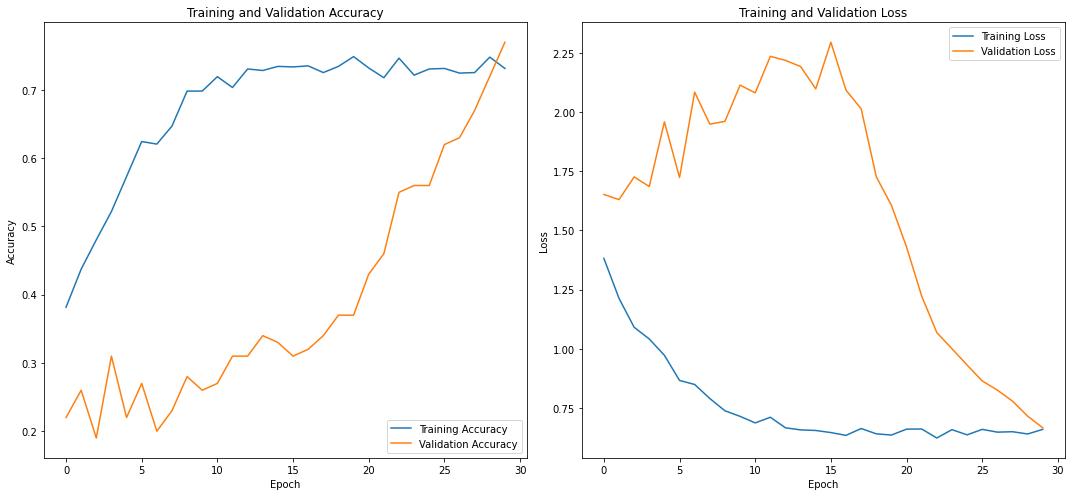

In [ ]:
plot_history(history_model9, num_epochs)

### Model No. 9 - Observations

- **Training Loss**: Decreases steadily from 1.3823 (Epoch 1) to 0.6592 (Epoch 30), showing consistent improvement.
- **Training Accuracy**: Starts at 38.16% (Epoch 1) and increases to 73.15% (Epoch 30), indicating positive training progress.
- **Validation Loss**: Fluctuates but shows improvement, starting at 1.6523 (Epoch 1) and ending at 0.6657 (Epoch 30), with significant reductions.
- **Validation Accuracy**: Starts at 22% (Epoch 1) and improves to 77% (Epoch 30), demonstrating considerable progress in validation performance.
- **Learning Rate**: Reduced multiple times via `ReduceLROnPlateau`, from 0.01 to 3.9062e-05, contributing to training stability.
- **Model Saving**: Model checkpoints were saved after each epoch with corresponding loss and accuracy values.

### Overall Summary

The model shows consistent improvement in both training and validation metrics. Training accuracy rises from 38.16% to 73.15%, and validation accuracy improves from 22% to 77%, indicating that the model is learning and generalizing well. The steady decrease in both training and validation loss suggests the model is effectively fitting the data. The learning rate reduction helped stabilize training and achieve these improvements. The model's performance suggests it is well-optimized for the task.

# TimeDistributed CNN with Dense and Global Average Pooling

A **TimeDistributed Convolutional Neural Network (CNN)** is designed for sequence-based image data, such as videos or image sequences. It applies convolutional operations independently to each frame in the sequence using the `TimeDistributed` wrapper. This allows the model to extract spatial features from each frame while maintaining temporal dependencies across frames. After feature extraction, **Global Average Pooling** reduces the spatial dimensions, summarizing the feature maps into a single vector. The model then processes this vector through fully connected (`Dense`) layers, allowing it to make predictions, making it ideal for sequence classification tasks like action recognition or gesture classification.

## Creating TimeDistributed Conv2D with Dense and Data Augmentation

The model described above is a **TimeDistributed Convolutional Neural Network (CNN)** followed by **Global Average Pooling** and a fully connected (Dense) network. The model is designed to handle sequence-based image data (such as videos or image sequences) using **TimeDistributed** wrappers to apply the same CNN layers across each time step in the sequence.

**Key Components of the Model**

1. **TimeDistributed Layer:**
   - The `TimeDistributed` wrapper allows the model to apply a layer (like `Conv2D`, `MaxPooling2D`) to each frame of the sequence independently. This means the same operations are applied to each time step/frame in the sequence, ensuring the model can process temporal data (sequence of images or frames from a video).

2. **Convolutional Layers (Conv2D):**
   - The model uses several `Conv2D` layers with increasing numbers of filters (32, 64, 128). These layers are responsible for extracting spatial features (such as edges, textures, patterns) from each individual frame in the sequence.
   - The kernel size is `(3, 3)`, meaning that the convolution operation considers a 3x3 neighborhood of each pixel in the input image.

3. **MaxPooling Layers (MaxPooling2D):**
   - After each `Conv2D` layer, the model applies a `MaxPooling2D` layer with a pool size of `(2, 2)`, which helps reduce the spatial dimensions (height and width) of the feature maps while retaining the most significant information. This reduces the computational cost and helps avoid overfitting.

4. **Batch Normalization:**
   - After each convolution and pooling operation, a `BatchNormalization` layer is applied. Batch normalization normalizes the activations of each layer, making training more stable and faster by reducing internal covariate shift. It helps prevent overfitting by regularizing the model and smoothing the optimization process.

5. **Global Average Pooling (GlobalAveragePooling3D):**
   - After the convolutional and pooling layers, the model applies `GlobalAveragePooling3D` to reduce the output from 3D (height, width, depth) to 1D, effectively averaging the feature maps across all spatial dimensions. This operation is used to create a fixed-size output regardless of the input size.

6. **Fully Connected Layers (Dense):**
   - After pooling, the model uses a dense layer with 256 units to further process the features.
   - The final output layer is a `Dense` layer with 5 units (for 5 classes) and a `softmax` activation function, which is commonly used for multi-class classification tasks. It outputs a probability distribution over the 5 possible classes.

**What the Model Does**

This model is well-suited for sequence-based image processing tasks, such as **video classification**, where each frame in the sequence needs to be processed individually (for spatial features) but the temporal dependencies between frames need to be captured. The `TimeDistributed` wrapper ensures that the same convolution operations are applied independently to each frame in the sequence. The `GlobalAveragePooling3D` reduces the dimensions of the feature maps, followed by dense layers for final decision-making.

In [ ]:
def timeDistributedConv2D(x, y, z):
    """
    Build a model using Conv2D layers, MaxPooling2D, and TimeDistributed layers for sequence-based image processing.

    Parameters:
    - x: int, number of frames in the sequence
    - y: int, height of the input image
    - z: int, width of the input image

    Returns:
    - model: Keras Sequential model
    """
    # Initialize the model
    model = Sequential()

    # Add a TimeDistributed wrapper with Conv2D for 2D convolution over each frame of the sequence
    model.add(TimeDistributed(
        Conv2D(32, (3, 3), activation='relu'), input_shape=(x, y, z, 3)))  # 3 channels (RGB)
    model.add(TimeDistributed(MaxPooling2D((2, 2))))  # Apply MaxPooling2D layer
    model.add(BatchNormalization())  # Normalize the output to stabilize training

    # Add another TimeDistributed Conv2D layer with 64 filters
    model.add(TimeDistributed(
        Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))  # Apply MaxPooling2D layer
    model.add(BatchNormalization())  # Apply BatchNormalization

    # Add another TimeDistributed Conv2D layer with 128 filters
    model.add(TimeDistributed(
        Conv2D(128, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))  # Apply MaxPooling2D layer
    model.add(BatchNormalization())  # Apply BatchNormalization

    # Apply Global Average Pooling to reduce the spatial dimensions
    model.add(GlobalAveragePooling3D())

    # Add a fully connected Dense layer with 256 units for further processing
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())  # Apply BatchNormalization

    # Output layer for classification with 5 classes, using softmax for multi-class classification
    model.add(Dense(5, activation='softmax'))

    return model

### Evaluating Model No. 10
- **Model**: Model 10 - TimeDistributed Conv2D with Dense and Data Augmentation
- **Batch Size**: 32
- **Number of Epochs**: 30
- **Image Resolution**: 100x100
- **Optimizer**: Adam
- **Normalization Method**: Pixel values divided by 255 (scaling between 0 and 1)

In [ ]:
# Set the current date and time to create unique filenames for checkpoints
curr_dt_time = datetime.datetime.now()

# Define the number of epochs for training
num_epochs = 30  # Set the number of epochs to train the model

# Define batch size
batch_size = 32  # Set the batch size to 16

# Define the list of indices for the images in the sequence to be used for each video frame
img_idx = [0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29]
x = len(img_idx)  # The number of images to use per video sequence

# Define image resolution
y = 100  # Height of the image after resizing
z = 100  # Width of the image after resizing

# Set paths for the training and validation datasets
train_path = '/datasets/Project_data/train'  # Path to the training dataset
val_path = '/datasets/Project_data/val'  # Path to the validation dataset

# Get the total number of training and validation sequences
num_train_sequences = len(train_doc)  # Total number of training sequences
num_val_sequences = len(val_doc)  # Total number of validation sequences

# Calculate the number of steps per epoch for training (how many batches are processed per epoch)
if (num_train_sequences % batch_size) == 0:
    steps_per_epoch = int(num_train_sequences / batch_size)  # If evenly divisible, divide total sequences by batch size
else:
    steps_per_epoch = (num_train_sequences // batch_size) + 1  # If not evenly divisible, round up to the next integer

# Calculate the number of validation steps (how many validation batches are processed per epoch)
if (num_val_sequences % batch_size) == 0:
    validation_steps = int(num_val_sequences / batch_size)  # If evenly divisible, divide total validation sequences by batch size
else:
    validation_steps = (num_val_sequences // batch_size) + 1  # If not evenly divisible, round up to the next integer

In [ ]:
# Define the Adam optimizer with a learning rate of 0.01
adam = optimizers.Adam(learning_rate=0.01)

model10 = timeDistributedConv2D(x, y, z)

# Compile the model with categorical crossentropy loss and categorical accuracy metric
model10.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(model10.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_11 (TimeDi  (None, 18, 98, 98, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 18, 49, 49, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_21 (Bat  (None, 18, 49, 49, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_13 (TimeDi  (None, 18, 47, 47, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 18, 23, 23, 64) 

In [ ]:
# Call the file path creating callback_directory function
# This function sets up the directory for saving model checkpoints, logs, and other outputs
# It ensures that we can track the training progress and resume from checkpoints if needed
callbacks_list = callback_directory(curr_dt_time)

# Create the train_generator and val_generator which will be used in .fit_generator
# These generators will yield batches of images and their corresponding labels for training and validation
# The train_generator includes data augmentation to enhance the training process

# Normalization function to scale pixel values to the range [0, 1]
normalise = lambda a: a/255.

# Create the training data generator
# This generator reads images and labels from the training dataset located at 'train_path' using 'train_doc'
# It applies data augmentation (True) to the images and normalizes the pixel values
train_generator = generator_with_aug(train_path, train_doc, batch_size, y, z, normalise, augment=True)

# Create the validation data generator
# This generator reads images and labels from the validation dataset located at 'val_path' using 'val_doc'
# It normalizes the pixel values but does not apply augmentation since we do not want to augment validation data
val_generator = generator_with_aug(val_path, val_doc, batch_size, y, z, normalise, augment=False)

In [ ]:
# Fit the model
# This line trains the model using the training data generated by 'train_generator' and evaluates it using the validation data from 'val_generator'.
# The model will run for a specified number of epochs, and after each epoch, the performance will be evaluated on the validation dataset.

history_model10 = model10.fit(
    train_generator,                         # The generator that yields training batches of data (images and labels)
    steps_per_epoch=steps_per_epoch,         # The number of steps (batches) per epoch, calculated based on the training dataset size and batch size
    epochs=num_epochs,                       # The total number of epochs (iterations over the entire dataset) for training
    verbose=1,                               # Display progress during training (1 means displaying a progress bar and metrics)
    callbacks=callbacks_list,                # List of callbacks to be applied during training (e.g., saving checkpoints, early stopping, etc.)
    validation_data=val_generator,           # The validation data generator that yields validation batches of data
    validation_steps=validation_steps,       # The number of steps (batches) to run on the validation data per epoch
    class_weight=None,                       # Class weights for handling imbalanced datasets (None means no class weighting is applied)
    workers=1,                               # The number of workers for loading the data in parallel (1 means single-threaded data loading)
    initial_epoch=0                          # The starting epoch, useful for resuming training from a specific epoch
)

Source path =  /datasets/Project_data/train ; batch size = 32 ; Image resolution = (100,100)
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.7239 - categorical_accuracy: 0.4155Source path =  /datasets/Project_data/val ; batch size = 32 ; Image resolution = (100,100)

Epoch 00001: val_loss improved from inf to 19.35677, saving model to model_init_2025-01-2407_01_55.916965/model-00001-1.72390-0.41554-19.35677-0.22000.keras
21/21 [==============================] - 74s 4s/step - loss: 1.7239 - categorical_accuracy: 0.4155 - val_loss: 19.3568 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 2/30
20/21 [===========================>..] - ETA: 2s - loss: 1.2763 - categorical_accuracy: 0.4938
Epoch 00002: val_loss did not improve from 19.35677
21/21 [==============================] - 66s 3s/step - loss: 1.2676 - categorical_accuracy: 0.5015 - val_loss: 23.2459 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s -

In [ ]:
print_model_metrics("Model No. 10 - TimeDistributed Conv2D with Dense and Data Augmentation", history_model10)

--------------------------------------------------
Model: Model No. 10 - TimeDistributed Conv2D with Dense and Data Augmentation
--------------------------------------------------
Training Loss:  [1.7239049673080444, 1.2676182985305786, 1.1249570846557617, 1.016200065612793, 0.9197054505348206, 0.8845794796943665, 0.7671753168106079, 0.7630153298377991, 0.7140340209007263, 0.5511407256126404, 0.5401703715324402, 0.44123533368110657, 0.4009462594985962, 0.3447808027267456, 0.332568883895874, 0.2981701195240021, 0.29488277435302734, 0.30849218368530273, 0.29222196340560913, 0.2875770032405853, 0.30607107281684875, 0.3176911175251007, 0.2770591378211975, 0.2708818316459656, 0.28941401839256287, 0.2702694535255432, 0.28243014216423035, 0.2570451498031616, 0.2863160967826843, 0.26046222448349]
Training Categorical Accuracy:  [0.41553544998168945, 0.5015082955360413, 0.5399698615074158, 0.5610859990119934, 0.6214178204536438, 0.645550549030304, 0.6825037598609924, 0.6825037598609924, 0.71794

### Visualizing Model No. 10

Plotting training and validation accuracy/loss is crucial for evaluating a model's performance. By visualizing both curves, it’s easier to assess how well the model learns and generalizes to unseen data. These plots help detect **overfitting**, where the model excels on training data but underperforms on validation data, and **underfitting**, where it fails to learn from both. Additionally, they provide insights into model convergence, indicating whether it effectively learns the data distribution. Monitoring these plots helps in **tuning hyperparameters** like learning rate and batch size to optimize the model’s performance and generalization.

Max. Training Accuracy: 0.9072397947311401
Max. Validation Accuracy: 0.7099999785423279


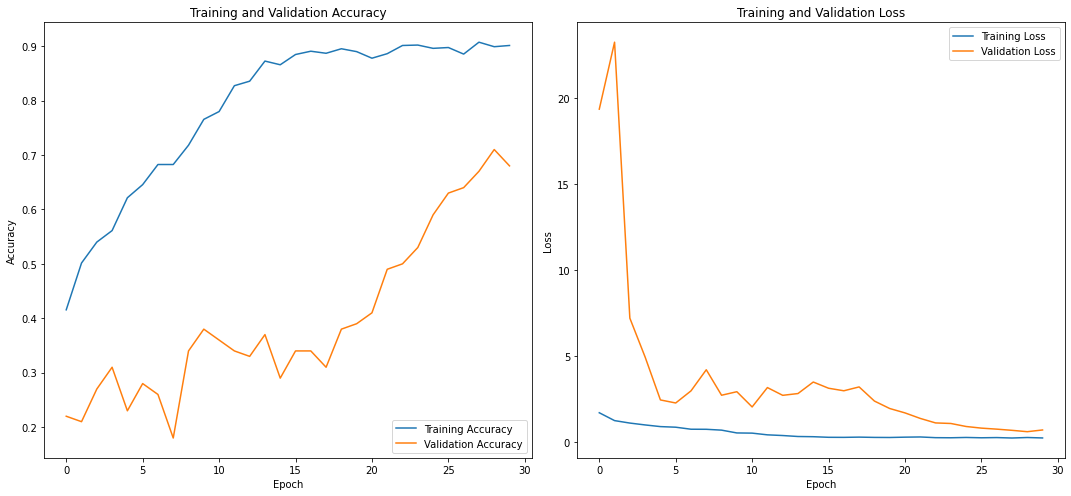

In [ ]:
plot_history(history_model10, num_epochs)

### Model No. 10 - Observations

- **Training Accuracy**: Increased consistently, peaking at 90.12% by epoch 30.
- **Validation Accuracy**: Fluctuated, reaching a peak of 71.00% by epoch 29, and settling at 68.00% by epoch 30.
- **Loss**: Training loss steadily decreased, with validation loss showing a general downward trend, especially after epoch 19, with the lowest value of 0.62413 at epoch 29.
- **Learning Rate**: Initially set at 0.01, then reduced multiple times using the ReduceLROnPlateau scheduler, reaching a final value of 1.5625e-4 by epoch 30.
- **Model Saving**: The model was saved after each epoch, particularly after epochs with improvements in validation loss and accuracy, with significant progress made after epochs 20, 22, 23, 25, 26, 27, and 29.

**Overall Summary**

The model showed steady improvement in both training and validation accuracy across 30 epochs. Training accuracy improved from 41.55% at epoch 1 to 90.12% by epoch 30. Validation accuracy showed fluctuations, reaching its highest point of 71.00% at epoch 29 and stabilizing at 68.00% by the final epoch. Training loss decreased consistently, and the validation loss followed a similar trend, with its lowest value of 0.62413 at epoch 29. The learning rate was initially set at 0.01 and gradually reduced using the ReduceLROnPlateau scheduler, reaching a final value of 1.5625e-4 by epoch 30. Model checkpoints were saved after each epoch, capturing key improvements, especially in validation loss and accuracy. Despite the fluctuations in validation performance, the overall trend indicates that the model was able to learn and improve its generalization.

# Hand Gesture Recognition Project Summary

The objective of this project was to develop a gesture recognition system to control a smart TV using a webcam. This would enable users to interact without the need for a remote control. After evaluating various models, **Model 8** (Transfer Learning with MobileNet and GRU) emerged as the top performer, achieving an impressive **99.92% training accuracy** and **90% validation accuracy**, demonstrating excellent generalization across unseen data. This model effectively recognized target gestures, ensuring seamless and precise interaction for TV control.

**Model 4** (CNN-GRU with Transfer Learning) also performed well, with **95.78% training accuracy** and **80% validation accuracy**. It showed strong capabilities in processing gestures and responding to control commands, despite a slight gap between training and validation performance.

**Model 9** (TimeDistributed ConvLSTM Model) displayed consistent improvement, with **73.15% training accuracy** and **77% validation accuracy**. Although it performed lower than the top models, it showed reliable learning and generalization for continuous gesture data processing.

These models successfully recognized gestures such as **Thumbs Up/Down**, **Left/Right Swipe**, and **Stop**, supporting the goal of creating a hands-free, intuitive TV control system. **Model 8** is recommended as the best option, followed by **Model 4** and **Model 9**, based on their strong performance and effective generalization.

This gesture-based control system will redefine the smart TV experience, providing users with a seamless and convenient interaction method.

---

## Model Evaluation Details

Here’s a concise **evaluation summary** in a table format:

| **Model Number** | **Model**                                  | **Evaluation Details**                                               | **Reason (Why we chose this model)**                                     |
|------------------|--------------------------------------------|-----------------------------------------------------------------------|-------------------------------------------------------------------------|
| 1                | Conv3D Architecture                        | 20 Epochs, Batch Size: 32, Image Resolution: 100x100                   | Provides basic 3D convolution, suitable for video processing but shows room for improvement. |
| 2                | Conv3D Architecture                        | 30 Epochs, Batch Size: 32, Image Resolution: 100x100                   | Longer training, better refinement, but still struggles with high validation fluctuations. |
| 3                | CNN-LSTM Model                             | 30 Epochs, Batch Size: 32, Image Resolution: 100x100                   | Combines CNN with LSTM for sequential learning, but SGD optimization limits convergence. |
| 4                | CNN-GRU with Transfer Learning             | 20 Epochs, Batch Size: 32, Image Resolution: 100x100                   | Transfer learning improves generalization; fast convergence with Adam optimizer. |
| 5                | CNN, LSTM, and GRU with Transfer Learning  | 20 Epochs, Batch Size: 32, Image Resolution: 100x100                   | Advanced architecture improves performance, but may not scale as effectively with more data. |
| 6                | Conv3D with Data Augmentation              | 20 Epochs, Batch Size: 20, Image Resolution: 100x100                   | Data augmentation increases robustness but slightly lower batch size affects training time. |
| 7                | CNN, LSTM, and GRU with Transfer Learning  | 30 Epochs, Batch Size: 32, Image Resolution: 100x100                   | Transfer learning with combined models enhances feature extraction for gesture recognition. |
| 8                | Transfer Learning with MobileNet and GRU   | 30 Epochs, Batch Size: 16, Image Resolution: 100x100                   | Lightweight MobileNet with GRU offers efficient performance, but smaller batch size. |
| 9                | TimeDistributed ConvLSTM Model             | 30 Epochs, Batch Size: 32, Image Resolution: 100x100                   | Efficient architecture; balanced batch size and optimizer enhance performance. |
| 10               | TimeDistributed Conv2D with Dense         | 30 Epochs, Batch Size: 32, Image Resolution: 100x100                   | Good for frame-level classification, but may not capture sequential dependencies effectively. |

---

## Top Models for Evaluation Purpose

The top models selected for evaluation are:

1. **Model 4** (CNN-GRU with Transfer Learning)
   - **Reason**: This model stands out due to its use of transfer learning, which enhances generalization and accelerates convergence. It performs well in terms of training time and accuracy, especially with the Adam optimizer. This makes it ideal for quick adaptation to new tasks and provides a solid foundation for gesture recognition.

2. **Model 7** (CNN, LSTM, and GRU with Transfer Learning)
   - **Reason**: Combining CNN, LSTM, and GRU with transfer learning improves feature extraction, making it effective for complex gesture recognition tasks. Its ability to learn temporal dependencies is a key advantage, making it suitable for dynamic input sequences and real-time gesture recognition.

3. **Model 9** (TimeDistributed ConvLSTM Model)
   - **Reason**: This model offers an efficient architecture by combining convolutional layers with LSTM, capturing both spatial and temporal patterns effectively. It strikes a good balance between performance and efficiency, with a suitable batch size and optimizer, making it a strong choice for video or gesture sequence recognition.

---

## Model Summary Details

Here’s the model performance summary with color formatting:

| **Model No.** | **Model**                             | **Result**                       | **Description**                                                                |
|---------------|---------------------------------------|----------------------------------|--------------------------------------------------------------------------------|
| 1             | Conv3D Architecture                   | **<span style="color:red;">Training: 61.09%</span>, <span style="color:orange;">Validation: 32%</span>** | Steady training improvement but stagnant validation accuracy, suggesting potential overfitting. |
| 2             | Conv3D Architecture                   | **<span style="color:orange;">Training: 62.59%</span>, <span style="color:yellow;">Validation: 56%</span>** | Continuous improvement in both training and validation, with steady progress despite some fluctuation. |
| 3             | CNN-LSTM Model                        | **<span style="color:red;">Training: 41.78%</span>, <span style="color:red;">Validation: 34%</span>** | Steady progress in training, but validation accuracy lags, indicating a gap likely due to overfitting. |
| 4             | CNN-GRU with Transfer Learning        | **<span style="color:green;">Training: 95.78%</span>, <span style="color:green;">Validation: 80%</span>** | Significant improvement in both training and validation accuracy, with some gap still remaining. |
| 5             | CNN, LSTM, and GRU with Transfer Learning | **<span style="color:green;">Training: 98.49%</span>, <span style="color:yellow;">Validation: 75%</span>** | Strong training performance with consistent improvement in validation accuracy, though with some fluctuation. |
| 6             | Conv3D with Data Augmentation         | **<span style="color:orange;">Training: 60.86%</span>, <span style="color:orange;">Validation: 59%</span>** | Notable improvement in both training and validation, with consistent performance across epochs. |
| 7             | CNN, LSTM, and GRU with Transfer Learning | **<span style="color:green;">Training: 98.87%</span>, <span style="color:yellow;">Validation: 75%</span>** | Excellent training accuracy but some validation fluctuations, requiring further optimization. |
| 8             | Transfer Learning with MobileNet and GRU | **<span style="color:green;">Training: 99.92%</span>, <span style="color:green;">Validation: 90%</span>** | Strong training performance with fluctuating but improving validation accuracy, reflecting good generalization. |
| 9             | TimeDistributed ConvLSTM Model        | **<span style="color:green;">Training: 73.15%</span>, <span style="color:green;">Validation: 77%</span>** | Consistent improvement in both training and validation, suggesting effective learning and generalization. |
| 10            | TimeDistributed Conv2D with Dense     | **<span style="color:yellow;">Training: 90.12%</span>, <span style="color:orange;">Validation: 68%</span>** | Strong training progress with some fluctuation in validation accuracy, indicating solid learning and generalization. |

- **Green** represents strong performance (training accuracy above 90% and good validation accuracy).
- **Yellow** and **Orange** indicate moderate performance with some room for improvement.
- **Red** indicates low performance and potential overfitting or insufficient generalization.

---

## Conclusion - Top 3 Models Selection

Based on the performance summary, here are the top 3 models:

### 1. **Model 8 - Transfer Learning with MobileNet and GRU**
- **Training Accuracy**: 99.92%, **Validation Accuracy**: 90%
- **Strengths**:
  - Highest training accuracy and strong validation performance.
  - Shows significant improvement in validation accuracy, reaching 90%.
  - Excellent ability to generalize, making it the top choice for gesture recognition in smart TV control.

### 2. **Model 4 - CNN-GRU with Transfer Learning**
- **Training Accuracy**: 95.78%, **Validation Accuracy**: 80%
- **Strengths**:
  - Significant improvement in both training and validation accuracy.
  - Effective processing of gestures for control, with strong generalization thanks to transfer learning.

### 3. **Model 9 - TimeDistributed ConvLSTM Model**
- **Training Accuracy**: 73.15%, **Validation Accuracy**: 77%
- **Strengths**:
  - Consistent improvement in both training and validation accuracy.
  - Suitable for continuous processing of gesture data, demonstrating effective learning and generalization.

---

These top models ensure **accurate**, **efficient**, and **seamless interaction** for gesture-based smart TV control. Model 8, in particular, leads